# Computing gradient

Training DNNs requires computing gradient of the loss with respect to the parameters, and this is topic of this notebook.

Your task will be to:

* Implement Evolution Search training of DNNs that does not require backpropagation
* Implement forward and backward functions for Linear and ReQU modules

Goal is to:

* Introduce ingredients necessary to train NN:
    * model
    * loss
    * optimizer
* Introduce different ways of computing or estimating $\frac{\partial{L(w)}}{{\partial w}}$
* Get understanding of Evolution Search and Backpropagation algorithms

Exam:

* For exam you are expected to understand how backpropagation works. Questions might refer to implementation details in PyTorch. See also Resources section for a good video about backpropgation, and how it is implemented in PyTorch.

What's (probably) next:

* Go through each component of the training loop:
    * (Lab 5) Neural Networks practical, part 1: architecture, understanding what is learned
    * (Lab 6, ?) Neural Networks practical part 2: setting up data and loss
    * (Lab 7, ?) Neural Networks practical part 3: optimization

Resources:

* Backprop with focus on PyTorch: https://www.youtube.com/watch?v=ma2KXWblllc (see also other lectures from this series)

* Lecture on backpropagation https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/ (Lecture 8)

* Evolution Search https://eng.uber.com/deep-neuroevolution/, https://arxiv.org/abs/1712.06564

* Matrix derivatives http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf

# SGD requires $\frac{\partial L (w) }{\partial w}$!

<p>
<font size=5>
$$\frac{\partial L (w) }{\partial w} = \frac{1}{K} \sum_{i=1}^{K} \frac{\partial L (x_i, w) }{\partial w}$$
</font>
</p>

<img width=600 src="https://github.com/gmum/nn2018/raw/master/lab/fig/3/sgd.png">

# Setup 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import json

import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.autograd import Variable

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl

from torch.autograd import gradcheck

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# Convert to Torch Tensor. Just to avoid boilerplate code later
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]

/home/kg/miniconda3/envs/nn2018/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Some helper functions

def get_model_weights(model):
    params = model.state_dict()
    p_order = [p[0] for p in sorted(model.named_parameters())]
    return np.concatenate([params[w].cpu().numpy().reshape(-1, ) for w in p_order])
    
def set_model_weights(model, w):
    params = model.state_dict()  
    p_order = [p[0] for p in sorted(model.named_parameters())]
    id = 0
    for p in p_order:
        shape = params[p].shape
        D = np.prod(shape)
        params[p].copy_(torch.from_numpy(w[id:id + D].reshape(shape)))
        id += D
        
def L(w, loss, model, batch_size=10, x_tr=x_train, y_tr=y_train):
    set_model_weights(model, w)
    cost = 0.
    n_examples, n_features = x_tr.size()
    num_batches = n_examples // batch_size
    for k in range(num_batches): 
        start, end = k * batch_size, (k + 1) * batch_size
        x = Variable(x_tr[start:end], requires_grad=False)
        y = Variable(y_tr[start:end], requires_grad=False)
        fx = model.forward(x)
        cost += loss.forward(fx, y)
    return cost.data.numpy()[0] / num_batches

# Training loop in PyTorch

In this section we walk through implementation of a traditional training loop  in PyTorch.

Necessary ingredients to train a neural network are:
    * model
    * loss
    * optimizer
    
<img width=400 src="https://github.com/gmum/nn2018/raw/master/lab/fig/4/smoothie.png">

Ref:

https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/3_neural_net.py

In [3]:
def build_logreg(input_dim, output_dim, weight_module=torch.nn.Linear):
    model = torch.nn.Sequential()
    model.add_module("linear_2", weight_module(input_dim, output_dim, bias=False))
    return model

In [4]:
def build_model(input_dim, output_dim, nonlinearity=torch.nn.functional.sigmoid, weight_module=torch.nn.Linear):
    class Nonlinearity(torch.nn.Module):
        def forward(self, input):
            return nonlinearity(input)
    
    model = torch.nn.Sequential()
    model.add_module("linear_1", weight_module(input_dim, 512, bias=False))
    model.add_module("nonlinearity_1", Nonlinearity())
    model.add_module("linear_2", weight_module(512, output_dim, bias=False))
    return model

In [5]:
def sgd_step(model, loss, x_val, y_val, lr=0.1, momentum=0.9):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward(retain_graph=True)

    # Update parameters
    optimizer.step()

    return output.data[0]

In [6]:
def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)

In [7]:
def train(model, loss, step_fnc):
    torch.manual_seed(42)
    n_examples, n_features = x_train.size()
    n_classes = 10
    batch_size = 100
    history = []
    for i in tqdm.tqdm(range(100), total=100):
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step_fnc(model, loss, x_train[start:end], y_train[start:end])
        predY = predict(model, x_test)
        print(("Epoch %d, cost = %f, acc = %.2f%%"
              % (i + 1, cost / num_batches, 100. * np.mean(predY == y_test.numpy()))))
        
        history.append(cost)
        
    return np.mean(predY == y_test.numpy()), history

## Run training

In [8]:
model = build_model(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
train(step_fnc=sgd_step, loss=loss, model=model)

  2%|▏         | 2/100 [00:00<00:18,  5.38it/s]

Epoch 1, cost = 2.389522, acc = 9.50%
Epoch 2, cost = 2.292640, acc = 9.60%


  3%|▎         | 3/100 [00:00<00:16,  5.78it/s]

Epoch 3, cost = 2.179020, acc = 15.90%


  5%|▌         | 5/100 [00:00<00:17,  5.43it/s]

Epoch 4, cost = 2.052898, acc = 26.20%
Epoch 5, cost = 1.919308, acc = 34.40%


  7%|▋         | 7/100 [00:01<00:16,  5.69it/s]

Epoch 6, cost = 1.788110, acc = 42.10%
Epoch 7, cost = 1.667627, acc = 48.90%


  9%|▉         | 9/100 [00:01<00:14,  6.34it/s]

Epoch 8, cost = 1.561546, acc = 53.80%
Epoch 9, cost = 1.469896, acc = 57.10%


 11%|█         | 11/100 [00:01<00:14,  5.95it/s]

Epoch 10, cost = 1.390999, acc = 59.30%
Epoch 11, cost = 1.322782, acc = 60.80%


 13%|█▎        | 13/100 [00:02<00:13,  6.29it/s]

Epoch 12, cost = 1.263350, acc = 62.10%
Epoch 13, cost = 1.211143, acc = 63.00%


 15%|█▌        | 15/100 [00:02<00:13,  6.47it/s]

Epoch 14, cost = 1.164917, acc = 64.40%
Epoch 15, cost = 1.123690, acc = 65.50%


 17%|█▋        | 17/100 [00:02<00:13,  6.16it/s]

Epoch 16, cost = 1.086678, acc = 66.70%
Epoch 17, cost = 1.053251, acc = 67.90%


 19%|█▉        | 19/100 [00:03<00:13,  6.03it/s]

Epoch 18, cost = 1.022895, acc = 68.40%
Epoch 19, cost = 0.995193, acc = 68.50%


 21%|██        | 21/100 [00:03<00:11,  6.71it/s]

Epoch 20, cost = 0.969799, acc = 69.20%
Epoch 21, cost = 0.946424, acc = 69.40%


 23%|██▎       | 23/100 [00:03<00:10,  7.32it/s]

Epoch 22, cost = 0.924828, acc = 69.70%
Epoch 23, cost = 0.904810, acc = 70.20%


 25%|██▌       | 25/100 [00:03<00:09,  7.78it/s]

Epoch 24, cost = 0.886195, acc = 70.40%
Epoch 25, cost = 0.868838, acc = 70.50%


 27%|██▋       | 27/100 [00:04<00:09,  7.91it/s]

Epoch 26, cost = 0.852610, acc = 70.80%
Epoch 27, cost = 0.837400, acc = 71.00%


 29%|██▉       | 29/100 [00:04<00:10,  6.84it/s]

Epoch 28, cost = 0.823112, acc = 71.10%
Epoch 29, cost = 0.809659, acc = 71.00%


 31%|███       | 31/100 [00:04<00:10,  6.65it/s]

Epoch 30, cost = 0.796966, acc = 71.10%
Epoch 31, cost = 0.784965, acc = 71.60%


 33%|███▎      | 33/100 [00:05<00:11,  6.07it/s]

Epoch 32, cost = 0.773595, acc = 72.00%
Epoch 33, cost = 0.762803, acc = 72.50%


 35%|███▌      | 35/100 [00:05<00:11,  5.49it/s]

Epoch 34, cost = 0.752540, acc = 72.90%
Epoch 35, cost = 0.742761, acc = 72.90%


 37%|███▋      | 37/100 [00:05<00:10,  5.86it/s]

Epoch 36, cost = 0.733428, acc = 72.90%
Epoch 37, cost = 0.724504, acc = 73.00%


 39%|███▉      | 39/100 [00:06<00:10,  5.99it/s]

Epoch 38, cost = 0.715956, acc = 73.40%
Epoch 39, cost = 0.707756, acc = 73.60%


 41%|████      | 41/100 [00:06<00:09,  6.31it/s]

Epoch 40, cost = 0.699878, acc = 73.60%
Epoch 41, cost = 0.692296, acc = 73.70%


 43%|████▎     | 43/100 [00:06<00:09,  6.12it/s]

Epoch 42, cost = 0.684989, acc = 74.00%
Epoch 43, cost = 0.677937, acc = 74.10%


 45%|████▌     | 45/100 [00:07<00:09,  6.07it/s]

Epoch 44, cost = 0.671123, acc = 74.20%
Epoch 45, cost = 0.664529, acc = 74.50%


 47%|████▋     | 47/100 [00:07<00:08,  6.01it/s]

Epoch 46, cost = 0.658140, acc = 74.50%
Epoch 47, cost = 0.651944, acc = 74.50%


 49%|████▉     | 49/100 [00:07<00:08,  6.09it/s]

Epoch 48, cost = 0.645927, acc = 74.60%
Epoch 49, cost = 0.640079, acc = 74.40%


 51%|█████     | 51/100 [00:08<00:07,  6.64it/s]

Epoch 50, cost = 0.634388, acc = 74.30%
Epoch 51, cost = 0.628846, acc = 74.30%


 53%|█████▎    | 53/100 [00:08<00:07,  5.93it/s]

Epoch 52, cost = 0.623443, acc = 74.30%
Epoch 53, cost = 0.618173, acc = 74.50%


 55%|█████▌    | 55/100 [00:08<00:07,  6.23it/s]

Epoch 54, cost = 0.613027, acc = 74.60%
Epoch 55, cost = 0.607999, acc = 74.60%


 57%|█████▋    | 57/100 [00:09<00:06,  6.14it/s]

Epoch 56, cost = 0.603083, acc = 74.60%
Epoch 57, cost = 0.598273, acc = 74.80%


 59%|█████▉    | 59/100 [00:09<00:06,  5.88it/s]

Epoch 58, cost = 0.593565, acc = 75.00%
Epoch 59, cost = 0.588952, acc = 75.20%


 61%|██████    | 61/100 [00:09<00:06,  5.97it/s]

Epoch 60, cost = 0.584432, acc = 75.50%
Epoch 61, cost = 0.580000, acc = 75.50%


 63%|██████▎   | 63/100 [00:10<00:05,  6.23it/s]

Epoch 62, cost = 0.575652, acc = 75.60%
Epoch 63, cost = 0.571385, acc = 75.80%


 65%|██████▌   | 65/100 [00:10<00:06,  5.67it/s]

Epoch 64, cost = 0.567195, acc = 75.90%
Epoch 65, cost = 0.563080, acc = 76.10%


 67%|██████▋   | 67/100 [00:10<00:05,  6.36it/s]

Epoch 66, cost = 0.559037, acc = 76.20%
Epoch 67, cost = 0.555064, acc = 76.10%


 69%|██████▉   | 69/100 [00:11<00:04,  6.40it/s]

Epoch 68, cost = 0.551157, acc = 76.30%
Epoch 69, cost = 0.547315, acc = 76.30%


 71%|███████   | 71/100 [00:11<00:04,  6.68it/s]

Epoch 70, cost = 0.543536, acc = 76.30%
Epoch 71, cost = 0.539817, acc = 76.40%


 73%|███████▎  | 73/100 [00:11<00:04,  6.63it/s]

Epoch 72, cost = 0.536158, acc = 76.30%
Epoch 73, cost = 0.532555, acc = 76.30%


 75%|███████▌  | 75/100 [00:12<00:04,  6.20it/s]

Epoch 74, cost = 0.529008, acc = 76.30%
Epoch 75, cost = 0.525515, acc = 76.30%


 77%|███████▋  | 77/100 [00:12<00:03,  6.60it/s]

Epoch 76, cost = 0.522074, acc = 76.60%
Epoch 77, cost = 0.518684, acc = 76.60%


 79%|███████▉  | 79/100 [00:12<00:02,  7.23it/s]

Epoch 78, cost = 0.515345, acc = 76.60%
Epoch 79, cost = 0.512053, acc = 76.70%


 81%|████████  | 81/100 [00:12<00:02,  7.31it/s]

Epoch 80, cost = 0.508809, acc = 77.00%
Epoch 81, cost = 0.505611, acc = 77.00%


 83%|████████▎ | 83/100 [00:13<00:02,  7.58it/s]

Epoch 82, cost = 0.502459, acc = 77.20%
Epoch 83, cost = 0.499350, acc = 77.30%


 85%|████████▌ | 85/100 [00:13<00:02,  6.65it/s]

Epoch 84, cost = 0.496284, acc = 77.30%
Epoch 85, cost = 0.493261, acc = 77.30%


 87%|████████▋ | 87/100 [00:13<00:01,  6.52it/s]

Epoch 86, cost = 0.490278, acc = 77.30%
Epoch 87, cost = 0.487336, acc = 77.50%


 89%|████████▉ | 89/100 [00:14<00:01,  6.18it/s]

Epoch 88, cost = 0.484434, acc = 77.50%
Epoch 89, cost = 0.481569, acc = 77.70%


 91%|█████████ | 91/100 [00:14<00:01,  6.21it/s]

Epoch 90, cost = 0.478743, acc = 77.70%
Epoch 91, cost = 0.475953, acc = 77.70%


 93%|█████████▎| 93/100 [00:14<00:01,  6.37it/s]

Epoch 92, cost = 0.473200, acc = 77.70%
Epoch 93, cost = 0.470482, acc = 77.80%


 95%|█████████▌| 95/100 [00:14<00:00,  6.64it/s]

Epoch 94, cost = 0.467798, acc = 77.70%
Epoch 95, cost = 0.465149, acc = 77.60%


 97%|█████████▋| 97/100 [00:15<00:00,  7.21it/s]

Epoch 96, cost = 0.462533, acc = 77.70%
Epoch 97, cost = 0.459950, acc = 77.90%


 99%|█████████▉| 99/100 [00:15<00:00,  7.44it/s]

Epoch 98, cost = 0.457398, acc = 78.00%
Epoch 99, cost = 0.454878, acc = 77.90%


100%|██████████| 100/100 [00:15<00:00,  7.38it/s]

Epoch 100, cost = 0.452388, acc = 77.90%


(0.779,
 [23.895220041275024,
  22.926398277282715,
  21.79020094871521,
  20.528984665870667,
  19.193076729774475,
  17.881102681159973,
  16.67626929283142,
  15.615462303161621,
  14.698957085609436,
  13.909989356994629,
  13.227818727493286,
  12.633501768112183,
  12.111429572105408,
  11.649174451828003,
  11.236904382705688,
  10.866782307624817,
  10.53250527381897,
  10.228952407836914,
  9.95193338394165,
  9.697985708713531,
  9.464238584041595,
  9.248284876346588,
  9.048097610473633,
  8.861953437328339,
  8.688378751277924,
  8.526096224784851,
  8.373998522758484,
  8.231115579605103,
  8.096587657928467,
  7.96965754032135,
  7.849647521972656,
  7.735953450202942,
  7.628033459186554,
  7.525400757789612,
  7.427613437175751,
  7.334277272224426,
  7.245036363601685,
  7.159562766551971,
  7.077564716339111,
  6.998776853084564,
  6.922959327697754,
  6.849890291690826,
  6.779373288154602,
  6.711226999759674,
  6.645286381244659,
  6.5814032554626465,
  6.51943999

# Estimating $\frac{\partial L (w) }{\partial w}$

In this section we will implement different gradient computation functions

## Finite Difference
<p>
<font size=4>
Assuming we know direction we want to optimize in, we can approximate derivative simply by calculating

$$\langle \frac{\partial L (w) }{\partial w}, \vec{v} \rangle \approx \frac{L(w) - L(w + v)}{|\vec{v}|}$$


, where $L(w)$ denotes esimation of loss (e.g. over whole training set, over $5\%$ etc.). 

</font>
</p>

<p>
<font size=4>
As we will see later PyTorch uses Finite Difference method in gradient checks of automatic diffentiation modules.
</font>
</p>

## Evolution Search

<p>
Intuitively, Evolution Search (ES) approximates gradient by computing multiple times finite difference. Importantly it works for non-differentiable costs as well.
</p>

<p>
<font size=4>
$$ \frac{\partial L (w) }{\partial w} \approx \frac{1}{N \sigma} \sum \vec{v} ( L(w + \vec{v}) - L(w) )$$


, where $\epsilon$ is a normally distributed vector sampled from gauss of standard deviation $\sigma$, and $L(w)$ denotes esimation of loss (e.g. over whole training set, over $5\%$ etc.). 

</font>
</p>

<p>
<font size=4>
Note: while it is recommended to not use minibatching in ES, for simplicity we will.
</font>
</p>

## Implement Evolution Search

In [9]:
def ES_grad(model, loss, x_tr, y_tr, sigma=0.001, N=100):
    """
    Estimate dL/dw using Evolution Search.
    
    Params
    ------
    model: torch.nn.Model
        Model to take optimization step on
    loss: torch.nn.Module
        Loss function to optimize
    x_tr: torch.Tensor, (n_examples, n_features)
        Batch to compute gradient over
    y_tr: torch.Tensor, (n_examples, )
        Batch to compute gradient over
    sigma: float
    
    N: int
        
    Returns
    -------
    g: np.vector, size: (D, )
        Gradient of loss with respect to model's weights
    """
    grad = 0
    init_w = get_model_weights(model)
    rng = np.random.RandomState()
    base_loss = L(w=init_w, model=model, loss=loss, x_tr=x_tr, y_tr=y_tr)
    for _ in tqdm.tqdm(range(N), total=N):
        v = rng.normal(loc=0, scale=sigma, size=len(init_w))  # Hint: use rng
        reward =  L(w=init_w + v, model=model, loss=loss, x_tr=x_tr, y_tr=y_tr) - base_loss  # Hint: use L
        grad += v * reward  # Hint: see equation
    return grad / (N * sigma)  # Hint: normalize!

In [10]:
# If code is slow, you can use build_logreg !
# model = build_logreg(784, 10) 
model = build_model(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
init_w = get_model_weights(model)

In [11]:
down = 0
for _ in range(10):
    loss_before = L(w=init_w, model=model, loss=loss)
    set_model_weights(model=model, w=init_w)
    v = ES_grad(model, loss, x_tr=x_train, y_tr=y_train, sigma=0.002, N=50)
    loss_after = L(w=init_w - 0.1*v, model=model, loss=loss)
    if loss_before > loss_after:
        down += 1
        print("Went down!")
print("{}/{}".format(down, 10))
# This code is stochastic, so of course sometimes this assert can fail. 
assert down > 6

  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


  0%|          | 0/50 [00:00<?, ?it/s]

Went down!


100%|██████████| 50/50 [00:05<00:00,  9.51it/s]

Went down!
10/10


## Implement own module

PyTorch enable defining own Modules. Here we will implement Linear and ReQu modules ourselves, to understand better how backpropagation works. 

Below you can find an example Module implementing the classial ReLU nonlinearity.

Ref: https://github.com/jcjohnson/pytorch-examples

In [12]:
class MyReLU(torch.autograd.Function):
  """
  We can implement our own custom autograd Functions by subclassing
  torch.autograd.Function and implementing the forward and backward passes
  which operate on Tensors.
  """
  def forward(self, input):
    """
    In the forward pass we receive a Tensor containing the input and return a
    Tensor containing the output. You can cache arbitrary Tensors for use in the
    backward pass using the save_for_backward method.
    """
    self.save_for_backward(input)
    return input.clamp(min=0)

  def backward(self, grad_output):
    """
    In the backward pass we receive a Tensor containing the gradient of the loss
    with respect to the output, and we need to compute the gradient of the loss
    with respect to the input.
    """
    input, = self.saved_tensors
    grad_input = grad_output.clone()
    print(grad_input)
    grad_input[input < 0] = 0
    return grad_input

In [13]:
# Gradient check passes!
input = (Variable(torch.randn(2,4).double(), requires_grad=True),)
assert(gradcheck(MyReLU(), input, eps=1e-6, atol=1e-4))


 1  0  0  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 1  0  0  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  1  0  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  1  0  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  1  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  1  0
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  1
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  1
 0  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 1  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 1  0  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  1  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  1  0  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  0  1  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  0  1  0
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  0  0  1
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  0  0  1
[torch.DoubleTensor of size 2x4]


 0  0  0  0
 0  0  0  0
[torch.DoubleTensor of size 2x4

In [14]:
model = build_model(784, 10, nonlinearity=MyReLU())
loss = torch.nn.CrossEntropyLoss(size_average=True)
_, H_relu = train(step_fnc=sgd_step, loss=loss, model=model)

  0%|          | 0/100 [00:00<?, ?it/s]


 2.7950e-04  2.2140e-04 -2.2376e-04  ...  -2.2330e-04  2.7440e-04  1.7838e-04
 4.9609e-04 -4.3948e-04 -2.3083e-04  ...  -3.7501e-04 -4.9470e-04 -5.0886e-04
 4.9806e-04 -4.3219e-04 -2.3189e-04  ...  -3.8196e-04 -4.9300e-04 -5.1121e-04
                ...                   ⋱                   ...                
-2.0769e-04 -1.9846e-04  4.8198e-04  ...   1.8303e-04 -3.9729e-04  1.5101e-04
-2.0071e-04 -2.0936e-04  4.7989e-04  ...   1.8298e-04 -4.0318e-04  1.5373e-04
 1.7960e-04  8.4157e-05  3.1673e-04  ...   9.0706e-05  1.1873e-04  2.4266e-04
[torch.FloatTensor of size 100x512]


 1.9853e-04  8.0422e-05  3.1638e-04  ...   1.0434e-04  1.2908e-04  2.6402e-04
 5.0432e-04 -4.2743e-04 -2.2480e-04  ...  -3.6893e-04 -4.7408e-04 -4.8193e-04
-1.8654e-04 -1.9542e-04  4.8274e-04  ...   1.8640e-04 -3.8781e-04  1.5288e-04
                ...                   ⋱                   ...                
-2.6511e-04  2.8421e-04  2.1425e-04  ...  -1.5254e-04  1.9829e-04  1.0265e-05
 2.5191e-04  2.2142e-04 -

  1%|          | 1/100 [00:00<00:21,  4.66it/s]


 5.2133e-04 -4.0697e-04 -2.4136e-04  ...  -3.6676e-04 -4.4979e-04 -5.3739e-04
 5.0878e-04 -3.8915e-04 -2.5764e-04  ...  -3.6797e-04 -4.1910e-04 -5.2112e-04
-4.0137e-05 -2.5319e-04 -5.2424e-05  ...   7.5472e-05  2.8381e-04  2.6950e-04
                ...                   ⋱                   ...                
-3.7784e-04  2.1095e-04 -2.3753e-05  ...  -1.9705e-06 -1.3491e-04 -2.4749e-04
 3.2377e-04  1.5390e-04 -4.2648e-05  ...   2.0383e-04 -5.9221e-06  3.2412e-04
-3.7559e-04  2.1409e-04 -2.4980e-05  ...  -8.1611e-06 -1.3590e-04 -2.5177e-04
[torch.FloatTensor of size 100x512]


 5.2780e-04 -4.6181e-04 -2.3412e-04  ...  -3.7239e-04 -4.8996e-04 -6.0233e-04
-3.3557e-04  8.3385e-05 -2.0784e-04  ...   3.9863e-05 -9.2096e-05 -6.2043e-04
-2.0317e-04 -2.0932e-04 -2.6351e-04  ...   1.9452e-04  2.2314e-04  1.4370e-04
                ...                   ⋱                   ...                
-6.0746e-05 -2.5323e-04 -4.1918e-05  ...   8.6929e-05  3.0223e-04  3.0573e-04
-4.1000e-04  2.0493e-04 -

  2%|▏         | 2/100 [00:00<00:19,  5.11it/s]


 5.2930e-05  8.9894e-05 -1.1932e-04  ...  -1.2060e-04  9.6104e-05  9.0069e-05
 7.1703e-05  2.4860e-04  2.3044e-04  ...   1.3376e-04  2.1688e-04  6.0722e-04
-3.1515e-04  2.3469e-04 -2.8719e-04  ...   3.0706e-05  7.0565e-05 -5.5499e-04
                ...                   ⋱                   ...                
-1.0196e-04 -1.0005e-04  3.8862e-04  ...   1.5879e-04 -1.5010e-04  1.4771e-04
-2.1357e-04  2.4948e-04  2.6350e-04  ...  -1.6504e-04  1.9368e-04  1.6215e-04
-3.0605e-04 -1.7971e-04 -2.8850e-04  ...   1.7705e-04  2.0497e-04  1.8241e-04
[torch.FloatTensor of size 100x512]


-2.8664e-04  2.3708e-04  2.4081e-04  ...  -1.6022e-04  1.2981e-04  5.7646e-05
 1.1979e-04  5.3316e-05  1.5584e-04  ...   7.9037e-05  2.1073e-05  1.7272e-04
-2.9308e-04 -2.8064e-04 -2.5726e-04  ...   1.9972e-04  1.2425e-04  3.7759e-05
                ...                   ⋱                   ...                
-2.8752e-04  1.4027e-04 -2.0978e-04  ...   4.6444e-05 -5.9202e-05 -7.4417e-04
 3.6558e-05  6.3539e-05 -

  3%|▎         | 3/100 [00:00<00:17,  5.68it/s]


 5.1971e-04 -3.6200e-04 -2.2732e-04  ...  -3.1055e-04 -3.2403e-04 -5.2746e-04
 5.8562e-04 -3.5751e-04 -2.6563e-04  ...  -3.5442e-04 -2.5326e-04 -3.5505e-04
-3.2640e-05 -2.9828e-04 -1.1913e-04  ...   7.0851e-05  2.2178e-04  1.5403e-04
                ...                   ⋱                   ...                
-3.9682e-04  1.0763e-04  8.8942e-05  ...   5.4189e-06 -1.4854e-04 -1.8775e-04
 3.9890e-04  1.2606e-04 -7.2995e-05  ...   2.0127e-04 -7.7705e-05  3.1776e-04
-3.7118e-04  1.1010e-04  8.1945e-05  ...  -5.5579e-06 -1.4029e-04 -1.7929e-04
[torch.FloatTensor of size 100x512]


 5.6229e-04 -5.6583e-04 -2.4679e-04  ...  -3.6949e-04 -4.8547e-04 -9.4558e-04
-3.3660e-04  1.7361e-04 -1.6672e-04  ...   5.2961e-05  2.4394e-05 -5.7740e-04
-3.0744e-05 -3.0297e-04 -3.3650e-04  ...   1.2717e-04  2.1456e-04  1.6747e-04
                ...                   ⋱                   ...                
-1.5071e-04 -2.0324e-04 -3.7524e-05  ...   1.0263e-04  3.4826e-04  4.5581e-04
-2.7741e-04  8.0616e-05  

  4%|▍         | 4/100 [00:00<00:15,  6.20it/s]


-2.9768e-04 -2.4393e-04 -3.2469e-04  ...   1.2633e-04  1.2726e-04  5.3886e-05
-5.1677e-05 -4.0995e-04 -2.4784e-04  ...   8.5972e-05  1.5341e-04 -5.3188e-05
 5.3795e-04 -4.7279e-04 -2.2684e-04  ...  -3.1591e-04 -4.3889e-04 -8.1353e-04
                ...                   ⋱                   ...                
 3.0993e-04  1.9022e-05 -1.6102e-04  ...   1.7235e-04 -1.1293e-04  1.2362e-04
-1.6517e-04  2.0426e-04  3.2786e-04  ...  -1.6755e-04  1.4329e-04  1.9101e-04
 3.6882e-04  2.1301e-05 -1.9698e-04  ...   2.0917e-04 -1.3865e-04  1.3792e-04
[torch.FloatTensor of size 100x512]


-1.8938e-04  2.0686e-04  3.4171e-04  ...  -1.9617e-04  1.0785e-04  9.9385e-05
-2.8575e-04 -2.7244e-04 -2.3841e-04  ...   1.3456e-04  5.7868e-05 -5.1182e-05
-1.0712e-04 -1.8479e-04 -8.0995e-05  ...   9.9547e-05  3.2171e-04  4.0451e-04
                ...                   ⋱                   ...                
 9.4057e-05  1.1397e-04 -6.3709e-05  ...  -1.2315e-04  6.8678e-05  8.2740e-05
 1.2192e-06 -6.0691e-05  

  5%|▌         | 5/100 [00:00<00:15,  6.30it/s]


-2.0513e-04  1.8517e-04  2.8794e-04  ...  -1.5999e-04  3.9324e-05  4.5257e-05
 4.5471e-05  3.2583e-05  3.2068e-05  ...   1.3072e-05 -3.5631e-06  3.0187e-05
-3.9079e-04 -3.4863e-04 -2.7770e-04  ...   1.5074e-04  4.1120e-05 -9.9296e-05
                ...                   ⋱                   ...                
-3.5431e-04  2.4328e-04 -2.2124e-04  ...   5.4411e-05 -2.3260e-05 -8.6189e-04
 1.6604e-05  1.7677e-05 -8.5517e-06  ...  -1.9124e-05  9.2645e-06  1.0639e-05
 7.7619e-05  3.6560e-05  5.2099e-05  ...   2.6903e-05 -8.8738e-06  4.1916e-05
[torch.FloatTensor of size 100x512]

Epoch 5, cost = 0.944233, acc = 68.50%

 9.8940e-05  7.8995e-05 -8.7627e-06  ...  -7.1286e-05  3.0561e-05  4.6498e-05
 1.1680e-04 -8.8631e-05 -2.4235e-05  ...  -5.7001e-05 -8.0727e-05 -1.2452e-04
 6.8356e-04 -4.8389e-04 -3.6754e-04  ...  -3.9389e-04 -2.8433e-04 -6.5397e-04
                ...                   ⋱                   ...                
 5.3857e-06 -2.6248e-05  5.9925e-05  ...   1.2929e-05 -1.7994e-0

  6%|▌         | 6/100 [00:00<00:15,  6.21it/s]

Epoch 6, cost = 0.875951, acc = 70.00%

 1.0267e-04  8.1407e-05  6.9930e-06  ...  -6.2499e-05  2.5786e-05  4.6694e-05
 8.1464e-05 -6.1475e-05 -1.3741e-05  ...  -3.8317e-05 -5.6057e-05 -8.9567e-05
 7.1188e-04 -5.0471e-04 -3.8146e-04  ...  -3.9621e-04 -2.7446e-04 -6.7452e-04
                ...                   ⋱                   ...                
 4.8949e-06 -1.8782e-05  4.0098e-05  ...   7.9347e-06 -1.1404e-05  3.3803e-05
-2.4915e-05 -7.1149e-05  2.4782e-04  ...   7.0774e-05 -5.8128e-05  1.9274e-04
 1.7690e-04  6.1695e-05  8.8388e-05  ...   1.8542e-05 -6.5791e-06  6.5616e-05
[torch.FloatTensor of size 100x512]


 5.4792e-05  3.0116e-05  3.5531e-05  ...   8.5012e-06 -5.2025e-06  2.4613e-05
 5.2751e-04 -4.2249e-04 -6.6572e-05  ...  -2.7070e-04 -3.3873e-04 -5.1899e-04
 2.5294e-05 -6.9046e-05  1.4401e-04  ...   2.5032e-05 -4.1047e-05  1.3413e-04
                ...                   ⋱                   ...                
-1.3913e-04  2.5783e-04  3.2764e-04  ...  -1.2783e-04  8.9444e-0

  7%|▋         | 7/100 [00:01<00:14,  6.41it/s]


-1.8423e-04  1.8271e-04  3.2107e-04  ...  -1.5322e-04  2.8683e-05  6.1295e-05
 2.6235e-05  2.0444e-05  1.8204e-05  ...   5.0698e-06 -1.8608e-06  1.4532e-05
-3.9553e-04 -3.6446e-04 -3.0715e-04  ...   1.2418e-04  2.7961e-05 -1.2399e-04
                ...                   ⋱                   ...                
-4.1470e-04  2.9573e-04 -2.4115e-04  ...   5.4733e-05 -1.5769e-05 -8.9882e-04
 1.4145e-05  1.3375e-05 -1.2763e-06  ...  -1.0999e-05  5.3476e-06  8.1118e-06
 4.2836e-05  2.4925e-05  2.6030e-05  ...   1.2068e-05 -4.4544e-06  2.1408e-05
[torch.FloatTensor of size 100x512]

Epoch 7, cost = 0.824973, acc = 71.00%

 1.0409e-04  8.2439e-05  1.8223e-05  ...  -5.5166e-05  2.2868e-05  4.7106e-05
 6.0029e-05 -4.4882e-05 -7.9583e-06  ...  -2.7465e-05 -4.1198e-05 -6.7881e-05
 7.3755e-04 -5.2107e-04 -3.9247e-04  ...  -3.9800e-04 -2.6706e-04 -6.9723e-04
                ...                   ⋱                   ...                
 4.0462e-06 -1.3633e-05  2.7752e-05  ...   5.1423e-06 -7.5655e-0

  8%|▊         | 8/100 [00:01<00:13,  6.66it/s]


-1.9077e-04  1.8559e-04  4.3631e-04  ...  -1.9562e-04  8.1267e-05  1.1374e-04
-2.5845e-04 -2.1550e-04 -1.8469e-04  ...   7.4426e-05  6.4801e-06 -8.7477e-05
-1.6464e-04 -1.2941e-04 -1.4168e-04  ...   1.1873e-04  3.0621e-04  4.1509e-04
                ...                   ⋱                   ...                
 8.4106e-05  7.8659e-05  7.5794e-06  ...  -5.6010e-05  2.6974e-05  4.7406e-05
 4.5851e-06 -1.6009e-05  3.1642e-05  ...   5.5420e-06 -8.4908e-06  2.7348e-05
-1.3577e-04 -2.7309e-05 -4.1651e-05  ...   5.2505e-05  1.2970e-04  1.4656e-04
[torch.FloatTensor of size 100x512]


-4.1308e-04  1.8284e-04 -1.3883e-04  ...   4.5308e-06 -1.3009e-04 -1.0595e-03
-2.3858e-04  2.1010e-04  3.8377e-04  ...  -1.6563e-04  6.6336e-05  1.3520e-04
-2.1217e-04 -4.9424e-04 -3.1773e-04  ...   1.5585e-05  1.9769e-04 -3.1459e-04
                ...                   ⋱                   ...                
-1.9880e-04  8.0794e-05  1.3695e-04  ...  -9.0688e-06 -7.9845e-05 -8.9603e-05
-2.2255e-04 -8.7435e-05 -

 10%|█         | 10/100 [00:01<00:12,  7.35it/s]

Epoch 9, cost = 0.749012, acc = 72.90%

 1.0112e-04  8.0788e-05  3.2198e-05  ...  -4.3152e-05  1.9324e-05  4.6725e-05
 3.7990e-05 -2.7822e-05 -2.4884e-06  ...  -1.6696e-05 -2.5803e-05 -4.4360e-05
 7.8131e-04 -5.4511e-04 -4.0722e-04  ...  -3.9963e-04 -2.5658e-04 -7.4095e-04
                ...                   ⋱                   ...                
 2.6458e-06 -7.7311e-06  1.4797e-05  ...   2.4869e-06 -3.7929e-06  1.3128e-05
-1.6279e-05 -3.8982e-05  1.4162e-04  ...   3.9137e-05 -2.7572e-05  1.1960e-04
 1.2437e-04  4.7293e-05  6.6303e-05  ...   1.1517e-05 -5.3406e-06  4.1727e-05
[torch.FloatTensor of size 100x512]


 3.3801e-05  1.8080e-05  2.2125e-05  ...   3.4435e-06 -2.4260e-06  1.3168e-05
 5.8575e-04 -4.5345e-04 -1.5298e-05  ...  -2.7801e-04 -3.7032e-04 -6.1720e-04
 1.7303e-05 -4.0178e-05  7.4844e-05  ...   1.0828e-05 -1.9414e-05  7.1056e-05
                ...                   ⋱                   ...                
-1.1386e-04  2.8405e-04  3.9461e-04  ...  -1.2870e-04 -1.1928e-0

 11%|█         | 11/100 [00:01<00:11,  7.54it/s]


 4.6080e-05  3.5679e-05  1.7206e-05  ...  -1.6332e-05  8.6598e-06  2.1971e-05
 1.5996e-04  4.7459e-04  2.5913e-04  ...   1.7305e-04  2.4145e-04  1.2344e-03
-2.3012e-04  2.2400e-04 -1.7149e-04  ...   2.9154e-05  6.3196e-05 -2.5064e-04
                ...                   ⋱                   ...                
 6.6325e-05 -1.7560e-04  3.6865e-04  ...   6.8066e-05 -7.7705e-05  3.7319e-04
-1.8139e-04  2.1878e-04  5.3709e-04  ...  -1.8254e-04  1.3417e-04  3.8121e-04
-3.7414e-04 -2.1442e-04 -3.9337e-04  ...   5.0133e-05  9.4658e-05  6.7755e-05
[torch.FloatTensor of size 100x512]


-1.6579e-04  1.7843e-04  3.4973e-04  ...  -1.3467e-04  1.9363e-05  6.3381e-05
 1.4266e-05  1.1055e-05  1.1147e-05  ...   1.6142e-06 -5.6944e-07  6.8275e-06
-3.6242e-04 -3.8617e-04 -3.8063e-04  ...   8.4270e-05  2.1795e-05 -1.4721e-04
                ...                   ⋱                   ...                
-5.3618e-04  3.6950e-04 -2.8248e-04  ...   5.3723e-05 -7.6979e-06 -9.7637e-04
 1.0330e-05  8.7427e-06  

 12%|█▏        | 12/100 [00:01<00:11,  7.64it/s]


 4.4620e-05  3.4498e-05  1.8057e-05  ...  -1.4555e-05  8.2822e-06  2.1611e-05
 1.7455e-04  4.6634e-04  2.5573e-04  ...   1.6876e-04  2.3507e-04  1.2357e-03
-2.2169e-04  2.0987e-04 -1.5604e-04  ...   2.8911e-05  5.7409e-05 -2.2979e-04
                ...                   ⋱                   ...                
 7.5505e-05 -1.8108e-04  3.7143e-04  ...   6.6062e-05 -7.7051e-05  3.8197e-04
-1.8042e-04  2.2337e-04  5.5760e-04  ...  -1.8328e-04  1.3310e-04  3.9045e-04
-3.5941e-04 -2.1544e-04 -3.9628e-04  ...   4.2463e-05  8.9157e-05  5.7012e-05
[torch.FloatTensor of size 100x512]


-1.6243e-04  1.7571e-04  3.4782e-04  ...  -1.2894e-04  1.7808e-05  5.9770e-05
 1.3051e-05  9.9184e-06  1.0442e-05  ...   1.3731e-06 -4.4026e-07  6.1193e-06
-3.5147e-04 -3.9017e-04 -3.9834e-04  ...   7.6234e-05  2.2021e-05 -1.5091e-04
                ...                   ⋱                   ...                
-5.6481e-04  3.8329e-04 -2.9228e-04  ...   5.3205e-05 -6.3294e-06 -9.9801e-04
 9.6849e-06  7.9884e-06  

 13%|█▎        | 13/100 [00:01<00:11,  7.51it/s]


-2.0002e-04 -2.5038e-04 -3.8384e-04  ...   2.7060e-05  6.9713e-05 -3.3387e-05
-7.2139e-05 -5.5994e-04 -5.7998e-04  ...   1.0609e-04  1.4885e-04 -3.8125e-04
 5.7977e-04 -4.7546e-04 -8.2880e-05  ...  -2.4246e-04 -3.8299e-04 -7.9676e-04
                ...                   ⋱                   ...                
 2.3007e-04  1.6797e-05 -1.9397e-04  ...   1.1583e-04 -7.6906e-05  1.1335e-04
-1.7265e-04  2.4297e-04  5.9392e-04  ...  -1.7644e-04  1.0799e-04  3.2184e-04
 3.2725e-04  3.3657e-05 -2.6649e-04  ...   1.6313e-04 -1.1278e-04  1.6334e-04
[torch.FloatTensor of size 100x512]


-1.9251e-04  1.8651e-04  4.7724e-04  ...  -1.7614e-04  7.2812e-05  1.0036e-04
-1.6830e-04 -1.4370e-04 -1.3541e-04  ...   3.2943e-05 -4.7824e-06 -7.2613e-05
-1.4138e-04 -1.2258e-04 -1.9202e-04  ...   1.1640e-04  2.7486e-04  4.2133e-04
                ...                   ⋱                   ...                
 5.8848e-05  5.3295e-05  1.8640e-05  ...  -2.6157e-05  1.6925e-05  3.4704e-05
 1.7196e-06 -4.8731e-06  

 14%|█▍        | 14/100 [00:01<00:11,  7.44it/s]


Epoch 14, cost = 0.621922, acc = 75.20%

 7.3903e-05  6.1997e-05  3.7887e-05  ...  -2.2159e-05  1.3298e-05  3.7765e-05
 1.9747e-05 -1.3880e-05  1.2892e-06  ...  -8.0985e-06 -1.2882e-05 -2.3406e-05
 8.5848e-04 -5.7983e-04 -4.2626e-04  ...  -3.9873e-04 -2.4094e-04 -8.2750e-04
                ...                   ⋱                   ...                
 9.2971e-07 -2.5216e-06  4.4667e-06  ...   6.4154e-07 -1.0564e-06  3.8206e-06
-1.1600e-05 -1.4438e-05  6.4434e-05  ...   1.8266e-05 -9.8438e-06  5.8086e-05
 7.3175e-05  2.8677e-05  4.2798e-05  ...   7.1213e-06 -2.9849e-06  2.5318e-05
[torch.FloatTensor of size 100x512]


 2.7213e-05  1.3079e-05  1.8535e-05  ...   2.5400e-06 -1.4190e-06  1.0214e-05
 6.7122e-04 -4.9378e-04  5.9746e-05  ...  -2.9234e-04 -4.1581e-04 -7.4866e-04
 7.2347e-06 -1.6584e-05  2.8002e-05  ...   3.3021e-06 -6.8044e-06  2.4556e-05
                ...                   ⋱                   ...                
-1.0604e-04  2.9637e-04  4.3419e-04  ...  -1.1898e-04 -2.1361e

 15%|█▌        | 15/100 [00:02<00:12,  7.03it/s]


 8.2949e-04 -8.9711e-04 -2.6310e-04  ...  -3.2355e-04 -5.0813e-04 -1.3391e-03
-5.4603e-04  1.2857e-04 -1.6521e-04  ...  -3.7298e-05 -5.4609e-05 -1.0868e-03
 3.0398e-04 -3.7756e-04 -6.9071e-04  ...  -8.4309e-06  2.1132e-04  1.0498e-04
                ...                   ⋱                   ...                
-1.2683e-04 -1.9284e-04 -1.8615e-04  ...   1.3042e-04  3.5723e-04  6.8093e-04
-1.8577e-05  7.6509e-06  1.6058e-05  ...   3.7460e-07 -6.3529e-06 -5.2569e-06
 3.3691e-05 -6.3199e-05  1.0948e-04  ...   1.4435e-05 -2.3382e-05  1.1242e-04
[torch.FloatTensor of size 100x512]


 3.8488e-05  2.9677e-05  1.7723e-05  ...  -1.0223e-05  7.1856e-06  1.9644e-05
 2.1164e-04  4.3818e-04  2.4489e-04  ...   1.5674e-04  2.1779e-04  1.2332e-03
-1.9908e-04  1.7559e-04 -1.2040e-04  ...   2.7521e-05  4.4597e-05 -1.8181e-04
                ...                   ⋱                   ...                
 9.5668e-05 -1.8935e-04  3.6977e-04  ...   6.0461e-05 -7.3404e-05  3.9511e-04
-1.7646e-04  2.4395e-04  

 16%|█▌        | 16/100 [00:02<00:12,  6.80it/s]

Epoch 16, cost = 0.584971, acc = 75.10%

 6.2309e-05  5.3375e-05  3.4834e-05  ...  -1.6882e-05  1.1316e-05  3.3309e-05
 1.6792e-05 -1.1633e-05  1.7545e-06  ...  -6.7176e-06 -1.0733e-05 -1.9742e-05
 8.8057e-04 -5.9054e-04 -4.2918e-04  ...  -3.9686e-04 -2.3687e-04 -8.5104e-04
                ...                   ⋱                   ...                
 6.1522e-07 -1.7748e-06  3.0734e-06  ...   4.1779e-07 -7.1724e-07  2.5125e-06
-1.0696e-05 -1.0078e-05  5.0138e-05  ...   1.4455e-05 -6.9876e-06  4.6027e-05
 5.8610e-05  2.2879e-05  3.5029e-05  ...   5.8675e-06 -2.2733e-06  2.0967e-05
[torch.FloatTensor of size 100x512]


 2.7194e-05  1.2551e-05  1.8657e-05  ...   2.6131e-06 -1.3046e-06  1.0349e-05
 6.9767e-04 -5.0633e-04  8.4734e-05  ...  -2.9526e-04 -4.2665e-04 -7.8306e-04
 4.8807e-06 -1.2040e-05  1.9707e-05  ...   2.1492e-06 -4.7572e-06  1.6196e-05
                ...                   ⋱                   ...                
-1.0463e-04  2.8990e-04  4.2401e-04  ...  -1.1158e-04 -2.0784e-

 17%|█▋        | 17/100 [00:02<00:12,  6.74it/s]


 3.4265e-05  2.6309e-05  1.6355e-05  ...  -8.1319e-06  6.5098e-06  1.8117e-05
 2.3306e-04  4.1851e-04  2.3825e-04  ...   1.4942e-04  2.0761e-04  1.2299e-03
-1.8642e-04  1.5847e-04 -1.0374e-04  ...   2.6293e-05  3.8689e-05 -1.5982e-04
                ...                   ⋱                   ...                
 1.0335e-04 -1.8875e-04  3.6070e-04  ...   5.6669e-05 -6.9794e-05  3.9369e-04
-1.7168e-04  2.6050e-04  6.3956e-04  ...  -1.8375e-04  1.3073e-04  4.4114e-04
-2.9481e-04 -2.1351e-04 -3.9498e-04  ...   1.6618e-05  6.8851e-05  1.3681e-05
[torch.FloatTensor of size 100x512]


-1.3840e-04  1.6096e-04  3.0579e-04  ...  -9.8044e-05  1.0735e-05  3.9312e-05
 9.4937e-06  6.2675e-06  7.9752e-06  ...   8.9754e-07 -1.4921e-07  4.2310e-06
-2.9499e-04 -3.9764e-04 -4.6921e-04  ...   4.2738e-05  2.7622e-05 -1.6431e-04
                ...                   ⋱                   ...                
-6.9210e-04  4.3912e-04 -3.3431e-04  ...   5.2321e-05  6.4016e-07 -1.1028e-03
 7.9988e-06  5.8192e-06  

 18%|█▊        | 18/100 [00:02<00:11,  7.10it/s]


-2.0090e-04  2.0488e-04  4.8669e-04  ...  -1.6096e-04  7.0000e-05  8.1704e-05
-1.0385e-04 -9.0422e-05 -9.0793e-05  ...   1.4189e-05 -5.3743e-06 -5.2740e-05
-9.2051e-05 -1.4796e-04 -2.1099e-04  ...   9.9879e-05  2.3818e-04  4.0911e-04
                ...                   ⋱                   ...                
 4.3246e-05  3.9240e-05  1.5878e-05  ...  -1.5386e-05  1.3114e-05  2.7678e-05
 5.1968e-07 -1.9963e-06  3.2876e-06  ...   3.7022e-07 -7.8013e-07  2.2963e-06
-6.1890e-05  1.7940e-05 -2.6095e-05  ...   2.9194e-05  5.3690e-05  9.5291e-05
[torch.FloatTensor of size 100x512]


-3.0843e-04  1.5325e-04 -9.6996e-05  ...   7.3170e-06 -1.0213e-04 -7.1678e-04
-2.4740e-04  3.6966e-04  5.8430e-04  ...  -1.6039e-04  2.1100e-05  1.7581e-04
-2.5239e-04 -6.4567e-04 -5.1995e-04  ...   2.9950e-05  2.0108e-04 -5.0614e-04
                ...                   ⋱                   ...                
-8.7626e-05  5.1026e-05  1.0786e-04  ...   2.6911e-06 -3.5969e-05 -2.5660e-05
-2.9444e-04 -1.1331e-05 -

 19%|█▉        | 19/100 [00:02<00:11,  6.92it/s]

Epoch 19, cost = 0.539183, acc = 75.70%

 4.6875e-05  4.1281e-05  2.8592e-05  ...  -1.1160e-05  8.6670e-06  2.6798e-05
 1.3991e-05 -9.5202e-06  2.1296e-06  ...  -5.3815e-06 -8.6243e-06 -1.6070e-05
 9.0835e-04 -6.0794e-04 -4.2851e-04  ...  -3.9307e-04 -2.3227e-04 -8.7776e-04
                ...                   ⋱                   ...                
 3.2203e-07 -1.1467e-06  1.9212e-06  ...   2.3824e-07 -4.4566e-07  1.4044e-06
-9.6243e-06 -6.1202e-06  3.6424e-05  ...   1.0736e-05 -4.4390e-06  3.4187e-05
 4.1555e-05  1.5978e-05  2.5333e-05  ...   4.3079e-06 -1.4784e-06  1.5650e-05
[torch.FloatTensor of size 100x512]


 2.6889e-05  1.1769e-05  1.8510e-05  ...   2.7053e-06 -1.1760e-06  1.0577e-05
 7.2807e-04 -5.1956e-04  1.1738e-04  ...  -2.9496e-04 -4.3368e-04 -8.1290e-04
 2.5552e-06 -7.8252e-06  1.2286e-05  ...   1.1782e-06 -2.9779e-06  8.6937e-06
                ...                   ⋱                   ...                
-1.0063e-04  2.7100e-04  3.9379e-04  ...  -9.9145e-05 -1.8037e-

 20%|██        | 20/100 [00:02<00:11,  6.87it/s]


 5.1834e-04 -3.6981e-04  2.8799e-05  ...  -1.5940e-04 -1.9877e-04 -2.4848e-04
 9.6588e-04 -6.9226e-04  1.0620e-04  ...  -2.5665e-04 -2.2392e-04  6.4211e-05
-1.3571e-04 -3.5730e-04 -2.5077e-04  ...   6.0427e-06  1.2829e-04 -2.1558e-04
                ...                   ⋱                   ...                
-7.7962e-05  1.7954e-05  6.0620e-05  ...   5.8435e-06 -2.6121e-05 -2.5749e-05
 5.2182e-04  1.8985e-04 -1.7356e-04  ...   1.6557e-04 -1.5221e-04  4.5256e-04
-1.1291e-04  5.7520e-05  1.2796e-04  ...   4.3317e-06 -4.2316e-05 -3.0620e-05
[torch.FloatTensor of size 100x512]


 9.6852e-04 -9.9057e-04 -2.7381e-04  ...  -2.9779e-04 -5.0251e-04 -1.2695e-03
-6.9048e-04  9.8007e-05 -1.7201e-04  ...  -5.8032e-05 -7.5769e-05 -1.3729e-03
 2.9904e-04 -3.5995e-04 -7.0418e-04  ...  -2.3989e-05  1.8864e-04  6.1197e-05
                ...                   ⋱                   ...                
-2.7402e-05 -2.3591e-04 -2.2372e-04  ...   1.3885e-04  3.6671e-04  8.9037e-04
-1.0162e-05  4.3559e-06  

 21%|██        | 21/100 [00:03<00:11,  7.10it/s]


-2.0013e-04  2.1549e-04  4.8142e-04  ...  -1.5143e-04  6.7880e-05  7.5238e-05
-8.0081e-05 -6.9886e-05 -7.1801e-05  ...   8.9412e-06 -4.8416e-06 -4.3905e-05
-6.5303e-05 -1.6580e-04 -2.1607e-04  ...   9.0222e-05  2.1837e-04  3.9941e-04
                ...                   ⋱                   ...                
 3.7611e-05  3.4177e-05  1.3786e-05  ...  -1.2216e-05  1.1799e-05  2.5177e-05
 2.0554e-07 -1.2991e-06  2.0492e-06  ...   1.9861e-07 -4.9171e-07  1.1444e-06
-5.2421e-05  1.7393e-05 -2.3521e-05  ...   2.4235e-05  4.3770e-05  8.1520e-05
[torch.FloatTensor of size 100x512]


-2.5823e-04  1.2754e-04 -8.6272e-05  ...   9.6300e-06 -8.3288e-05 -5.9071e-04
-2.5572e-04  4.3087e-04  6.4261e-04  ...  -1.6285e-04  1.2725e-05  1.8634e-04
-2.6929e-04 -6.8950e-04 -5.5949e-04  ...   3.1812e-05  2.0164e-04 -5.3422e-04
                ...                   ⋱                   ...                
-7.0875e-05  4.3223e-05  9.3878e-05  ...   3.2099e-06 -2.8846e-05 -1.7727e-05
-3.1520e-04  5.9404e-06 -

 22%|██▏       | 22/100 [00:03<00:11,  6.93it/s]


-1.1355e-04  1.4926e-04  2.6245e-04  ...  -7.5452e-05  5.4522e-06  2.9155e-05
 7.5205e-06  4.2206e-06  6.1873e-06  ...   7.4981e-07 -1.0359e-07  3.3715e-06
-2.4228e-04 -3.8748e-04 -5.0630e-04  ...   1.9415e-05  3.4729e-05 -1.7291e-04
                ...                   ⋱                   ...                
-7.8358e-04  4.7468e-04 -3.6573e-04  ...   5.2764e-05  5.6812e-06 -1.1879e-03
 7.3293e-06  4.7632e-06  1.1602e-06  ...  -1.7419e-06  2.1503e-06  4.3058e-06
 4.7158e-06  7.1135e-06  4.6512e-06  ...   8.1227e-07 -5.8837e-07  5.5771e-06
[torch.FloatTensor of size 100x512]

Epoch 22, cost = 0.501690, acc = 76.20%

 3.4839e-05  3.1388e-05  2.2524e-05  ...  -7.4461e-06  6.5660e-06  2.1221e-05
 1.2212e-05 -8.2119e-06  2.3072e-06  ...  -4.5101e-06 -7.2421e-06 -1.3623e-05
 9.3084e-04 -6.2587e-04 -4.2403e-04  ...  -3.8796e-04 -2.2807e-04 -8.9439e-04
                ...                   ⋱                   ...                
 1.4859e-07 -7.9603e-07  1.2893e-06  ...   1.4407e-07 -3.0075e-

 23%|██▎       | 23/100 [00:03<00:10,  7.05it/s]


-2.2914e-04  1.1171e-04 -8.0641e-05  ...   1.0519e-05 -7.2969e-05 -5.2231e-04
-2.6086e-04  4.7279e-04  6.8144e-04  ...  -1.6483e-04  7.5740e-06  1.9537e-04
-2.8236e-04 -7.1691e-04 -5.8219e-04  ...   3.1932e-05  2.0246e-04 -5.5430e-04
                ...                   ⋱                   ...                
-6.1936e-05  3.8728e-05  8.5382e-05  ...   3.3058e-06 -2.5073e-05 -1.3813e-05
-3.2833e-04  1.6855e-05 -2.7633e-04  ...   1.6160e-04  3.5407e-04  5.8948e-04
 3.4242e-06 -1.6347e-05  2.6370e-05  ...   3.2084e-06 -6.3759e-06  1.6949e-05
[torch.FloatTensor of size 100x512]


 5.1699e-04 -3.6676e-04  4.3148e-05  ...  -1.4991e-04 -1.8954e-04 -2.2719e-04
 8.8510e-04 -6.2907e-04  1.0818e-04  ...  -2.2270e-04 -1.9589e-04  7.1470e-05
-1.3924e-04 -3.4857e-04 -2.4484e-04  ...   4.2125e-06  1.1849e-04 -2.1953e-04
                ...                   ⋱                   ...                
-6.5734e-05  1.3802e-05  5.1234e-05  ...   5.2482e-06 -2.1457e-05 -2.0939e-05
 5.5351e-04  2.0431e-04 -

 24%|██▍       | 24/100 [00:03<00:11,  6.88it/s]

Epoch 24, cost = 0.479627, acc = 76.20%

 2.8587e-05  2.6012e-05  1.8973e-05  ...  -5.7209e-06  5.4495e-06  1.8085e-05
 1.1279e-05 -7.5156e-06  2.3582e-06  ...  -4.0684e-06 -6.5438e-06 -1.2374e-05
 9.4299e-04 -6.3683e-04 -4.2008e-04  ...  -3.8383e-04 -2.2549e-04 -9.0005e-04
                ...                   ⋱                   ...                
 7.8765e-08 -6.4614e-07  1.0218e-06  ...   1.0596e-07 -2.3989e-07  5.4345e-07
-8.0261e-06 -2.7944e-06  2.3328e-05  ...   7.0667e-06 -2.2998e-06  2.2466e-05
 2.3039e-05  8.4933e-06  1.4268e-05  ...   2.4707e-06 -6.8407e-07  9.3518e-06
[torch.FloatTensor of size 100x512]


 2.4576e-05  9.9751e-06  1.6937e-05  ...   2.6109e-06 -9.6896e-07  1.0282e-05
 7.6378e-04 -5.3155e-04  1.6125e-04  ...  -2.8800e-04 -4.3263e-04 -8.2654e-04
 6.2987e-07 -4.2580e-06  6.2539e-06  ...   4.6648e-07 -1.5567e-06  2.8856e-06
                ...                   ⋱                   ...                
-9.5126e-05  2.4260e-04  3.4921e-04  ...  -8.3299e-05 -1.3401e-

 25%|██▌       | 25/100 [00:03<00:10,  6.88it/s]


 1.0899e-03 -1.0872e-03 -2.8242e-04  ...  -2.8072e-04 -4.9563e-04 -1.2056e-03
-8.0276e-04  6.7987e-05 -1.7723e-04  ...  -7.0109e-05 -8.5593e-05 -1.5863e-03
 2.7884e-04 -3.3180e-04 -6.8022e-04  ...  -3.1303e-05  1.6627e-04  2.5803e-05
                ...                   ⋱                   ...                
 6.9191e-05 -2.9429e-04 -2.5008e-04  ...   1.3977e-04  3.7595e-04  1.0773e-03
-6.0745e-06  2.7228e-06  6.4894e-06  ...   3.1754e-07 -1.9968e-06 -1.0804e-06
 2.0764e-05 -3.2829e-05  5.2869e-05  ...   5.8486e-06 -1.0314e-05  5.6730e-05
[torch.FloatTensor of size 100x512]


 2.1188e-05  1.5382e-05  9.6384e-06  ...  -3.5299e-06  4.3054e-06  1.2476e-05
 3.0813e-04  3.4134e-04  2.1911e-04  ...   1.2468e-04  1.7477e-04  1.2159e-03
-1.4353e-04  1.1111e-04 -6.3548e-05  ...   2.0783e-05  2.4269e-05 -1.0449e-04
                ...                   ⋱                   ...                
 1.1245e-04 -1.7016e-04  3.0986e-04  ...   4.3752e-05 -5.5068e-05  3.6123e-04
-1.3918e-04  3.2414e-04  

 26%|██▌       | 26/100 [00:03<00:10,  6.74it/s]

Epoch 26, cost = 0.459720, acc = 76.90%

 2.3327e-05  2.1402e-05  1.5802e-05  ...  -4.4006e-06  4.4982e-06  1.5269e-05
 1.0354e-05 -6.8433e-06  2.3360e-06  ...  -3.6487e-06 -5.8786e-06 -1.1175e-05
 9.5399e-04 -6.4822e-04 -4.1499e-04  ...  -3.7909e-04 -2.2322e-04 -9.0240e-04
                ...                   ⋱                   ...                
 3.5068e-08 -5.4028e-07  8.3491e-07  ...   8.0568e-08 -1.9694e-07  3.8059e-07
-7.4868e-06 -2.0529e-06  2.0162e-05  ...   6.1576e-06 -1.8309e-06  1.9618e-05
 1.8147e-05  6.5300e-06  1.1259e-05  ...   1.9610e-06 -4.9463e-07  7.5423e-06
[torch.FloatTensor of size 100x512]


 2.3001e-05  9.0752e-06  1.5862e-05  ...   2.4799e-06 -8.7822e-07  9.8383e-06
 7.7414e-04 -5.3336e-04  1.7495e-04  ...  -2.8447e-04 -4.3049e-04 -8.2727e-04
 2.4718e-07 -3.4470e-06  4.9259e-06  ...   3.2755e-07 -1.2421e-06  1.7401e-06
                ...                   ⋱                   ...                
-9.4310e-05  2.3319e-04  3.3424e-04  ...  -7.8537e-05 -1.1568e-

 27%|██▋       | 27/100 [00:03<00:11,  6.42it/s]


 1.8834e-05  1.3331e-05  8.2000e-06  ...  -2.9164e-06  3.8781e-06  1.1247e-05
 3.2372e-04  3.2352e-04  2.1612e-04  ...   1.1936e-04  1.6766e-04  1.2092e-03
-1.3467e-04  1.0282e-04 -5.7247e-05  ...   1.9457e-05  2.1919e-05 -9.5625e-05
                ...                   ⋱                   ...                
 1.1288e-04 -1.6526e-04  2.9837e-04  ...   4.1291e-05 -5.2150e-05  3.5273e-04
-1.2997e-04  3.4008e-04  7.4433e-04  ...  -1.7735e-04  1.2666e-04  5.6824e-04
-2.2151e-04 -1.9682e-04 -3.6959e-04  ...  -4.5631e-06  4.7939e-05 -3.9684e-05
[torch.FloatTensor of size 100x512]


-9.7786e-05  1.4337e-04  2.3616e-04  ...  -6.2287e-05  2.6881e-06  2.5918e-05
 6.1480e-06  2.9987e-06  4.9752e-06  ...   6.3590e-07 -7.7704e-08  2.8214e-06
-1.9175e-04 -3.6252e-04 -5.1601e-04  ...   3.3204e-06  4.0922e-05 -1.7328e-04
                ...                   ⋱                   ...                
-8.4256e-04  4.9617e-04 -3.8687e-04  ...   5.2384e-05  8.2456e-06 -1.2490e-03
 6.9939e-06  4.0140e-06  

 28%|██▊       | 28/100 [00:04<00:11,  6.31it/s]

Epoch 28, cost = 0.441620, acc = 77.00%

 1.9376e-05  1.7828e-05  1.3342e-05  ...  -3.4459e-06  3.7629e-06  1.3050e-05
 9.7084e-06 -6.3522e-06  2.3278e-06  ...  -3.3455e-06 -5.4005e-06 -1.0317e-05
 9.6443e-04 -6.5994e-04 -4.0955e-04  ...  -3.7434e-04 -2.2126e-04 -9.0297e-04
                ...                   ⋱                   ...                
 5.1457e-09 -4.5891e-07  6.9313e-07  ...   6.2185e-08 -1.6430e-07  2.6428e-07
-6.9381e-06 -1.4918e-06  1.7507e-05  ...   5.3776e-06 -1.4747e-06  1.7172e-05
 1.4476e-05  5.0745e-06  8.9854e-06  ...   1.5699e-06 -3.5690e-07  6.1416e-06
[torch.FloatTensor of size 100x512]


 2.1309e-05  8.1803e-06  1.4713e-05  ...   2.3244e-06 -7.9054e-07  9.3003e-06
 7.8204e-04 -5.3440e-04  1.8649e-04  ...  -2.8011e-04 -4.2656e-04 -8.2330e-04
 3.1503e-09 -2.8577e-06  3.9699e-06  ...   2.3472e-07 -1.0124e-06  9.9119e-07
                ...                   ⋱                   ...                
-9.2948e-05  2.2364e-04  3.1860e-04  ...  -7.3817e-05 -9.8041e-

 29%|██▉       | 29/100 [00:04<00:11,  6.33it/s]


 4.9314e-04 -3.4951e-04  5.9437e-05  ...  -1.3057e-04 -1.6942e-04 -1.9289e-04
 6.8619e-04 -4.8708e-04  9.3714e-05  ...  -1.5824e-04 -1.4142e-04  6.8786e-05
-1.3102e-04 -3.2679e-04 -2.2710e-04  ...   3.5922e-06  9.8189e-05 -2.1208e-04
                ...                   ⋱                   ...                
-4.9425e-05  8.8801e-06  3.8611e-05  ...   4.1656e-06 -1.5493e-05 -1.4860e-05
 6.1448e-04  2.4919e-04 -1.7408e-04  ...   1.6610e-04 -1.6828e-04  5.5501e-04
-8.3538e-05  4.6820e-05  1.1052e-04  ...   5.3170e-06 -3.0585e-05 -1.4557e-05
[torch.FloatTensor of size 100x512]


 1.1723e-03 -1.1662e-03 -2.9124e-04  ...  -2.7152e-04 -4.9098e-04 -1.1728e-03
-8.7498e-04  4.3639e-05 -1.8002e-04  ...  -7.6563e-05 -8.9563e-05 -1.7227e-03
 2.5561e-04 -3.0343e-04 -6.4278e-04  ...  -3.3463e-05  1.4849e-04  4.5644e-06
                ...                   ⋱                   ...                
 1.2876e-04 -3.4860e-04 -2.6904e-04  ...   1.3719e-04  3.7982e-04  1.1874e-03
-4.2438e-06  1.9845e-06  

 30%|███       | 30/100 [00:04<00:10,  6.39it/s]

Epoch 30, cost = 0.424710, acc = 77.50%

 1.5873e-05  1.4629e-05  1.1045e-05  ...  -2.6845e-06  3.1168e-06  1.0964e-05
 9.0688e-06 -5.8869e-06  2.2811e-06  ...  -3.0587e-06 -4.9476e-06 -9.5067e-06
 9.7368e-04 -6.7262e-04 -4.0246e-04  ...  -3.6881e-04 -2.1961e-04 -9.0040e-04
                ...                   ⋱                   ...                
-1.2462e-08 -3.9359e-07  5.8248e-07  ...   4.8994e-08 -1.3837e-07  1.8544e-07
-6.4916e-06 -1.0235e-06  1.5425e-05  ...   4.7739e-06 -1.1996e-06  1.5287e-05
 1.1525e-05  3.9322e-06  7.1320e-06  ...   1.2516e-06 -2.5469e-07  4.9758e-06
[torch.FloatTensor of size 100x512]


 1.9460e-05  7.2961e-06  1.3457e-05  ...   2.1423e-06 -7.0289e-07  8.6479e-06
 7.8457e-04 -5.3180e-04  1.9535e-04  ...  -2.7426e-04 -4.2004e-04 -8.1481e-04
-1.5205e-07 -2.4102e-06  3.2647e-06  ...   1.7109e-07 -8.4054e-07  4.9159e-07
                ...                   ⋱                   ...                
-9.2906e-05  2.1845e-04  3.0810e-04  ...  -7.0430e-05 -8.2920e-

 31%|███       | 31/100 [00:04<00:11,  5.98it/s]


-1.4416e-04  5.7618e-05 -7.0099e-05  ...   1.0699e-05 -4.5547e-05 -3.4417e-04
-2.7970e-04  6.3774e-04  8.1589e-04  ...  -1.7122e-04 -7.1765e-06  2.3300e-04
-3.3155e-04 -8.5799e-04 -6.6012e-04  ...   3.0496e-05  2.0769e-04 -6.4362e-04
                ...                   ⋱                   ...                
-3.9390e-05  2.6920e-05  6.2356e-05  ...   3.1157e-06 -1.5903e-05 -4.8265e-06
-3.6707e-04  3.5756e-05 -2.9340e-04  ...   1.5568e-04  3.2952e-04  5.6696e-04
 9.5068e-07 -1.0114e-05  1.4724e-05  ...   1.4507e-06 -3.6040e-06  6.6204e-06
[torch.FloatTensor of size 100x512]


 4.8157e-04 -3.4181e-04  6.2459e-05  ...  -1.2429e-04 -1.6272e-04 -1.8399e-04
 6.2103e-04 -4.4185e-04  8.7097e-05  ...  -1.3964e-04 -1.2549e-04  6.5123e-05
-1.2583e-04 -3.1930e-04 -2.2096e-04  ...   3.9911e-06  9.1714e-05 -2.0669e-04
                ...                   ⋱                   ...                
-4.5657e-05  7.8428e-06  3.5718e-05  ...   3.8717e-06 -1.4153e-05 -1.3501e-05
 6.3572e-04  2.6536e-04 -

 32%|███▏      | 32/100 [00:04<00:10,  6.41it/s]

Epoch 32, cost = 0.409140, acc = 77.60%

 1.3228e-05  1.2204e-05  9.3312e-06  ...  -2.1271e-06  2.6102e-06  9.3385e-06
 8.4370e-06 -5.4394e-06  2.1968e-06  ...  -2.7868e-06 -4.5166e-06 -8.7229e-06
 9.8184e-04 -6.8581e-04 -3.9639e-04  ...  -3.6334e-04 -2.1812e-04 -8.9758e-04
                ...                   ⋱                   ...                
-2.4432e-08 -3.3885e-07  4.9174e-07  ...   3.8731e-08 -1.1706e-07  1.2582e-07
-6.0112e-06 -6.5345e-07  1.3562e-05  ...   4.2186e-06 -9.8066e-07  1.3539e-05
 9.3931e-06  3.1314e-06  5.8047e-06  ...   1.0193e-06 -1.8538e-07  4.1184e-06
[torch.FloatTensor of size 100x512]


 1.7781e-05  6.5294e-06  1.2318e-05  ...   1.9721e-06 -6.2758e-07  8.0313e-06
 7.8089e-04 -5.2515e-04  2.0100e-04  ...  -2.6656e-04 -4.1077e-04 -7.9985e-04
-2.4694e-07 -2.0511e-06  2.7137e-06  ...   1.2581e-07 -7.0378e-07  1.5640e-07
                ...                   ⋱                   ...                
-9.2851e-05  2.1379e-04  2.9813e-04  ...  -6.7341e-05 -6.9213e-

 33%|███▎      | 33/100 [00:04<00:09,  6.72it/s]


 1.3678e-05  8.9924e-06  5.2499e-06  ...  -1.7601e-06  2.8840e-06  8.3721e-06
 3.6049e-04  2.8013e-04  2.0864e-04  ...   1.0561e-04  1.4853e-04  1.1815e-03
-1.1283e-04  8.4314e-05 -4.3518e-05  ...   1.6029e-05  1.6612e-05 -7.6049e-05
                ...                   ⋱                   ...                
 1.1045e-04 -1.4963e-04  2.6382e-04  ...   3.4656e-05 -4.4274e-05  3.2305e-04
-1.0441e-04  3.9832e-04  7.9869e-04  ...  -1.7375e-04  1.2385e-04  6.5085e-04
-1.9775e-04 -1.8106e-04 -3.4926e-04  ...  -1.0229e-05  4.0385e-05 -5.6771e-05
[torch.FloatTensor of size 100x512]


-8.9112e-05  1.5027e-04  2.2672e-04  ...  -5.4660e-05  9.1325e-07  2.7245e-05
 4.8098e-06  2.0634e-06  3.8744e-06  ...   5.0636e-07 -4.8638e-08  2.2571e-06
-1.4242e-04 -3.2324e-04 -5.0415e-04  ...  -8.9606e-06  4.5277e-05 -1.6563e-04
                ...                   ⋱                   ...                
-8.8471e-04  5.1528e-04 -4.0121e-04  ...   5.0682e-05  8.6730e-06 -1.2980e-03
 6.9221e-06  3.3619e-06 -

 34%|███▍      | 34/100 [00:04<00:09,  7.13it/s]


 1.2565e-03 -1.2650e-03 -3.0386e-04  ...  -2.6251e-04 -4.8598e-04 -1.1509e-03
-9.4644e-04  2.1136e-05 -1.8062e-04  ...  -8.1400e-05 -9.2847e-05 -1.8583e-03
 2.2428e-04 -2.6570e-04 -5.8473e-04  ...  -3.3423e-05  1.2757e-04 -1.3402e-05
                ...                   ⋱                   ...                
 1.7094e-04 -4.0501e-04 -2.8312e-04  ...   1.3378e-04  3.8063e-04  1.2746e-03
-2.8752e-06  1.4186e-06  3.5558e-06  ...   1.9308e-07 -9.4276e-07 -2.6893e-07
 1.2266e-05 -1.8581e-05  2.8517e-05  ...   2.8461e-06 -5.3416e-06  3.0864e-05
[torch.FloatTensor of size 100x512]


 1.2931e-05  8.3910e-06  4.8429e-06  ...  -1.6204e-06  2.7364e-06  7.9287e-06
 3.6515e-04  2.7383e-04  2.0736e-04  ...   1.0352e-04  1.4552e-04  1.1750e-03
-1.0931e-04  8.1499e-05 -4.1577e-05  ...   1.5477e-05  1.5816e-05 -7.3324e-05
                ...                   ⋱                   ...                
 1.1097e-04 -1.4853e-04  2.6076e-04  ...   3.3956e-05 -4.3527e-05  3.2110e-04
-1.0041e-04  4.0809e-04  

 35%|███▌      | 35/100 [00:05<00:09,  6.61it/s]

Epoch 35, cost = 0.387646, acc = 78.20%

 9.9187e-06  9.1670e-06  7.0958e-06  ...  -1.5014e-06  1.9880e-06  7.2136e-06
 7.6960e-06 -4.9225e-06  2.0892e-06  ...  -2.4685e-06 -4.0152e-06 -7.8336e-06
 9.9123e-04 -7.0531e-04 -3.8525e-04  ...  -3.5415e-04 -2.1593e-04 -8.8922e-04
                ...                   ⋱                   ...                
-3.1740e-08 -2.7614e-07  3.9108e-07  ...   2.8466e-08 -9.2828e-08  7.2606e-08
-5.4430e-06 -1.9226e-07  1.1436e-05  ...   3.5920e-06 -7.3503e-07  1.1585e-05
 6.8573e-06  2.2089e-06  4.2125e-06  ...   7.4059e-07 -1.1033e-07  3.0672e-06
[torch.FloatTensor of size 100x512]


 1.4948e-05  5.3524e-06  1.0394e-05  ...   1.6718e-06 -5.0904e-07  6.9020e-06
 7.7198e-04 -5.1284e-04  2.0614e-04  ...  -2.5436e-04 -3.9492e-04 -7.7368e-04
-3.2153e-07 -1.6435e-06  2.1085e-06  ...   8.0529e-08 -5.5090e-07 -1.5130e-07
                ...                   ⋱                   ...                
-9.2251e-05  2.0534e-04  2.8238e-04  ...  -6.2795e-05 -4.9258e-

 36%|███▌      | 36/100 [00:05<00:10,  6.12it/s]


-9.5362e-05 -2.1785e-04 -3.9882e-04  ...  -1.4766e-05  4.7659e-05 -9.7233e-05
 8.5415e-05 -9.4804e-04 -1.0433e-03  ...   1.7636e-04  1.0892e-04 -4.1403e-04
 5.0591e-04 -3.7251e-04  5.5240e-05  ...  -1.4428e-04 -2.4336e-04 -4.9630e-04
                ...                   ⋱                   ...                
 6.3685e-04 -3.4338e-06 -4.9626e-04  ...   2.1023e-04 -1.4450e-04  4.1616e-04
-2.8732e-04  5.5090e-04  8.5240e-04  ...  -1.7917e-04  6.9950e-05  2.9852e-04
 4.0365e-04  4.7606e-05 -2.6462e-04  ...   1.2570e-04 -9.8514e-05  2.8709e-04
[torch.FloatTensor of size 100x512]


-1.6123e-04  2.4556e-04  4.1111e-04  ...  -1.0498e-04  5.5305e-05  9.0318e-05
-3.2731e-05 -2.8127e-05 -3.1523e-05  ...   1.5464e-06 -2.6325e-06 -2.2602e-05
 3.5739e-05 -2.7438e-04 -2.4849e-04  ...   6.5473e-05  1.6482e-04  3.8132e-04
                ...                   ⋱                   ...                
 2.2680e-05  1.9955e-05  6.0620e-06  ...  -5.7727e-06  8.0124e-06  1.7313e-05
-5.8014e-08 -3.2048e-07  

 37%|███▋      | 37/100 [00:05<00:10,  5.91it/s]


-1.0852e-04  3.4108e-05 -6.6320e-05  ...   1.0029e-05 -3.4585e-05 -2.7319e-04
-2.9280e-04  7.6544e-04  9.0575e-04  ...  -1.7506e-04 -1.4259e-05  2.6802e-04
-3.7014e-04 -9.7352e-04 -6.9938e-04  ...   2.7286e-05  2.1270e-04 -7.1358e-04
                ...                   ⋱                   ...                
-3.0001e-05  2.1504e-05  5.1507e-05  ...   2.8050e-06 -1.2143e-05 -1.7282e-06
-3.8895e-04  4.1512e-05 -2.9474e-04  ...   1.4946e-04  3.1094e-04  5.4137e-04
 7.4761e-08 -7.7712e-06  1.0529e-05  ...   8.7852e-07 -2.6163e-06  3.0401e-06
[torch.FloatTensor of size 100x512]


 4.4542e-04 -3.1825e-04  6.4893e-05  ...  -1.0715e-04 -1.4358e-04 -1.6154e-04
 4.6287e-04 -3.3303e-04  6.7307e-05  ...  -9.7031e-05 -8.8262e-05  5.4299e-05
-1.1037e-04 -2.9996e-04 -2.0152e-04  ...   5.1067e-06  7.5331e-05 -1.8861e-04
                ...                   ⋱                   ...                
-3.6460e-05  5.6265e-06  2.8690e-05  ...   3.0972e-06 -1.0977e-05 -1.0299e-05
 6.9407e-04  3.1927e-04 -

 38%|███▊      | 38/100 [00:05<00:10,  5.86it/s]


 1.0308e-05  6.3872e-06  3.5288e-06  ...  -1.1753e-06  2.2065e-06  6.3513e-06
 3.8161e-04  2.5157e-04  2.0285e-04  ...   9.6031e-05  1.3464e-04  1.1507e-03
-9.8512e-05  7.2992e-05 -3.5648e-05  ...   1.3702e-05  1.3405e-05 -6.4780e-05
                ...                   ⋱                   ...                
 1.0982e-04 -1.4091e-04  2.4338e-04  ...   3.0723e-05 -3.9848e-05  3.0564e-04
-8.3949e-05  4.4695e-04  8.4265e-04  ...  -1.7135e-04  1.2158e-04  7.1728e-04
-1.8289e-04 -1.6571e-04 -3.2740e-04  ...  -1.2879e-05  3.4696e-05 -6.5158e-05
[torch.FloatTensor of size 100x512]


-8.6406e-05  1.5939e-04  2.2718e-04  ...  -5.1480e-05  3.0736e-07  2.8434e-05
 3.9347e-06  1.5559e-06  3.1865e-06  ...   4.1489e-07 -2.8829e-08  1.8702e-06
-1.1064e-04 -2.9050e-04 -4.8244e-04  ...  -1.4744e-05  4.5920e-05 -1.5636e-04
                ...                   ⋱                   ...                
-8.9917e-04  5.2155e-04 -4.0656e-04  ...   4.7161e-05  6.7704e-06 -1.3249e-03
 6.9051e-06  2.8932e-06 -

 39%|███▉      | 39/100 [00:05<00:10,  5.88it/s]

Epoch 39, cost = 0.361601, acc = 78.40%

 7.0372e-06  6.4897e-06  5.1067e-06  ...  -9.8175e-07  1.4288e-06  5.2787e-06
 6.6189e-06 -4.1802e-06  1.8679e-06  ...  -2.0439e-06 -3.3396e-06 -6.6087e-06
 1.0007e-03 -7.2791e-04 -3.7070e-04  ...  -3.4185e-04 -2.1326e-04 -8.7824e-04
                ...                   ⋱                   ...                
-3.5921e-08 -2.1998e-07  3.0155e-07  ...   1.9586e-08 -7.1376e-08  2.8149e-08
-4.8049e-06  2.2348e-07  9.2551e-06  ...   2.9372e-06 -5.1034e-07  9.5066e-06
 4.7245e-06  1.4532e-06  2.8651e-06  ...   5.0334e-07 -5.3005e-08  2.1543e-06
[torch.FloatTensor of size 100x512]


 1.1964e-05  4.1699e-06  8.3643e-06  ...   1.3480e-06 -3.8982e-07  5.6636e-06
 7.5287e-04 -4.9161e-04  2.0862e-04  ...  -2.3778e-04 -3.7252e-04 -7.3813e-04
-3.4526e-07 -1.2608e-06  1.5606e-06  ...   4.5638e-08 -4.0922e-07 -3.4360e-07
                ...                   ⋱                   ...                
-9.0503e-05  1.9737e-04  2.6634e-04  ...  -5.7712e-05 -3.1462e-

 40%|████      | 40/100 [00:06<00:09,  6.02it/s]


 1.3381e-03 -1.3718e-03 -3.2083e-04  ...  -2.5330e-04 -4.7859e-04 -1.1357e-03
-1.0099e-03 -9.6083e-07 -1.7707e-04  ...  -8.4601e-05 -9.4264e-05 -1.9804e-03
 1.8884e-04 -2.2357e-04 -5.1123e-04  ...  -3.1220e-05  1.0525e-04 -2.5681e-05
                ...                   ⋱                   ...                
 1.9553e-04 -4.5831e-04 -3.0074e-04  ...   1.3141e-04  3.8090e-04  1.3471e-03
-1.9186e-06  1.0030e-06  2.5737e-06  ...   1.4312e-07 -6.2956e-07 -8.0333e-08
 8.5133e-06 -1.2881e-05  1.9166e-05  ...   1.8003e-06 -3.5391e-06  2.0502e-05
[torch.FloatTensor of size 100x512]


 9.4250e-06  5.7318e-06  3.1136e-06  ...  -1.0288e-06  2.0222e-06  5.8180e-06
 3.8919e-04  2.4093e-04  2.0098e-04  ...   9.2337e-05  1.2932e-04  1.1378e-03
-9.3115e-05  6.8837e-05 -3.3045e-05  ...   1.2786e-05  1.2280e-05 -6.1024e-05
                ...                   ⋱                   ...                
 1.0900e-04 -1.3709e-04  2.3459e-04  ...   2.9105e-05 -3.8119e-05  2.9721e-04
-7.5142e-05  4.6679e-04  

 41%|████      | 41/100 [00:06<00:10,  5.56it/s]


 8.9825e-06  5.3986e-06  2.8885e-06  ...  -9.6111e-07  1.9326e-06  5.5426e-06
 3.9173e-04  2.3528e-04  1.9952e-04  ...   9.0451e-05  1.2664e-04  1.1292e-03
-9.0687e-05  6.6925e-05 -3.1794e-05  ...   1.2399e-05  1.1778e-05 -5.9217e-05
                ...                   ⋱                   ...                
 1.0971e-04 -1.3648e-04  2.3246e-04  ...   2.8600e-05 -3.7622e-05  2.9609e-04
-7.0572e-05  4.7578e-04  8.7104e-04  ...  -1.7026e-04  1.2042e-04  7.5894e-04
-1.7505e-04 -1.5621e-04 -3.1268e-04  ...  -1.3852e-05  3.1510e-05 -6.8242e-05
[torch.FloatTensor of size 100x512]


-8.5461e-05  1.6529e-04  2.2920e-04  ...  -5.0134e-05  1.0442e-07  2.9362e-05
 3.5698e-06  1.3509e-06  2.8951e-06  ...   3.7678e-07 -2.2971e-08  1.7073e-06
-9.3363e-05 -2.7185e-04 -4.6658e-04  ...  -1.6917e-05  4.5704e-05 -1.4953e-04
                ...                   ⋱                   ...                
-9.0224e-04  5.2248e-04 -4.0771e-04  ...   4.4675e-05  5.4525e-06 -1.3354e-03
 7.0242e-06  2.6625e-06 -

 42%|████▏     | 42/100 [00:06<00:11,  5.12it/s]


 8.5422e-06  5.1273e-06  2.7607e-06  ...  -8.9517e-07  1.8335e-06  5.2912e-06
 3.9481e-04  2.3059e-04  1.9864e-04  ...   8.8787e-05  1.2421e-04  1.1229e-03
-8.8257e-05  6.5062e-05 -3.0603e-05  ...   1.1996e-05  1.1296e-05 -5.7459e-05
                ...                   ⋱                   ...                
 1.0976e-04 -1.3525e-04  2.2938e-04  ...   2.7992e-05 -3.6987e-05  2.9346e-04
-6.6626e-05  4.8618e-04  8.8131e-04  ...  -1.7004e-04  1.1996e-04  7.7251e-04
-1.7263e-04 -1.5282e-04 -3.0720e-04  ...  -1.4064e-05  3.0415e-05 -6.8971e-05
[torch.FloatTensor of size 100x512]


-8.4760e-05  1.6580e-04  2.2825e-04  ...  -4.9399e-05  1.1378e-07  2.9294e-05
 3.4789e-06  1.2965e-06  2.8265e-06  ...   3.6698e-07 -1.9852e-08  1.6650e-06
-8.8903e-05 -2.6572e-04 -4.6027e-04  ...  -1.7399e-05  4.5274e-05 -1.4743e-04
                ...                   ⋱                   ...                
-9.0326e-04  5.2260e-04 -4.0840e-04  ...   4.3784e-05  5.1784e-06 -1.3386e-03
 7.0337e-06  2.6018e-06 -

 43%|████▎     | 43/100 [00:06<00:11,  4.94it/s]


 8.1915e-06  4.8609e-06  2.5764e-06  ...  -8.4279e-07  1.7631e-06  5.0700e-06
 3.9842e-04  2.2496e-04  1.9771e-04  ...   8.6930e-05  1.2169e-04  1.1160e-03
-8.5022e-05  6.2596e-05 -2.9254e-05  ...   1.1477e-05  1.0702e-05 -5.5476e-05
                ...                   ⋱                   ...                
 1.1033e-04 -1.3457e-04  2.2689e-04  ...   2.7417e-05 -3.6498e-05  2.9176e-04
-6.2463e-05  4.9533e-04  8.9126e-04  ...  -1.6976e-04  1.1969e-04  7.8653e-04
-1.7010e-04 -1.4951e-04 -3.0188e-04  ...  -1.4267e-05  2.9414e-05 -6.9500e-05
[torch.FloatTensor of size 100x512]


-8.4400e-05  1.6726e-04  2.2871e-04  ...  -4.8868e-05  4.6718e-08  2.9462e-05
 3.3585e-06  1.2348e-06  2.7314e-06  ...   3.5387e-07 -1.7812e-08  1.6092e-06
-8.3301e-05 -2.5952e-04 -4.5462e-04  ...  -1.7980e-05  4.5246e-05 -1.4469e-04
                ...                   ⋱                   ...                
-9.0204e-04  5.2164e-04 -4.0755e-04  ...   4.2930e-05  4.6857e-06 -1.3397e-03
 7.1528e-06  2.5551e-06 -

 44%|████▍     | 44/100 [00:06<00:11,  5.00it/s]


 7.7541e-06  4.5753e-06  2.4129e-06  ...  -7.8344e-07  1.6696e-06  4.8063e-06
 3.9979e-04  2.1993e-04  1.9620e-04  ...   8.5207e-05  1.1921e-04  1.1068e-03
-8.2985e-05  6.1037e-05 -2.8368e-05  ...   1.1121e-05  1.0311e-05 -5.4130e-05
                ...                   ⋱                   ...                
 1.0952e-04 -1.3250e-04  2.2229e-04  ...   2.6663e-05 -3.5652e-05  2.8705e-04
-5.8700e-05  5.0450e-04  9.0107e-04  ...  -1.6946e-04  1.1937e-04  7.9938e-04
-1.6806e-04 -1.4657e-04 -2.9702e-04  ...  -1.4450e-05  2.8427e-05 -7.0263e-05
[torch.FloatTensor of size 100x512]


-8.4379e-05  1.7014e-04  2.3101e-04  ...  -4.8700e-05 -6.5354e-08  3.0336e-05
 3.2152e-06  1.1679e-06  2.6214e-06  ...   3.3836e-07 -1.5320e-08  1.5440e-06
-7.9786e-05 -2.5444e-04 -4.4959e-04  ...  -1.8395e-05  4.4858e-05 -1.4309e-04
                ...                   ⋱                   ...                
-9.0141e-04  5.2095e-04 -4.0730e-04  ...   4.1952e-05  4.2176e-06 -1.3413e-03
 7.1504e-06  2.4856e-06 -

 45%|████▌     | 45/100 [00:07<00:10,  5.27it/s]

Epoch 45, cost = 0.326859, acc = 78.20%

 4.2507e-06  3.9004e-06  3.1063e-06  ...  -5.3729e-07  8.8442e-07  3.3030e-06
 5.3114e-06 -3.2674e-06  1.5811e-06  ...  -1.5590e-06 -2.5679e-06 -5.1996e-06
 1.0066e-03 -7.4929e-04 -3.4738e-04  ...  -3.2246e-04 -2.0854e-04 -8.5495e-04
                ...                   ⋱                   ...                
-3.1531e-08 -1.5612e-07  2.0633e-07  ...   1.1830e-08 -4.8147e-08  4.5106e-10
-4.1316e-06  6.6359e-07  7.0452e-06  ...   2.2809e-06 -2.9159e-07  7.4333e-06
 2.8797e-06  8.3638e-07  1.6852e-06  ...   2.9720e-07 -1.6953e-08  1.3495e-06
[torch.FloatTensor of size 100x512]


 8.3014e-06  2.8011e-06  5.8660e-06  ...   9.4013e-07 -2.5223e-07  4.0532e-06
 7.0273e-04 -4.4690e-04  2.0318e-04  ...  -2.0912e-04 -3.3073e-04 -6.6490e-04
-3.2280e-07 -8.9770e-07  1.0634e-06  ...   1.9818e-08 -2.7756e-07 -4.2823e-07
                ...                   ⋱                   ...                
-8.8250e-05  1.7819e-04  2.3984e-04  ...  -5.0384e-05 -1.2739e-

 46%|████▌     | 46/100 [00:07<00:09,  5.46it/s]


-7.9471e-05  1.3144e-05 -6.4011e-05  ...   9.2042e-06 -2.5304e-05 -2.1492e-04
-3.1150e-04  9.4886e-04  1.0386e-03  ...  -1.7915e-04 -2.0896e-05  3.2081e-04
-4.3099e-04 -1.1457e-03 -7.4423e-04  ...   1.8478e-05  2.2198e-04 -8.1827e-04
                ...                   ⋱                   ...                
-2.1418e-05  1.6243e-05  4.0421e-05  ...   2.3656e-06 -8.6853e-06  5.3376e-07
-4.1465e-04  4.2475e-05 -2.9353e-04  ...   1.3950e-04  2.8543e-04  5.0133e-04
-6.4808e-07 -5.7794e-06  7.1275e-06  ...   4.4650e-07 -1.8033e-06  2.0262e-07
[torch.FloatTensor of size 100x512]


 3.8291e-04 -2.7449e-04  5.9908e-05  ...  -8.4337e-05 -1.1645e-04 -1.3523e-04
 2.9520e-04 -2.1544e-04  4.3137e-05  ...  -5.6397e-05 -5.1938e-05  3.8891e-05
-8.6088e-05 -2.6969e-04 -1.7530e-04  ...   6.2244e-06  5.6366e-05 -1.5828e-04
                ...                   ⋱                   ...                
-2.7346e-05  3.7702e-06  2.1766e-05  ...   2.3024e-06 -7.9653e-06 -7.3124e-06
 7.6624e-04  4.1664e-04 -

 47%|████▋     | 47/100 [00:07<00:09,  5.56it/s]


 6.7274e-06  3.8854e-06  1.9992e-06  ...  -6.4480e-07  1.4515e-06  4.1769e-06
 4.0812e-04  2.0596e-04  1.9374e-04  ...   8.0473e-05  1.1265e-04  1.0882e-03
-7.6109e-05  5.5812e-05 -2.5416e-05  ...   1.0000e-05  9.0694e-06 -4.9640e-05
                ...                   ⋱                   ...                
 1.0991e-04 -1.2949e-04  2.1425e-04  ...   2.5093e-05 -3.4056e-05  2.8061e-04
-4.7638e-05  5.3317e-04  9.3272e-04  ...  -1.6896e-04  1.1855e-04  8.4011e-04
-1.6078e-04 -1.3696e-04 -2.8065e-04  ...  -1.4727e-05  2.5539e-05 -7.1216e-05
[torch.FloatTensor of size 100x512]


-8.2981e-05  1.7332e-04  2.3136e-04  ...  -4.7056e-05 -1.5075e-07  3.0808e-05
 2.9080e-06  1.0151e-06  2.3862e-06  ...   3.0485e-07 -8.4994e-09  1.3997e-06
-6.6798e-05 -2.3767e-04 -4.3166e-04  ...  -1.9361e-05  4.3874e-05 -1.3606e-04
                ...                   ⋱                   ...                
-8.9714e-04  5.1784e-04 -4.0568e-04  ...   3.9539e-05  3.3400e-06 -1.3414e-03
 7.3056e-06  2.3048e-06 -

 48%|████▊     | 48/100 [00:07<00:09,  5.69it/s]

Epoch 48, cost = 0.311842, acc = 78.20%

 3.3808e-06  3.0925e-06  2.4736e-06  ...  -4.0867e-07  7.1089e-07  2.6637e-06
 4.7776e-06 -2.8978e-06  1.4674e-06  ...  -1.3713e-06 -2.2677e-06 -4.6452e-06
 1.0063e-03 -7.5749e-04 -3.3609e-04  ...  -3.1350e-04 -2.0623e-04 -8.4549e-04
                ...                   ⋱                   ...                
-2.9929e-08 -1.3470e-07  1.7474e-07  ...   9.3200e-09 -4.0564e-08 -8.2065e-09
-3.8408e-06  7.7913e-07  6.2093e-06  ...   2.0207e-06 -2.2426e-07  6.5930e-06
 2.3346e-06  6.6685e-07  1.3470e-06  ...   2.3517e-07 -7.8640e-09  1.1085e-06
[torch.FloatTensor of size 100x512]


 6.9191e-06  2.3055e-06  4.9193e-06  ...   7.8408e-07 -2.0409e-07  3.4248e-06
 6.6353e-04 -4.1647e-04  1.9674e-04  ...  -1.9220e-04 -3.0519e-04 -6.1807e-04
-2.9246e-07 -7.6027e-07  8.8481e-07  ...   1.3389e-08 -2.2944e-07 -4.1270e-07
                ...                   ⋱                   ...                
-8.5640e-05  1.7034e-04  2.2889e-04  ...  -4.6916e-05  6.2425e-

 49%|████▉     | 49/100 [00:07<00:08,  5.83it/s]


 6.0412e-06  3.4259e-06  1.7110e-06  ...  -5.6142e-07  1.3082e-06  3.7448e-06
 4.1191e-04  1.9619e-04  1.9169e-04  ...   7.7254e-05  1.0817e-04  1.0724e-03
-7.1686e-05  5.2469e-05 -2.3678e-05  ...   9.2775e-06  8.3101e-06 -4.6940e-05
                ...                   ⋱                   ...                
 1.0954e-04 -1.2715e-04  2.0836e-04  ...   2.4012e-05 -3.2955e-05  2.7512e-04
-4.1421e-05  5.5209e-04  9.5417e-04  ...  -1.6880e-04  1.1803e-04  8.6606e-04
-1.5648e-04 -1.3125e-04 -2.7057e-04  ...  -1.4813e-05  2.3774e-05 -7.1808e-05
[torch.FloatTensor of size 100x512]


-8.2092e-05  1.7680e-04  2.3325e-04  ...  -4.6231e-05 -3.2305e-07  3.2210e-05
 2.6767e-06  9.1164e-07  2.2081e-06  ...   2.7974e-07 -4.6082e-09  1.2915e-06
-6.0249e-05 -2.2779e-04 -4.2037e-04  ...  -1.9781e-05  4.2995e-05 -1.3219e-04
                ...                   ⋱                   ...                
-8.9278e-04  5.1484e-04 -4.0326e-04  ...   3.8086e-05  2.6604e-06 -1.3388e-03
 7.3909e-06  2.1772e-06 -

 50%|█████     | 50/100 [00:07<00:08,  5.90it/s]

Epoch 50, cost = 0.301672, acc = 78.00%

 2.8899e-06  2.6319e-06  2.1069e-06  ...  -3.3922e-07  6.1158e-07  2.2930e-06
 4.3941e-06 -2.6407e-06  1.3699e-06  ...  -1.2398e-06 -2.0533e-06 -4.2279e-06
 1.0060e-03 -7.6150e-04 -3.2633e-04  ...  -3.0662e-04 -2.0471e-04 -8.3385e-04
                ...                   ⋱                   ...                
-2.6761e-08 -1.2171e-07  1.5657e-07  ...   8.1959e-09 -3.6045e-08 -8.5375e-09
-3.7436e-06  8.7208e-07  5.8683e-06  ...   1.9215e-06 -1.8832e-07  6.3083e-06
 2.0675e-06  5.8752e-07  1.1712e-06  ...   2.0556e-07 -6.9173e-09  9.9370e-07
[torch.FloatTensor of size 100x512]


 6.0655e-06  2.0090e-06  4.3355e-06  ...   6.8668e-07 -1.7481e-07  3.0312e-06
 6.4031e-04 -3.9756e-04  1.9299e-04  ...  -1.8239e-04 -2.9055e-04 -5.9187e-04
-2.7599e-07 -6.8792e-07  7.9169e-07  ...   1.0144e-08 -2.0434e-07 -4.0300e-07
                ...                   ⋱                   ...                
-8.6149e-05  1.6923e-04  2.2755e-04  ...  -4.5942e-05  1.1691e-

 51%|█████     | 51/100 [00:08<00:08,  6.01it/s]


 3.4863e-04 -2.5003e-04  5.5768e-05  ...  -7.3609e-05 -1.0310e-04 -1.2286e-04
 2.3326e-04 -1.7138e-04  3.3683e-05  ...  -4.2552e-05 -3.9263e-05  3.2735e-05
-7.4470e-05 -2.5403e-04 -1.6527e-04  ...   6.4679e-06  4.8402e-05 -1.4444e-04
                ...                   ⋱                   ...                
-2.3660e-05  3.1275e-06  1.8940e-05  ...   1.9686e-06 -6.7757e-06 -6.1583e-06
 7.9798e-04  4.7596e-04 -1.8096e-04  ...   1.7085e-04 -2.0741e-04  7.8968e-04
-4.8528e-05  3.0240e-05  7.9059e-05  ...   4.6078e-06 -1.7287e-05 -6.0180e-07
[torch.FloatTensor of size 100x512]


 1.4349e-03 -1.5192e-03 -3.6104e-04  ...  -2.3605e-04 -4.6236e-04 -1.1347e-03
-1.1487e-03 -3.2708e-05 -1.6988e-04  ...  -9.1831e-05 -9.8087e-05 -2.2511e-03
 1.3667e-04 -1.6202e-04 -3.9047e-04  ...  -2.5388e-05  7.3821e-05 -3.3202e-05
                ...                   ⋱                   ...                
 1.4988e-04 -5.0025e-04 -3.5227e-04  ...   1.3086e-04  3.7313e-04  1.3547e-03
-1.0631e-06  6.1408e-07  

 52%|█████▏    | 52/100 [00:08<00:08,  5.84it/s]



-8.3520e-05  1.8406e-04  2.4055e-04  ...  -4.6122e-05 -1.9102e-07  3.3151e-05
 2.4362e-06  7.9946e-07  2.0395e-06  ...   2.5190e-07  3.7625e-09  1.1751e-06
-5.1034e-05 -2.1383e-04 -4.0369e-04  ...  -2.0131e-05  4.1664e-05 -1.2634e-04
                ...                   ⋱                   ...                
-8.8295e-04  5.0767e-04 -3.9924e-04  ...   3.5220e-05  1.4336e-06 -1.3345e-03
 7.5768e-06  2.0389e-06 -2.4210e-06  ...  -9.2123e-07  2.2193e-06  3.5920e-06
 3.3362e-06  4.2039e-06  3.1149e-06  ...   3.4313e-07 -4.7032e-07  4.1474e-06
[torch.FloatTensor of size 100x512]

Epoch 52, cost = 0.291796, acc = 78.10%

 2.5480e-06  2.3111e-06  1.8690e-06  ...  -2.8672e-07  5.3667e-07  2.0345e-06
 3.9970e-06 -2.3714e-06  1.2695e-06  ...  -1.1118e-06 -1.8462e-06 -3.8324e-06
 1.0032e-03 -7.6133e-04 -3.2095e-04  ...  -3.0066e-04 -2.0220e-04 -8.2718e-04
                ...                   ⋱                   ...                
-2.4188e-08 -1.0803e-07  1.3789e-07  ...   7.0515e-09 -3.1513e

 53%|█████▎    | 53/100 [00:08<00:07,  5.94it/s]

Epoch 53, cost = 0.286919, acc = 78.10%

 2.3436e-06  2.1265e-06  1.7144e-06  ...  -2.6270e-07  4.9798e-07  1.8799e-06
 3.8228e-06 -2.2532e-06  1.2261e-06  ...  -1.0567e-06 -1.7573e-06 -3.6625e-06
 1.0035e-03 -7.6323e-04 -3.1808e-04  ...  -2.9840e-04 -2.0164e-04 -8.2593e-04
                ...                   ⋱                   ...                
-2.4010e-08 -1.0388e-07  1.3177e-07  ...   6.5446e-09 -3.0089e-08 -1.1593e-08
-3.5184e-06  9.6294e-07  5.2184e-06  ...   1.7239e-06 -1.3693e-07  5.6654e-06
 1.7280e-06  4.8960e-07  9.6602e-07  ...   1.6699e-07 -2.9933e-09  8.4185e-07
[torch.FloatTensor of size 100x512]


 5.1440e-06  1.6877e-06  3.7023e-06  ...   5.8129e-07 -1.4373e-07  2.6026e-06
 5.9669e-04 -3.6505e-04  1.8302e-04  ...  -1.6551e-04 -2.6409e-04 -5.4050e-04
-2.4449e-07 -5.8785e-07  6.6743e-07  ...   6.9670e-09 -1.7064e-07 -3.6973e-07
                ...                   ⋱                   ...                
-8.2668e-05  1.5690e-04  2.1232e-04  ...  -4.2062e-05  2.0575e-

 54%|█████▍    | 54/100 [00:08<00:07,  6.00it/s]

Epoch 54, cost = 0.282688, acc = 78.10%

 2.1883e-06  1.9815e-06  1.6041e-06  ...  -2.4059e-07  4.6415e-07  1.7602e-06
 3.7013e-06 -2.1690e-06  1.1953e-06  ...  -1.0148e-06 -1.6887e-06 -3.5281e-06
 1.0028e-03 -7.6439e-04 -3.1391e-04  ...  -2.9540e-04 -2.0093e-04 -8.2171e-04
                ...                   ⋱                   ...                
-2.3070e-08 -9.9495e-08  1.2567e-07  ...   6.1574e-09 -2.8596e-08 -1.1809e-08
-3.4637e-06  9.8147e-07  5.0689e-06  ...   1.6757e-06 -1.2598e-07  5.5180e-06
 1.6437e-06  4.6681e-07  9.1003e-07  ...   1.5773e-07 -3.4787e-09  8.0538e-07
[torch.FloatTensor of size 100x512]


 4.8555e-06  1.5893e-06  3.5016e-06  ...   5.4833e-07 -1.3474e-07  2.4656e-06
 5.8077e-04 -3.5344e-04  1.7921e-04  ...  -1.5976e-04 -2.5513e-04 -5.2363e-04
-2.3631e-07 -5.5979e-07  6.3271e-07  ...   6.0465e-09 -1.6128e-07 -3.6121e-07
                ...                   ⋱                   ...                
-8.2044e-05  1.5658e-04  2.1130e-04  ...  -4.1428e-05  2.0861e-

 55%|█████▌    | 55/100 [00:08<00:07,  5.98it/s]


 2.4935e-04  6.2668e-05  9.5988e-05  ...   3.4651e-05  6.2825e-05  6.1675e-04
 8.8353e-05 -9.3714e-05 -2.2942e-04  ...  -1.4263e-05  4.2483e-05 -2.0549e-05
 4.5156e-04 -3.2967e-04  6.8434e-05  ...  -1.2317e-04 -1.9550e-04 -4.8962e-04
                ...                   ⋱                   ...                
 1.6108e-04 -1.0666e-03 -1.1217e-03  ...   1.6886e-04  7.1907e-05 -3.6342e-04
-5.1203e-10 -3.9909e-08  5.0987e-08  ...   3.1140e-09 -1.1109e-08  1.0762e-08
 1.3766e-05  1.6075e-05  1.1465e-05  ...  -2.3848e-06  3.7280e-06  1.3228e-05
[torch.FloatTensor of size 100x512]


-5.3039e-05 -1.5250e-04 -3.1143e-04  ...  -1.7262e-05  3.3518e-05 -8.7025e-05
 8.1801e-05 -1.0978e-03 -1.0807e-03  ...   1.4834e-04  9.1871e-05 -4.3588e-04
 4.0146e-04 -2.7211e-04  7.7299e-05  ...  -9.9870e-05 -1.7186e-04 -3.6979e-04
                ...                   ⋱                   ...                
 7.9552e-04  1.8098e-05 -6.4467e-04  ...   2.2564e-04 -1.6736e-04  5.5529e-04
-3.5078e-04  7.8751e-04  

 56%|█████▌    | 56/100 [00:08<00:07,  5.72it/s]


-6.3167e-05  9.8543e-07 -6.1775e-05  ...   8.2750e-06 -1.9546e-05 -1.7987e-04
-3.2965e-04  1.1463e-03  1.2000e-03  ...  -1.8195e-04 -2.6273e-05  3.8525e-04
-4.9129e-04 -1.3334e-03 -8.0977e-04  ...   8.8076e-06  2.3126e-04 -9.3491e-04
                ...                   ⋱                   ...                
-1.5705e-05  1.2353e-05  3.1772e-05  ...   1.9379e-06 -6.3143e-06  1.5265e-06
-4.3043e-04  3.7714e-05 -2.9499e-04  ...   1.2831e-04  2.5874e-04  4.5679e-04
-1.0018e-06 -4.6970e-06  5.3511e-06  ...   2.4278e-07 -1.3590e-06 -1.1701e-06
[torch.FloatTensor of size 100x512]


 3.1896e-04 -2.2730e-04  5.2099e-05  ...  -6.4964e-05 -9.2346e-05 -1.1415e-04
 1.8572e-04 -1.3693e-04  2.6303e-05  ...  -3.2441e-05 -2.9972e-05  2.7608e-05
-6.4657e-05 -2.3760e-04 -1.5443e-04  ...   6.2938e-06  4.1641e-05 -1.3105e-04
                ...                   ⋱                   ...                
-2.0633e-05  2.6090e-06  1.6551e-05  ...   1.6941e-06 -5.8143e-06 -5.2553e-06
 8.2296e-04  5.3439e-04 -

 57%|█████▋    | 57/100 [00:09<00:07,  5.76it/s]


 1.4694e-03 -1.5780e-03 -3.8856e-04  ...  -2.2596e-04 -4.5152e-04 -1.1357e-03
-1.1789e-03 -3.9796e-05 -1.6106e-04  ...  -9.0980e-05 -9.7637e-05 -2.3131e-03
 1.1537e-04 -1.3654e-04 -3.3673e-04  ...  -2.2291e-05  6.1302e-05 -3.3192e-05
                ...                   ⋱                   ...                
 1.0263e-04 -5.0594e-04 -3.8408e-04  ...   1.3228e-04  3.7014e-04  1.3457e-03
-8.1111e-07  4.8742e-07  1.3008e-06  ...   7.4583e-08 -2.6818e-07  6.2791e-08
 3.3222e-06 -5.5268e-06  7.5274e-06  ...   6.0855e-07 -1.3783e-06  7.3836e-06
[torch.FloatTensor of size 100x512]


 4.0533e-06  2.2255e-06  1.0840e-06  ...  -3.3364e-07  8.7242e-07  2.5320e-06
 4.2864e-04  1.6299e-04  1.8613e-04  ...   6.6730e-05  9.4146e-05  1.0284e-03
-5.5931e-05  4.0517e-05 -1.7826e-05  ...   6.8186e-06  5.8422e-06 -3.7403e-05
                ...                   ⋱                   ...                
 1.1068e-04 -1.2189e-04  1.9191e-04  ...   2.0800e-05 -2.9853e-05  2.6246e-04
-1.3634e-05  6.3221e-04  

 58%|█████▊    | 58/100 [00:09<00:07,  5.89it/s]

Epoch 58, cost = 0.264577, acc = 78.10%

 1.6899e-06  1.5238e-06  1.2486e-06  ...  -1.7448e-07  3.5835e-07  1.3763e-06
 3.1877e-06 -1.8131e-06  1.0638e-06  ...  -8.4986e-07 -1.4202e-06 -3.0075e-06
 1.0006e-03 -7.6521e-04 -3.0281e-04  ...  -2.8557e-04 -1.9729e-04 -8.1129e-04
                ...                   ⋱                   ...                
-1.9966e-08 -8.2421e-08  1.0236e-07  ...   4.6867e-09 -2.3011e-08 -1.3255e-08
-3.1986e-06  1.0301e-06  4.4108e-06  ...   1.4650e-06 -8.3574e-08  4.8441e-06
 1.3523e-06  3.9180e-07  7.3399e-07  ...   1.2483e-07 -2.5734e-09  6.7780e-07
[torch.FloatTensor of size 100x512]


 3.8637e-06  1.2557e-06  2.8096e-06  ...   4.3483e-07 -1.0447e-07  1.9948e-06
 5.1778e-04 -3.0777e-04  1.6344e-04  ...  -1.3793e-04 -2.2104e-04 -4.5791e-04
-1.9775e-07 -4.5341e-07  5.0407e-07  ...   3.6130e-09 -1.2680e-07 -3.1200e-07
                ...                   ⋱                   ...                
-7.5851e-05  1.4479e-04  1.9491e-04  ...  -3.6861e-05  2.3717e-

 59%|█████▉    | 59/100 [00:09<00:06,  5.99it/s]

Epoch 59, cost = 0.260153, acc = 78.00%

 1.5624e-06  1.4143e-06  1.1664e-06  ...  -1.5917e-07  3.3099e-07  1.2798e-06
 3.0666e-06 -1.7304e-06  1.0320e-06  ...  -8.1218e-07 -1.3590e-06 -2.8879e-06
 9.9583e-04 -7.6190e-04 -2.9644e-04  ...  -2.8145e-04 -1.9615e-04 -8.0291e-04
                ...                   ⋱                   ...                
-1.8887e-08 -7.8549e-08  9.7341e-08  ...   4.4658e-09 -2.1775e-08 -1.2494e-08
-3.2249e-06  1.0873e-06  4.3693e-06  ...   1.4593e-06 -7.1564e-08  4.8387e-06
 1.2880e-06  3.7925e-07  6.9655e-07  ...   1.1821e-07 -4.0983e-09  6.5213e-07
[torch.FloatTensor of size 100x512]


 3.6240e-06  1.1774e-06  2.6440e-06  ...   4.0704e-07 -9.6910e-08  1.8791e-06
 5.0512e-04 -2.9800e-04  1.6071e-04  ...  -1.3359e-04 -2.1439e-04 -4.4532e-04
-1.9187e-07 -4.3532e-07  4.8202e-07  ...   3.1165e-09 -1.2086e-07 -3.0501e-07
                ...                   ⋱                   ...                
-7.5182e-05  1.4539e-04  1.9494e-04  ...  -3.6406e-05  2.2936e-

 60%|██████    | 60/100 [00:09<00:06,  5.87it/s]


 2.4206e-04  5.1160e-05  8.9437e-05  ...   3.0719e-05  5.6537e-05  5.7914e-04
 8.4567e-05 -8.9172e-05 -2.2225e-04  ...  -1.4038e-05  4.0008e-05 -2.2259e-05
 4.3516e-04 -3.0947e-04  7.2485e-05  ...  -1.1405e-04 -1.8226e-04 -4.5979e-04
                ...                   ⋱                   ...                
 1.6428e-04 -1.1469e-03 -1.1891e-03  ...   1.6860e-04  7.2023e-05 -3.9170e-04
-6.3868e-10 -3.0325e-08  3.7660e-08  ...   2.1361e-09 -8.1584e-09  6.4232e-09
 1.2226e-05  1.4393e-05  1.0136e-05  ...  -2.0897e-06  3.4077e-06  1.1980e-05
[torch.FloatTensor of size 100x512]


-4.4340e-05 -1.3740e-04 -2.8730e-04  ...  -1.6653e-05  3.0391e-05 -8.1509e-05
 7.6311e-05 -1.0718e-03 -1.0415e-03  ...   1.3498e-04  8.3758e-05 -4.2061e-04
 3.7756e-04 -2.4773e-04  7.9419e-05  ...  -9.1068e-05 -1.5742e-04 -3.4364e-04
                ...                   ⋱                   ...                
 8.3006e-04  3.6209e-05 -6.7364e-04  ...   2.2710e-04 -1.7311e-04  5.8986e-04
-3.6231e-04  8.4199e-04  

 61%|██████    | 61/100 [00:09<00:06,  5.78it/s]


-1.0449e-04  2.6749e-04  3.4030e-04  ...  -6.0587e-05  4.1275e-05  1.4044e-04
-1.4623e-05 -1.3068e-05 -1.6069e-05  ...   1.7448e-07 -1.3832e-06 -1.2116e-05
 1.2261e-04 -4.7968e-04 -3.5400e-04  ...   5.5973e-05  1.3205e-04  3.6044e-04
                ...                   ⋱                   ...                
 1.1308e-05  9.4184e-06  1.2411e-08  ...  -2.6678e-06  4.5433e-06  9.0097e-06
-1.7006e-08 -6.9050e-08  8.0886e-08  ...   2.4464e-09 -1.8633e-08 -1.8973e-08
-2.4004e-05  6.2856e-06 -1.5360e-05  ...   7.9147e-06  1.3389e-05  2.9458e-05
[torch.FloatTensor of size 100x512]


-5.8192e-05 -2.3193e-06 -5.9712e-05  ...   7.5792e-06 -1.7584e-05 -1.6790e-04
-3.3492e-04  1.2491e-03  1.2937e-03  ...  -1.8492e-04 -2.9859e-05  4.1754e-04
-5.5009e-04 -1.4206e-03 -8.1745e-04  ...  -3.9625e-06  2.4053e-04 -1.0091e-03
                ...                   ⋱                   ...                
-1.3578e-05  1.0799e-05  2.8159e-05  ...   1.7409e-06 -5.4222e-06  1.7310e-06
-4.2935e-04  3.0722e-05 -

 62%|██████▏   | 62/100 [00:09<00:06,  5.63it/s]


 2.7263e-04 -1.9355e-04  4.3873e-05  ...  -5.2955e-05 -7.6293e-05 -9.7455e-05
 1.3642e-04 -1.0097e-04  1.8630e-05  ...  -2.2580e-05 -2.0732e-05  2.2645e-05
-5.1158e-05 -2.1928e-04 -1.4694e-04  ...   7.0942e-06  3.4264e-05 -1.1376e-04
                ...                   ⋱                   ...                
-1.7680e-05  2.1155e-06  1.4152e-05  ...   1.4271e-06 -4.8866e-06 -4.4011e-06
 8.6546e-04  6.0088e-04 -1.7683e-04  ...   1.7118e-04 -2.2090e-04  8.8858e-04
-3.7934e-05  2.4171e-05  6.5165e-05  ...   3.9089e-06 -1.3257e-05  1.5659e-06
[torch.FloatTensor of size 100x512]


 1.4819e-03 -1.6112e-03 -4.1245e-04  ...  -2.1896e-04 -4.4431e-04 -1.1560e-03
-1.3659e-03 -6.3558e-05 -1.6167e-04  ...  -1.0570e-04 -1.0521e-04 -2.6729e-03
 1.0269e-04 -1.2068e-04 -3.0264e-04  ...  -2.0265e-05  5.3655e-05 -3.2782e-05
                ...                   ⋱                   ...                
 2.8734e-05 -4.7581e-04 -3.9811e-04  ...   1.2740e-04  3.4868e-04  1.2317e-03
-6.4388e-07  3.9655e-07  

 63%|██████▎   | 63/100 [00:10<00:06,  5.55it/s]


 1.4828e-03 -1.6181e-03 -4.2061e-04  ...  -2.1596e-04 -4.4099e-04 -1.1533e-03
-1.3435e-03 -6.1863e-05 -1.5864e-04  ...  -1.0297e-04 -1.0340e-04 -2.6305e-03
 9.9917e-05 -1.1730e-04 -2.9510e-04  ...  -1.9791e-05  5.2055e-05 -3.2425e-05
                ...                   ⋱                   ...                
 1.6333e-05 -4.7771e-04 -4.1005e-04  ...   1.3127e-04  3.5532e-04  1.2540e-03
-6.1909e-07  3.8364e-07  1.0335e-06  ...   5.9503e-08 -2.0411e-07  6.6468e-08
 2.0994e-06 -4.2479e-06  5.5511e-06  ...   4.0292e-07 -1.0382e-06  4.6697e-06
[torch.FloatTensor of size 100x512]


 2.8780e-06  1.5592e-06  7.6860e-07  ...  -2.1701e-07  6.1195e-07  1.8096e-06
 4.5206e-04  1.4246e-04  1.8682e-04  ...   6.1717e-05  8.9207e-05  1.0341e-03
-4.5075e-05  3.2318e-05 -1.3710e-05  ...   5.3788e-06  4.4343e-06 -2.9839e-05
                ...                   ⋱                   ...                
 1.2253e-04 -1.2933e-04  1.9810e-04  ...   2.0598e-05 -3.0339e-05  2.8035e-04
 1.4420e-05  6.8201e-04  

 64%|██████▍   | 64/100 [00:10<00:06,  5.64it/s]

Epoch 64, cost = 0.239291, acc = 78.80%

 1.1493e-06  1.0419e-06  8.7112e-07  ...  -1.0985e-07  2.4384e-07  9.5695e-07
 2.5359e-06 -1.3714e-06  8.8941e-07  ...  -6.4960e-07 -1.0923e-06 -2.3563e-06
 9.9116e-04 -7.5756e-04 -2.8252e-04  ...  -2.7076e-04 -1.9229e-04 -7.9271e-04
                ...                   ⋱                   ...                
-1.5466e-08 -6.2241e-08  7.5898e-08  ...   3.2829e-09 -1.6682e-08 -1.2035e-08
-2.9839e-06  1.1289e-06  3.7735e-06  ...   1.2658e-06 -3.4880e-08  4.2168e-06
 1.0378e-06  3.3493e-07  5.5886e-07  ...   9.0141e-08 -6.5329e-09  5.5065e-07
[torch.FloatTensor of size 100x512]


 2.7646e-06  8.9897e-07  2.0359e-06  ...   3.0866e-07 -7.3503e-08  1.4648e-06
 4.1860e-04 -2.4037e-04  1.3612e-04  ...  -1.0627e-04 -1.7062e-04 -3.5652e-04
-1.4900e-07 -3.3144e-07  3.6059e-07  ...   1.6752e-09 -8.8832e-08 -2.4367e-07
                ...                   ⋱                   ...                
-6.2325e-05  1.2212e-04  1.6327e-04  ...  -2.9003e-05  2.1752e-

 65%|██████▌   | 65/100 [00:10<00:06,  5.64it/s]


-6.5251e-05  1.8497e-04  2.2502e-04  ...  -3.5983e-05 -1.9882e-06  4.1269e-05
 1.5722e-06  4.4951e-07  1.3383e-06  ...   1.6000e-07  7.1205e-09  7.6814e-07
-3.2068e-05 -1.6099e-04 -3.2397e-04  ...  -1.8463e-05  3.2542e-05 -1.0442e-04
                ...                   ⋱                   ...                
-8.0080e-04  4.5860e-04 -3.6574e-04  ...   2.7629e-05  5.2814e-07 -1.2302e-03
 7.4208e-06  1.4514e-06 -3.1858e-06  ...  -8.0540e-07  2.1287e-06  3.1807e-06
 2.6508e-06  3.2299e-06  2.4044e-06  ...   2.4726e-07 -3.5205e-07  3.1602e-06
[torch.FloatTensor of size 100x512]

Epoch 65, cost = 0.236649, acc = 79.00%

 1.1115e-06  1.0093e-06  8.4913e-07  ...  -1.0445e-07  2.3515e-07  9.2916e-07
 2.6629e-06 -1.4201e-06  9.4900e-07  ...  -6.8115e-07 -1.1491e-06 -2.4971e-06
 1.0025e-03 -7.6861e-04 -2.8829e-04  ...  -2.7541e-04 -1.9404e-04 -8.1781e-04
                ...                   ⋱                   ...                
-1.9208e-08 -6.5771e-08  7.8714e-08  ...   2.8325e-09 -1.7498e-

 66%|██████▌   | 66/100 [00:10<00:06,  5.58it/s]

Epoch 66, cost = 0.234314, acc = 79.20%

 1.0720e-06  9.6604e-07  8.1260e-07  ...  -9.8649e-08  2.2620e-07  8.9458e-07
 2.7270e-06 -1.4356e-06  9.8438e-07  ...  -6.9563e-07 -1.1765e-06 -2.5710e-06
 1.0069e-03 -7.7123e-04 -2.8941e-04  ...  -2.7663e-04 -1.9403e-04 -8.2738e-04
                ...                   ⋱                   ...                
-2.0554e-08 -6.6034e-08  7.8387e-08  ...   2.5417e-09 -1.7438e-08 -2.3165e-08
-2.4986e-06  8.3443e-07  3.1840e-06  ...   1.0190e-06 -5.5365e-08  3.3327e-06
 9.6657e-07  3.0778e-07  5.4265e-07  ...   7.9601e-08  1.2505e-09  5.0793e-07
[torch.FloatTensor of size 100x512]


 2.4947e-06  8.0560e-07  1.8324e-06  ...   2.7922e-07 -6.7426e-08  1.3294e-06
 3.6764e-04 -2.1034e-04  1.1938e-04  ...  -9.1611e-05 -1.4655e-04 -3.0494e-04
-1.2632e-07 -2.8480e-07  3.0872e-07  ...   1.5143e-09 -7.5203e-08 -2.0752e-07
                ...                   ⋱                   ...                
-5.0222e-05  9.7293e-05  1.3008e-04  ...  -2.2747e-05  1.9015e-

 67%|██████▋   | 67/100 [00:10<00:05,  5.89it/s]



-1.1943e-04  2.9925e-04  3.7707e-04  ...  -6.3252e-05  4.2602e-05  1.4654e-04
-1.2734e-05 -1.1473e-05 -1.4339e-05  ...   8.0989e-08 -1.2215e-06 -1.0856e-05
 1.0659e-04 -4.6234e-04 -3.3703e-04  ...   4.6854e-05  1.1387e-04  2.9786e-04
                ...                   ⋱                   ...                
 1.0121e-05  8.5114e-06 -5.2698e-07  ...  -2.4192e-06  4.1646e-06  8.1047e-06
-1.8628e-08 -5.8571e-08  6.6512e-08  ...   1.3402e-09 -1.5237e-08 -2.5990e-08
-1.3722e-05  3.3369e-06 -8.7170e-06  ...   4.2455e-06  7.2632e-06  1.6158e-05
[torch.FloatTensor of size 100x512]


-5.2484e-05 -4.8465e-06 -5.7759e-05  ...   7.2888e-06 -1.4947e-05 -1.5099e-04
-3.3803e-04  1.3514e-03  1.3724e-03  ...  -1.7970e-04 -3.0033e-05  4.6536e-04
-4.6790e-04 -1.5420e-03 -9.7501e-04  ...   2.3700e-05  2.2210e-04 -1.0019e-03
                ...                   ⋱                   ...                
-1.1617e-05  9.2492e-06  2.4475e-05  ...   1.5294e-06 -4.5683e-06  1.8163e-06
-4.5293e-04  4.5284e-05 

 68%|██████▊   | 68/100 [00:10<00:05,  6.03it/s]

Epoch 68, cost = 0.223094, acc = 78.10%

 8.8617e-07  8.1833e-07  7.0783e-07  ...  -7.8901e-08  1.8474e-07  7.5527e-07
 1.9328e-06 -1.0179e-06  6.9045e-07  ...  -4.8113e-07 -8.1021e-07 -1.7618e-06
 9.6033e-04 -7.3240e-04 -2.6286e-04  ...  -2.5243e-04 -1.8209e-04 -7.4248e-04
                ...                   ⋱                   ...                
-1.0247e-08 -4.9567e-08  6.0974e-08  ...   2.8805e-09 -1.2922e-08 -5.0574e-09
-3.0915e-06  1.3473e-06  3.6944e-06  ...   1.2674e-06  5.2507e-09  4.3158e-06
 8.7027e-07  3.0158e-07  4.6460e-07  ...   7.5494e-08 -1.2325e-08  4.7911e-07
[torch.FloatTensor of size 100x512]


 2.2897e-06  7.4549e-07  1.7087e-06  ...   2.5331e-07 -5.8563e-08  1.2300e-06
 4.0956e-04 -2.2874e-04  1.3671e-04  ...  -1.0139e-04 -1.6343e-04 -3.4498e-04
-1.3805e-07 -2.9590e-07  3.1955e-07  ...   6.0689e-10 -7.7123e-08 -2.2967e-07
                ...                   ⋱                   ...                
-6.9081e-05  1.2433e-04  1.7235e-04  ...  -3.0109e-05  3.6332e-

 69%|██████▉   | 69/100 [00:11<00:05,  6.08it/s]


 1.4495e-03 -1.5493e-03 -3.6837e-04  ...  -2.1551e-04 -4.2716e-04 -1.1350e-03
-1.7441e-03 -1.0868e-04 -1.5303e-04  ...  -1.3608e-04 -1.2072e-04 -3.4038e-03
 8.8693e-05 -1.0295e-04 -2.6350e-04  ...  -1.7897e-05  4.5290e-05 -3.1779e-05
                ...                   ⋱                   ...                
-9.1960e-05 -3.0043e-04 -3.0183e-04  ...   9.0426e-05  2.4305e-04  7.8336e-04
-4.9033e-07  3.0960e-07  8.3644e-07  ...   4.7697e-08 -1.5948e-07  6.0193e-08
 4.5515e-07 -3.9462e-06  4.8101e-06  ...   2.1399e-07 -9.6712e-07  1.3951e-06
[torch.FloatTensor of size 100x512]


 1.7004e-06  9.6016e-07  5.4333e-07  ...  -1.1553e-07  3.5038e-07  1.1045e-06
 4.9782e-04  1.3795e-04  1.9607e-04  ...   6.5116e-05  9.9901e-05  1.1482e-03
-4.2402e-05  3.0624e-05 -1.0522e-05  ...   5.3688e-06  4.3903e-06 -2.2948e-05
                ...                   ⋱                   ...                
 1.7227e-04 -1.7129e-04  2.6388e-04  ...   2.7200e-05 -3.8535e-05  3.9315e-04
 8.3092e-05  6.9835e-04  

 70%|███████   | 70/100 [00:11<00:04,  6.07it/s]

Epoch 70, cost = 0.233634, acc = 76.60%

 7.4723e-07  7.0736e-07  6.2035e-07  ...  -6.6772e-08  1.5683e-07  6.4918e-07
 1.2626e-06 -6.8565e-07  4.2379e-07  ...  -2.9788e-07 -4.9161e-07 -1.0232e-06
 9.2311e-04 -6.9848e-04 -2.4431e-04  ...  -2.3014e-04 -1.6827e-04 -6.4786e-04
                ...                   ⋱                   ...                
 9.3068e-10 -3.3636e-08  4.4267e-08  ...   3.3964e-09 -8.6576e-09  1.4928e-08
-4.0026e-06  2.0401e-06  4.5678e-06  ...   1.6443e-06  7.4444e-08  5.7708e-06
 7.5534e-07  2.7589e-07  3.7894e-07  ...   6.8270e-08 -1.9929e-08  4.2890e-07
[torch.FloatTensor of size 100x512]


 2.0929e-06  6.8878e-07  1.5788e-06  ...   2.2908e-07 -5.1954e-08  1.1332e-06
 4.2219e-04 -2.3405e-04  1.3896e-04  ...  -1.0208e-04 -1.6374e-04 -3.4317e-04
-1.2340e-07 -2.6515e-07  2.8218e-07  ...   4.0561e-10 -6.8156e-08 -2.0994e-07
                ...                   ⋱                   ...                
-7.8674e-05  1.4589e-04  2.0147e-04  ...  -3.4586e-05  4.1738e-

 71%|███████   | 71/100 [00:11<00:04,  6.20it/s]


 1.4387e-03 -1.5405e-03 -3.7444e-04  ...  -2.0867e-04 -4.1703e-04 -1.1063e-03
-1.6908e-03 -8.3393e-05 -1.4913e-04  ...  -1.2944e-04 -1.2280e-04 -3.3213e-03
 8.4491e-05 -9.7471e-05 -2.5098e-04  ...  -1.7071e-05  4.2760e-05 -3.0849e-05
                ...                   ⋱                   ...                
-1.2812e-04 -2.8232e-04 -3.1573e-04  ...   9.7574e-05  2.5295e-04  8.1241e-04
-4.5324e-07  2.9019e-07  7.8359e-07  ...   4.4882e-08 -1.4785e-07  6.0900e-08
 5.5406e-07 -3.3194e-06  4.0306e-06  ...   1.9630e-07 -8.0226e-07  1.4646e-06
[torch.FloatTensor of size 100x512]


 1.6500e-06  9.2007e-07  5.1366e-07  ...  -1.0932e-07  3.3930e-07  1.0680e-06
 4.9023e-04  1.2201e-04  1.9022e-04  ...   5.9623e-05  9.1835e-05  1.0961e-03
-3.7279e-05  2.6620e-05 -9.8825e-06  ...   4.5201e-06  3.6695e-06 -2.2032e-05
                ...                   ⋱                   ...                
 1.5231e-04 -1.5126e-04  2.2937e-04  ...   2.3183e-05 -3.3742e-05  3.4219e-04
 7.1922e-05  7.2705e-04  

 72%|███████▏  | 72/100 [00:11<00:04,  6.19it/s]

Epoch 72, cost = 0.209759, acc = 78.20%

 7.1252e-07  6.6395e-07  5.8155e-07  ...  -6.0910e-08  1.4851e-07  6.1598e-07
 1.8451e-06 -9.3576e-07  6.7223e-07  ...  -4.4501e-07 -7.5190e-07 -1.6456e-06
 9.7912e-04 -7.4297e-04 -2.5490e-04  ...  -2.5178e-04 -1.8727e-04 -7.6185e-04
                ...                   ⋱                   ...                
-9.2244e-09 -4.2209e-08  5.0725e-08  ...   2.2661e-09 -1.0749e-08 -6.5145e-09
-2.8622e-06  1.2747e-06  3.3040e-06  ...   1.1194e-06  8.5797e-09  3.7949e-06
 7.6244e-07  3.0551e-07  4.2842e-07  ...   6.2136e-08 -1.4758e-08  4.4470e-07
[torch.FloatTensor of size 100x512]


 1.8277e-06  6.0368e-07  1.3644e-06  ...   2.0173e-07 -4.9563e-08  1.0003e-06
 2.8978e-04 -1.6205e-04  9.3694e-05  ...  -6.8304e-05 -1.0864e-04 -2.2520e-04
-9.3880e-08 -2.1044e-07  2.2264e-07  ...   8.0217e-10 -5.3443e-08 -1.6033e-07
                ...                   ⋱                   ...                
-4.1912e-05  8.8477e-05  1.1657e-04  ...  -1.9016e-05  1.4365e-

 73%|███████▎  | 73/100 [00:11<00:04,  5.89it/s]


 2.6869e-04 -1.7795e-04  5.1808e-05  ...  -5.0539e-05 -7.5964e-05 -1.1059e-04
 1.0961e-04 -8.0251e-05  1.4536e-05  ...  -1.7040e-05 -1.6078e-05  1.7257e-05
-4.9711e-05 -1.7154e-04 -1.0576e-04  ...   2.0798e-06  2.5152e-05 -9.7266e-05
                ...                   ⋱                   ...                
-1.2820e-05  1.5320e-06  1.0282e-05  ...   9.8087e-07 -3.4098e-06 -3.0096e-06
 8.3324e-04  7.8505e-04 -3.2575e-05  ...   1.4264e-04 -2.1914e-04  9.4159e-04
-2.9373e-05  1.9059e-05  5.2257e-05  ...   3.1627e-06 -1.0024e-05  2.5375e-06
[torch.FloatTensor of size 100x512]


 1.5402e-03 -1.7546e-03 -5.3438e-04  ...  -1.9524e-04 -4.2685e-04 -1.1832e-03
-8.9913e-04 -3.0503e-05 -1.2734e-04  ...  -5.9308e-05 -7.4424e-05 -1.7926e-03
 7.7861e-05 -8.9251e-05 -2.3068e-04  ...  -1.5652e-05  3.8973e-05 -2.8307e-05
                ...                   ⋱                   ...                
-4.2945e-05 -5.7776e-04 -5.5089e-04  ...   1.6557e-04  4.2584e-04  1.5533e-03
-4.1800e-07  2.6774e-07  

 74%|███████▍  | 74/100 [00:11<00:04,  5.74it/s]


 1.5094e-03 -1.7131e-03 -5.1469e-04  ...  -1.8998e-04 -4.1260e-04 -1.1359e-03
-6.6165e-04  3.1404e-07 -1.0522e-04  ...  -3.9692e-05 -6.1663e-05 -1.3307e-03
 7.5706e-05 -8.6698e-05 -2.2471e-04  ...  -1.5253e-05  3.7797e-05 -2.7753e-05
                ...                   ⋱                   ...                
-9.1847e-05 -5.3150e-04 -5.5446e-04  ...   1.7600e-04  4.4274e-04  1.6065e-03
-4.1224e-07  2.6470e-07  7.2622e-07  ...   4.2538e-08 -1.3497e-07  6.9572e-08
 2.5124e-06 -3.1331e-06  4.1693e-06  ...   3.6329e-07 -7.0342e-07  5.2288e-06
[torch.FloatTensor of size 100x512]


 1.9172e-06  1.0302e-06  5.2396e-07  ...  -1.2566e-07  3.9856e-07  1.2232e-06
 3.9161e-04  1.0535e-04  1.6241e-04  ...   4.3149e-05  5.8685e-05  8.1079e-04
-3.4642e-05  2.4961e-05 -1.2093e-05  ...   3.0897e-06  2.8685e-06 -2.8767e-05
                ...                   ⋱                   ...                
 6.5402e-05 -7.4898e-05  1.0869e-04  ...   9.8043e-06 -1.6883e-05  1.4454e-04
-3.4106e-05  8.6204e-04  

 75%|███████▌  | 75/100 [00:12<00:04,  5.79it/s]


-5.4181e-05  1.7495e-04  2.0861e-04  ...  -2.9692e-05 -2.0689e-06  4.1463e-05
 1.2655e-06  3.1128e-07  1.0995e-06  ...   1.2632e-07  1.3210e-08  6.0865e-07
-2.7280e-05 -1.3195e-04 -2.7213e-04  ...  -1.6290e-05  2.6013e-05 -9.1968e-05
                ...                   ⋱                   ...                
-7.1578e-04  4.0485e-04 -3.3803e-04  ...   2.0866e-05 -1.9407e-07 -1.1330e-03
 6.4649e-06  1.0803e-06 -3.0700e-06  ...  -6.6087e-07  1.8192e-06  2.6234e-06
 2.0901e-06  2.5365e-06  1.9619e-06  ...   1.7056e-07 -2.6163e-07  2.4164e-06
[torch.FloatTensor of size 100x512]

Epoch 75, cost = 0.206426, acc = 78.90%

 6.1922e-07  5.8236e-07  5.1742e-07  ...  -5.0572e-08  1.2831e-07  5.4312e-07
 1.8754e-06 -9.2187e-07  7.0679e-07  ...  -4.4914e-07 -7.6330e-07 -1.6945e-06
 9.8550e-04 -7.4648e-04 -2.6151e-04  ...  -2.5348e-04 -1.8292e-04 -7.7589e-04
                ...                   ⋱                   ...                
-1.1711e-08 -4.3620e-08  5.1413e-08  ...   1.7733e-09 -1.0850e-

 76%|███████▌  | 76/100 [00:12<00:03,  6.14it/s]


 1.4544e-03 -1.5933e-03 -4.2399e-04  ...  -1.9877e-04 -4.1144e-04 -1.1362e-03
-1.6341e-03 -7.5112e-05 -1.3025e-04  ...  -1.2147e-04 -1.1858e-04 -3.2214e-03
 7.6356e-05 -8.6618e-05 -2.2572e-04  ...  -1.5428e-05  3.7759e-05 -2.9096e-05
                ...                   ⋱                   ...                
-1.5201e-04 -2.8184e-04 -3.3728e-04  ...   1.0115e-04  2.5431e-04  8.2027e-04
-3.7970e-07  2.4606e-07  6.6847e-07  ...   3.8498e-08 -1.2308e-07  5.8810e-08
 7.0151e-07 -2.9514e-06  3.6000e-06  ...   1.8506e-07 -6.8881e-07  1.6866e-06
[torch.FloatTensor of size 100x512]


 1.2539e-06  7.4417e-07  4.8495e-07  ...  -7.4166e-08  2.4776e-07  8.4684e-07
 4.7018e-04  1.0763e-04  1.8051e-04  ...   5.3829e-05  8.2912e-05  1.0282e-03
-3.2718e-05  2.3496e-05 -8.6391e-06  ...   3.7964e-06  3.1577e-06 -1.9530e-05
                ...                   ⋱                   ...                
 1.4318e-04 -1.4036e-04  2.0955e-04  ...   2.0320e-05 -3.0498e-05  3.1637e-04
 7.8050e-05  7.6903e-04  

 77%|███████▋  | 77/100 [00:12<00:03,  6.30it/s]

Epoch 77, cost = 0.215058, acc = 76.70%

 5.3588e-07  5.3095e-07  4.8963e-07  ...  -4.3519e-08  1.1049e-07  4.8792e-07
 9.6600e-07 -5.0189e-07  3.3276e-07  ...  -2.1739e-07 -3.5967e-07 -7.5439e-07
 9.2078e-04 -6.9424e-04 -2.3975e-04  ...  -2.2071e-04 -1.6035e-04 -6.2998e-04
                ...                   ⋱                   ...                
 1.5411e-09 -2.5423e-08  3.3115e-08  ...   2.4470e-09 -6.2577e-09  1.2257e-08
-3.3583e-06  1.8055e-06  3.6760e-06  ...   1.2973e-06  7.3017e-08  4.6451e-06
 5.5321e-07  2.2906e-07  2.9369e-07  ...   4.7200e-08 -1.6876e-08  3.3087e-07
[torch.FloatTensor of size 100x512]


 1.4263e-06  4.7920e-07  1.0838e-06  ...   1.5510e-07 -3.7501e-08  7.9526e-07
 3.2030e-04 -1.7385e-04  1.0501e-04  ...  -7.3208e-05 -1.1681e-04 -2.4394e-04
-7.9972e-08 -1.7656e-07  1.8448e-07  ...   2.5554e-10 -4.3364e-08 -1.3998e-07
                ...                   ⋱                   ...                
-5.8380e-05  1.0697e-04  1.4966e-04  ...  -2.4453e-05  3.6305e-

 78%|███████▊  | 78/100 [00:12<00:03,  6.36it/s]


 1.3972e-03 -1.4428e-03 -3.0603e-04  ...  -2.0590e-04 -4.0138e-04 -1.0693e-03
-1.8701e-03 -9.8987e-05 -1.3415e-04  ...  -1.4121e-04 -1.3077e-04 -3.6983e-03
 7.6418e-05 -8.5970e-05 -2.2526e-04  ...  -1.5462e-05  3.7438e-05 -2.9783e-05
                ...                   ⋱                   ...                
-1.4923e-04 -1.5267e-04 -2.1205e-04  ...   6.3743e-05  1.6036e-04  4.7564e-04
-3.5064e-07  2.2718e-07  6.1332e-07  ...   3.4847e-08 -1.1224e-07  5.3121e-08
-2.4895e-07 -3.4720e-06  4.0016e-06  ...   1.1590e-07 -8.2191e-07 -1.3327e-07
[torch.FloatTensor of size 100x512]


 9.7023e-07  5.7101e-07  3.6932e-07  ...  -5.6294e-08  1.9195e-07  6.5409e-07
 4.8434e-04  1.1951e-04  1.8511e-04  ...   5.9720e-05  9.3972e-05  1.1095e-03
-4.0390e-05  2.9342e-05 -8.9181e-06  ...   4.9556e-06  4.0917e-06 -2.0487e-05
                ...                   ⋱                   ...                
 1.6493e-04 -1.5967e-04  2.4459e-04  ...   2.4532e-05 -3.4577e-05  3.7495e-04
 1.1733e-04  7.5512e-04  

 79%|███████▉  | 79/100 [00:12<00:03,  6.52it/s]

Epoch 79, cost = 0.188905, acc = 78.00%

 4.6766e-07  4.6292e-07  4.2252e-07  ...  -3.8262e-08  9.8049e-08  4.2687e-07
 1.1562e-06 -5.6962e-07  4.1645e-07  ...  -2.6195e-07 -4.4045e-07 -9.5608e-07
 9.5290e-04 -7.1887e-04 -2.3553e-04  ...  -2.2971e-04 -1.7496e-04 -6.9561e-04
                ...                   ⋱                   ...                
-2.6940e-09 -2.8367e-08  3.4722e-08  ...   1.9479e-09 -6.9276e-09  2.8213e-09
-2.9163e-06  1.4830e-06  3.1688e-06  ...   1.0860e-06  4.3697e-08  3.8050e-06
 5.2471e-07  2.3186e-07  2.9345e-07  ...   4.2306e-08 -1.5308e-08  3.2100e-07
[torch.FloatTensor of size 100x512]


 1.1925e-06  4.0510e-07  8.9884e-07  ...   1.3035e-07 -3.3753e-08  6.7222e-07
 2.3841e-04 -1.2949e-04  7.6896e-05  ...  -5.3317e-05 -8.4630e-05 -1.7534e-04
-6.6121e-08 -1.5009e-07  1.5555e-07  ...   4.4105e-10 -3.6504e-08 -1.1682e-07
                ...                   ⋱                   ...                
-3.6642e-05  7.9796e-05  1.0488e-04  ...  -1.6220e-05  1.4211e-

 80%|████████  | 80/100 [00:12<00:03,  6.39it/s]


 1.0441e-06  6.2130e-07  4.1417e-07  ...  -5.8114e-08  2.0379e-07  7.0996e-07
 4.6754e-04  8.9067e-05  1.7523e-04  ...   4.8040e-05  7.5152e-05  9.8386e-04
-2.6366e-05  1.8559e-05 -7.5904e-06  ...   2.8736e-06  2.3229e-06 -1.7663e-05
                ...                   ⋱                   ...                
 1.2820e-04 -1.2569e-04  1.8400e-04  ...   1.7328e-05 -2.6908e-05  2.7864e-04
 7.0805e-05  8.1645e-04  1.2813e-03  ...  -1.6286e-04  1.1636e-04  1.2533e-03
-1.0569e-04 -6.6205e-05 -1.4362e-04  ...  -1.1274e-05  7.2860e-06 -6.1330e-05
[torch.FloatTensor of size 100x512]


-9.4678e-05  2.8524e-04  3.5047e-04  ...  -4.9469e-05 -6.5887e-07  5.6562e-05
 1.0436e-06  2.0991e-07  9.7748e-07  ...   9.5223e-08  3.2462e-08  4.7174e-07
-2.5800e-05 -1.1921e-04 -2.5034e-04  ...  -1.5638e-05  2.3809e-05 -8.5919e-05
                ...                   ⋱                   ...                
-6.7182e-04  3.6841e-04 -3.2323e-04  ...   1.5382e-05 -3.1510e-06 -1.1023e-03
 6.4863e-06  9.9379e-07 -

 81%|████████  | 81/100 [00:13<00:03,  6.17it/s]

Epoch 81, cost = 0.179614, acc = 77.80%

 4.4498e-07  4.3889e-07  4.0529e-07  ...  -3.4485e-08  9.1740e-08  4.0705e-07
 1.3524e-06 -6.3671e-07  5.1291e-07  ...  -3.0829e-07 -5.2418e-07 -1.1674e-06
 9.7050e-04 -7.2698e-04 -2.2707e-04  ...  -2.3670e-04 -1.8272e-04 -7.4046e-04
                ...                   ⋱                   ...                
-5.8815e-09 -2.9946e-08  3.5554e-08  ...   1.5167e-09 -7.2232e-09 -4.0457e-09
-2.5521e-06  1.2394e-06  2.7608e-06  ...   9.1791e-07  2.5238e-08  3.1670e-06
 5.3315e-07  2.6297e-07  3.2393e-07  ...   4.0470e-08 -1.6730e-08  3.4116e-07
[torch.FloatTensor of size 100x512]


 1.0641e-06  3.5739e-07  7.9925e-07  ...   1.1676e-07 -3.0235e-08  6.0085e-07
 1.9188e-04 -1.0541e-04  6.1165e-05  ...  -4.2127e-05 -6.6249e-05 -1.3607e-04
-5.7068e-08 -1.3014e-07  1.3468e-07  ...   3.7066e-10 -3.1275e-08 -1.0108e-07
                ...                   ⋱                   ...                
-2.8331e-05  5.4335e-05  7.4508e-05  ...  -1.1696e-05  1.6527e-

 82%|████████▏ | 82/100 [00:13<00:02,  6.07it/s]


-4.1243e-05 -9.0615e-06 -5.0192e-05  ...   5.5710e-06 -1.0882e-05 -1.2101e-04
-3.1651e-04  1.6204e-03  1.6453e-03  ...  -1.8668e-04 -4.0013e-05  5.3961e-04
-6.8874e-04 -1.7417e-03 -9.2190e-04  ...  -2.6093e-05  2.5361e-04 -1.2173e-03
                ...                   ⋱                   ...                
-7.7481e-06  6.1983e-06  1.6821e-05  ...   1.0706e-06 -2.9457e-06  1.6940e-06
-4.4298e-04  4.0910e-05 -2.7417e-04  ...   1.0228e-04  1.9930e-04  3.6774e-04
-1.0965e-06 -3.1845e-06  3.2542e-06  ...   6.4167e-08 -7.7420e-07 -1.9288e-06
[torch.FloatTensor of size 100x512]


 2.1698e-04 -1.4291e-04  4.0162e-05  ...  -3.8404e-05 -5.8312e-05 -8.6914e-05
 7.0886e-05 -5.2380e-05  8.6565e-06  ...  -1.0300e-05 -9.5223e-06  1.3380e-05
-3.4016e-05 -1.5029e-04 -9.9678e-05  ...   3.6147e-06  1.8727e-05 -7.7464e-05
                ...                   ⋱                   ...                
-1.0243e-05  1.1633e-06  8.1307e-06  ...   7.5523e-07 -2.6468e-06 -2.3353e-06
 8.8237e-04  8.2542e-04 -

 83%|████████▎ | 83/100 [00:13<00:02,  6.16it/s]


-2.9574e-05  1.4613e-04  1.6139e-04  ...  -1.9708e-05 -3.9112e-06  4.3789e-05
 8.7882e-07  2.3336e-07  7.1888e-07  ...   9.2204e-08 -5.2062e-09  4.5124e-07
-2.9733e-05 -1.1470e-04 -2.3760e-04  ...  -1.4534e-05  2.1094e-05 -8.5180e-05
                ...                   ⋱                   ...                
-6.3919e-04  3.7309e-04 -2.9814e-04  ...   2.3145e-05  5.3333e-06 -9.6680e-04
 5.1928e-06  7.9356e-07 -2.5903e-06  ...  -5.1138e-07  1.4408e-06  2.0351e-06
 1.6190e-06  1.9981e-06  1.4981e-06  ...   1.3624e-07 -1.9783e-07  1.8903e-06
[torch.FloatTensor of size 100x512]

Epoch 83, cost = 0.198301, acc = 78.90%

 4.6695e-07  4.5496e-07  4.2061e-07  ...  -3.4858e-08  9.5803e-08  4.2536e-07
 1.7569e-06 -7.9985e-07  6.9534e-07  ...  -4.0293e-07 -6.9071e-07 -1.5682e-06
 1.0496e-03 -8.0054e-04 -2.7322e-04  ...  -2.6955e-04 -1.9326e-04 -8.8258e-04
                ...                   ⋱                   ...                
-1.6885e-08 -4.5657e-08  5.0686e-08  ...   8.0632e-10 -1.0804e-

 84%|████████▍ | 84/100 [00:13<00:02,  6.21it/s]


 1.4986e-03 -1.7379e-03 -5.5636e-04  ...  -1.7915e-04 -3.9930e-04 -1.1720e-03
-9.8601e-04 -1.1115e-05 -9.2525e-05  ...  -6.5565e-05 -8.0884e-05 -1.9753e-03
 6.3248e-05 -7.0120e-05 -1.8595e-04  ...  -1.2748e-05  3.0302e-05 -2.5099e-05
                ...                   ⋱                   ...                
-2.3567e-04 -4.1006e-04 -5.3042e-04  ...   1.5837e-04  3.8070e-04  1.3111e-03
-2.8670e-07  1.9084e-07  5.2484e-07  ...   3.0816e-08 -9.3252e-08  5.7272e-08
 1.3596e-06 -2.1106e-06  2.6940e-06  ...   2.0231e-07 -4.5996e-07  2.8519e-06
[torch.FloatTensor of size 100x512]


 9.9956e-07  6.0937e-07  4.2934e-07  ...  -5.1259e-08  1.9050e-07  6.9303e-07
 4.0995e-04  8.2631e-05  1.6043e-04  ...   3.9100e-05  5.7339e-05  8.2562e-04
-2.2348e-05  1.5898e-05 -7.2817e-06  ...   2.0688e-06  1.7956e-06 -1.7560e-05
                ...                   ⋱                   ...                
 9.1753e-05 -9.3627e-05  1.3397e-04  ...   1.1835e-05 -1.9793e-05  1.9661e-04
 2.5267e-05  9.1990e-04  

 85%|████████▌ | 85/100 [00:13<00:02,  5.86it/s]


-1.4776e-04  4.1268e-04  5.2311e-04  ...  -7.1904e-05  1.8804e-06  7.4787e-05
 8.8075e-07  1.4693e-07  8.5384e-07  ...   7.8213e-08  3.4683e-08  3.8484e-07
-2.4869e-05 -1.0810e-04 -2.2995e-04  ...  -1.4801e-05  2.1611e-05 -8.0539e-05
                ...                   ⋱                   ...                
-6.2539e-04  3.4098e-04 -2.9802e-04  ...   1.1178e-05 -1.7194e-06 -1.0348e-03
 6.1785e-06  9.1735e-07 -3.1334e-06  ...  -6.0699e-07  1.7107e-06  2.3888e-06
 1.5493e-06  1.9313e-06  1.6388e-06  ...   9.4574e-08 -1.7928e-07  1.7305e-06
[torch.FloatTensor of size 100x512]

Epoch 85, cost = 0.173887, acc = 76.70%

 3.3611e-07  3.4952e-07  3.3493e-07  ...  -2.5237e-08  6.8996e-08  3.2102e-07
 7.4889e-07 -3.6081e-07  2.7793e-07  ...  -1.6424e-07 -2.7621e-07 -6.0643e-07
 8.9781e-04 -6.7721e-04 -2.1985e-04  ...  -2.0885e-04 -1.5673e-04 -6.3138e-04
                ...                   ⋱                   ...                
-4.6330e-10 -2.1155e-08  2.6612e-08  ...   1.6174e-09 -4.9875e-

 86%|████████▌ | 86/100 [00:13<00:02,  6.01it/s]

Epoch 86, cost = 0.202256, acc = 77.10%

 3.5010e-07  3.6243e-07  3.5035e-07  ...  -2.5334e-08  7.0899e-08  3.3391e-07
 7.1741e-07 -3.5333e-07  2.5337e-07  ...  -1.5281e-07 -2.5370e-07 -5.3878e-07
 9.4125e-04 -7.0617e-04 -2.4054e-04  ...  -2.1655e-04 -1.5698e-04 -6.3328e-04
                ...                   ⋱                   ...                
 1.7922e-09 -1.8581e-08  2.3732e-08  ...   1.6189e-09 -4.3340e-09  9.3693e-09
-2.5621e-06  1.4309e-06  2.7276e-06  ...   9.2601e-07  5.6310e-08  3.3981e-06
 4.0728e-07  2.0580e-07  2.3792e-07  ...   3.2306e-08 -1.6313e-08  2.6483e-07
[torch.FloatTensor of size 100x512]


 8.5050e-07  2.9758e-07  6.4718e-07  ...   9.2180e-08 -2.5179e-08  4.9222e-07
 2.0182e-04 -1.0840e-04  6.4556e-05  ...  -4.3052e-05 -6.7921e-05 -1.4041e-04
-4.2243e-08 -9.7748e-08  9.9862e-08  ...   2.4965e-10 -2.2793e-08 -7.6081e-08
                ...                   ⋱                   ...                
-3.2794e-05  6.5060e-05  8.9363e-05  ...  -1.3494e-05  1.9417e-

 87%|████████▋ | 87/100 [00:14<00:02,  6.17it/s]


 1.5763e-04 -1.1557e-04  1.6982e-05  ...  -2.4884e-05 -3.6613e-05 -4.6569e-05
 5.0960e-05 -3.8610e-05  5.4177e-06  ...  -6.9495e-06 -6.0459e-06  1.2808e-05
-1.8993e-05 -1.8828e-04 -1.4556e-04  ...   9.8651e-06  1.8597e-05 -7.7461e-05
                ...                   ⋱                   ...                
-9.6397e-06  9.9332e-07  7.5994e-06  ...   7.1457e-07 -2.4726e-06 -2.1986e-06
 9.9825e-04  6.4499e-04 -3.6466e-04  ...   1.9168e-04 -2.2795e-04  9.9731e-04
-2.3159e-05  1.5166e-05  4.2608e-05  ...   2.6359e-06 -7.7348e-06  3.0889e-06
[torch.FloatTensor of size 100x512]


 1.3445e-03 -1.3484e-03 -2.6281e-04  ...  -1.9379e-04 -3.7743e-04 -1.0134e-03
-1.8468e-03 -2.5098e-05 -8.8298e-05  ...  -1.3336e-04 -1.4282e-04 -3.7120e-03
 6.4934e-05 -7.0884e-05 -1.8969e-04  ...  -1.3100e-05  3.0675e-05 -2.6707e-05
                ...                   ⋱                   ...                
-1.5650e-04 -7.3742e-05 -1.5765e-04  ...   4.9998e-05  1.1652e-04  3.3547e-04
-2.5893e-07  1.7529e-07  

 88%|████████▊ | 88/100 [00:14<00:01,  6.31it/s]

Epoch 88, cost = 0.164031, acc = 78.30%

 3.0086e-07  3.1598e-07  3.0467e-07  ...  -2.2239e-08  6.2005e-08  2.9032e-07
 8.4808e-07 -3.9387e-07  3.1270e-07  ...  -1.8231e-07 -3.0811e-07 -6.7966e-07
 9.5841e-04 -7.1742e-04 -2.2155e-04  ...  -2.2062e-04 -1.7177e-04 -6.8586e-04
                ...                   ⋱                   ...                
-1.3142e-09 -2.0286e-08  2.4664e-08  ...   1.3277e-09 -4.7140e-09  2.8888e-09
-2.4757e-06  1.3290e-06  2.5873e-06  ...   8.5934e-07  4.3737e-08  3.0728e-06
 3.8088e-07  2.0710e-07  2.3480e-07  ...   2.8826e-08 -1.5898e-08  2.5559e-07
[torch.FloatTensor of size 100x512]


 7.1962e-07  2.4955e-07  5.4492e-07  ...   7.8377e-08 -2.1443e-08  4.1744e-07
 1.5351e-04 -8.2867e-05  4.8101e-05  ...  -3.2127e-05 -5.0391e-05 -1.0318e-04
-3.8447e-08 -8.9380e-08  9.0875e-08  ...   2.5624e-10 -2.0659e-08 -6.9548e-08
                ...                   ⋱                   ...                
-2.4328e-05  5.3398e-05  7.0702e-05  ...  -1.0305e-05  1.1330e-

 89%|████████▉ | 89/100 [00:14<00:01,  6.09it/s]


 1.3939e-03 -1.4971e-03 -3.8699e-04  ...  -1.8281e-04 -3.7738e-04 -1.0598e-03
-1.7145e-03 -7.7215e-06 -8.1662e-05  ...  -1.2163e-04 -1.3570e-04 -3.4559e-03
 6.0169e-05 -6.5375e-05 -1.7558e-04  ...  -1.2126e-05  2.8234e-05 -2.4880e-05
                ...                   ⋱                   ...                
-2.1291e-04 -1.2546e-04 -2.4050e-04  ...   7.5835e-05  1.7609e-04  5.3967e-04
-2.4482e-07  1.6740e-07  4.5140e-07  ...   2.6061e-08 -7.9009e-08  4.9612e-08
 1.6224e-07 -2.2805e-06  2.6438e-06  ...   9.9586e-08 -5.0662e-07  5.1639e-07
[torch.FloatTensor of size 100x512]


 6.3939e-07  4.1237e-07  3.3000e-07  ...  -2.7927e-08  1.1619e-07  4.6111e-07
 4.4033e-04  7.5647e-05  1.6122e-04  ...   4.4113e-05  7.1189e-05  9.3610e-04
-2.5991e-05  1.8734e-05 -6.3804e-06  ...   2.8520e-06  2.4069e-06 -1.5221e-05
                ...                   ⋱                   ...                
 1.2324e-04 -1.1748e-04  1.7290e-04  ...   1.5887e-05 -2.4322e-05  2.6940e-04
 1.0365e-04  8.5754e-04  

 90%|█████████ | 90/100 [00:14<00:01,  5.81it/s]


-1.0944e-04  3.6332e-04  4.4319e-04  ...  -5.7531e-05 -8.0028e-07  7.4165e-05
 7.8630e-07  1.2543e-07  7.5366e-07  ...   6.9973e-08  2.9620e-08  3.4707e-07
-2.5579e-05 -9.8035e-05 -2.0898e-04  ...  -1.3610e-05  1.8910e-05 -7.5593e-05
                ...                   ⋱                   ...                
-5.7621e-04  3.0799e-04 -2.8527e-04  ...   1.0722e-05 -2.0340e-06 -9.6816e-04
 5.3971e-06  7.6216e-07 -2.7837e-06  ...  -5.1705e-07  1.4765e-06  2.0417e-06
 1.5231e-06  1.8756e-06  1.5512e-06  ...   9.3333e-08 -1.7553e-07  1.6767e-06
[torch.FloatTensor of size 100x512]

Epoch 90, cost = 0.156902, acc = 77.80%

 2.7252e-07  2.8914e-07  2.8122e-07  ...  -1.9736e-08  5.6046e-08  2.6566e-07
 8.1968e-07 -3.7307e-07  3.0675e-07  ...  -1.7473e-07 -2.9617e-07 -6.5814e-07
 9.6207e-04 -7.1646e-04 -2.1354e-04  ...  -2.2037e-04 -1.7374e-04 -6.9493e-04
                ...                   ⋱                   ...                
-1.5922e-09 -1.9094e-08  2.3101e-08  ...   1.1851e-09 -4.3947e-

 91%|█████████ | 91/100 [00:14<00:01,  6.15it/s]


-1.2593e-05 -7.6660e-05 -1.8008e-04  ...  -1.2047e-05  1.8052e-05 -5.3065e-05
 3.0964e-05 -7.4701e-04 -7.1039e-04  ...   6.8366e-05  4.1598e-05 -2.7422e-04
 2.4279e-04 -1.4760e-04  4.8879e-05  ...  -4.6338e-05 -8.2419e-05 -1.9392e-04
                ...                   ⋱                   ...                
 9.3743e-04  1.9200e-04 -7.5465e-04  ...   2.1639e-04 -1.9171e-04  7.5283e-04
-3.5151e-04  9.2440e-04  1.1512e-03  ...  -1.4544e-04  3.7220e-05  2.6788e-04
 1.6080e-04  7.0487e-05 -9.5045e-05  ...   3.4022e-05 -3.5220e-05  1.4419e-04
[torch.FloatTensor of size 100x512]


-7.5039e-05  2.6233e-04  3.0990e-04  ...  -3.8029e-05  2.7516e-05  1.4145e-04
-8.3831e-06 -7.6702e-06 -1.0059e-05  ...  -9.5059e-08 -8.1238e-07 -7.6944e-06
 9.3023e-05 -4.9699e-04 -3.8896e-04  ...   4.1503e-05  8.0121e-05  1.9746e-04
                ...                   ⋱                   ...                
 5.8012e-06  4.8989e-06 -6.9070e-07  ...  -1.2197e-06  2.2002e-06  4.5180e-06
-2.3423e-09 -1.4142e-08  

 92%|█████████▏| 92/100 [00:14<00:01,  6.08it/s]



 5.5114e-07  3.5738e-07  2.9149e-07  ...  -2.2697e-08  9.8971e-08  4.0013e-07
 4.3176e-04  6.7660e-05  1.5665e-04  ...   4.1104e-05  6.6892e-05  9.0317e-04
-2.3817e-05  1.7178e-05 -5.9508e-06  ...   2.5437e-06  2.1640e-06 -1.4292e-05
                ...                   ⋱                   ...                
 1.1443e-04 -1.0903e-04  1.5934e-04  ...   1.4371e-05 -2.2337e-05  2.4882e-04
 1.0085e-04  8.8272e-04  1.3635e-03  ...  -1.5780e-04  1.1455e-04  1.3402e-03
-9.2669e-05 -5.2977e-05 -1.1570e-04  ...  -9.8086e-06  4.9194e-06 -5.5889e-05
[torch.FloatTensor of size 100x512]


-9.7909e-05  3.3245e-04  4.0481e-04  ...  -5.1622e-05 -8.2248e-07  6.8830e-05
 7.3694e-07  1.1368e-07  7.0814e-07  ...   6.5574e-08  2.7955e-08  3.2529e-07
-2.5893e-05 -9.4182e-05 -2.0087e-04  ...  -1.3140e-05  1.7896e-05 -7.3588e-05
                ...                   ⋱                   ...                
-5.5729e-04  2.9640e-04 -2.7793e-04  ...   1.0383e-05 -1.9073e-06 -9.3858e-04
 5.0647e-06  7.0220e-07 

 93%|█████████▎| 93/100 [00:15<00:01,  6.30it/s]


-7.3902e-05  2.6279e-04  3.0966e-04  ...  -3.7281e-05  2.6408e-05  1.4081e-04
-8.1600e-06 -7.4602e-06 -9.8206e-06  ...  -1.0310e-07 -7.8842e-07 -7.5138e-06
 8.5902e-05 -4.6847e-04 -3.6769e-04  ...   3.8517e-05  7.4312e-05  1.8344e-04
                ...                   ⋱                   ...                
 5.4829e-06  4.7434e-06 -6.4104e-07  ...  -1.1610e-06  2.0768e-06  4.3156e-06
-2.0658e-09 -1.2489e-08  1.3534e-08  ...   4.3635e-10 -2.8121e-09 -2.6644e-09
-2.0388e-05 -2.1983e-06 -1.8768e-05  ...   6.0522e-06  1.0322e-05  2.4622e-05
[torch.FloatTensor of size 100x512]


-3.0731e-05 -3.2503e-06 -3.0951e-05  ...   3.0478e-06 -7.0047e-06 -8.3174e-05
-2.9356e-04  1.9170e-03  1.9678e-03  ...  -2.0830e-04 -5.4872e-05  6.2238e-04
-9.2880e-04 -1.7756e-03 -6.9747e-04  ...  -8.4231e-05  2.8459e-04 -1.3844e-03
                ...                   ⋱                   ...                
-5.7127e-06  4.5633e-06  1.2523e-05  ...   8.0033e-07 -2.1175e-06  1.4477e-06
-3.7369e-04  3.0610e-05 -

 94%|█████████▍| 94/100 [00:15<00:00,  6.18it/s]


 5.0096e-07  3.3423e-07  2.8639e-07  ...  -1.8982e-08  8.7863e-08  3.7101e-07
 4.2572e-04  6.7776e-05  1.5389e-04  ...   4.1265e-05  6.7631e-05  9.0202e-04
-2.5538e-05  1.8629e-05 -5.9566e-06  ...   2.7626e-06  2.3831e-06 -1.4376e-05
                ...                   ⋱                   ...                
 1.1251e-04 -1.0655e-04  1.5667e-04  ...   1.4173e-05 -2.1706e-05  2.4640e-04
 1.1253e-04  8.7728e-04  1.3609e-03  ...  -1.5493e-04  1.1585e-04  1.3629e-03
-9.0857e-05 -5.1198e-05 -1.1194e-04  ...  -9.5679e-06  4.6594e-06 -5.4876e-05
[torch.FloatTensor of size 100x512]


-1.1344e-04  3.8038e-04  4.6644e-04  ...  -5.8966e-05 -2.9997e-07  7.6586e-05
 6.9207e-07  9.4636e-08  6.7996e-07  ...   6.0127e-08  3.0255e-08  2.9867e-07
-2.6020e-05 -9.0934e-05 -1.9444e-04  ...  -1.2821e-05  1.7158e-05 -7.1934e-05
                ...                   ⋱                   ...                
-5.4176e-04  2.8805e-04 -2.7064e-04  ...   9.3514e-06 -8.3021e-07 -9.1221e-04
 4.9120e-06  6.7904e-07 -

 95%|█████████▌| 95/100 [00:15<00:00,  6.28it/s]

Epoch 95, cost = 0.146049, acc = 77.40%

 2.1941e-07  2.4030e-07  2.4075e-07  ...  -1.4904e-08  4.4528e-08  2.2036e-07
 6.5388e-07 -2.9030e-07  2.4824e-07  ...  -1.3539e-07 -2.2976e-07 -5.1555e-07
 9.6083e-04 -7.1140e-04 -2.0223e-04  ...  -2.1568e-04 -1.7147e-04 -6.9150e-04
                ...                   ⋱                   ...                
-9.4354e-10 -1.5484e-08  1.8888e-08  ...   9.7405e-10 -3.4800e-09  2.4623e-09
-2.3203e-06  1.2939e-06  2.3284e-06  ...   7.6130e-07  4.6773e-08  2.7504e-06
 3.0365e-07  1.9555e-07  2.0449e-07  ...   2.1778e-08 -1.6208e-08  2.1967e-07
[torch.FloatTensor of size 100x512]


 4.6330e-07  1.6231e-07  3.5146e-07  ...   5.0451e-08 -1.4161e-08  2.7281e-07
 1.0206e-04 -5.5515e-05  3.1239e-05  ...  -2.0284e-05 -3.1349e-05 -6.3159e-05
-2.6192e-08 -6.0432e-08  6.1054e-08  ...   1.1305e-10 -1.3475e-08 -4.7473e-08
                ...                   ⋱                   ...                
-1.8720e-05  3.7680e-05  5.1881e-05  ...  -7.4153e-06  1.1878e-

 96%|█████████▌| 96/100 [00:15<00:00,  6.49it/s]

Epoch 96, cost = 0.143482, acc = 77.60%

 2.1735e-07  2.3921e-07  2.4245e-07  ...  -1.4252e-08  4.3539e-08  2.1948e-07
 6.3786e-07 -2.8200e-07  2.4224e-07  ...  -1.3124e-07 -2.2267e-07 -4.9991e-07
 9.7452e-04 -7.2105e-04 -2.0400e-04  ...  -2.1853e-04 -1.7338e-04 -7.0346e-04
                ...                   ⋱                   ...                
-9.7751e-10 -1.5040e-08  1.8282e-08  ...   9.2139e-10 -3.3630e-09  2.1989e-09
-2.2150e-06  1.2284e-06  2.2299e-06  ...   7.2252e-07  4.2182e-08  2.6150e-06
 2.9637e-07  1.9505e-07  2.0390e-07  ...   2.0956e-08 -1.6028e-08  2.1632e-07
[torch.FloatTensor of size 100x512]


 4.5051e-07  1.5754e-07  3.4177e-07  ...   4.9080e-08 -1.3749e-08  2.6545e-07
 9.4143e-05 -5.1175e-05  2.8745e-05  ...  -1.8584e-05 -2.8691e-05 -5.7745e-05
-2.4708e-08 -5.7031e-08  5.7540e-08  ...   1.0429e-10 -1.2655e-08 -4.4779e-08
                ...                   ⋱                   ...                
-1.7753e-05  3.5173e-05  4.8754e-05  ...  -6.9574e-06  1.1732e-

 97%|█████████▋| 97/100 [00:15<00:00,  6.21it/s]


-6.7917e-05  2.5162e-04  2.9549e-04  ...  -3.4221e-05  2.3764e-05  1.3415e-04
-7.6201e-06 -6.9529e-06 -9.2192e-06  ...  -1.1549e-07 -7.3101e-07 -7.0585e-06
 8.0543e-05 -4.5937e-04 -3.6479e-04  ...   3.7039e-05  6.8857e-05  1.6694e-04
                ...                   ⋱                   ...                
 4.9543e-06  4.4057e-06 -4.8602e-07  ...  -1.0389e-06  1.8535e-06  3.9380e-06
-1.3985e-09 -9.8909e-09  1.0703e-08  ...   3.6831e-10 -2.1893e-09 -1.6338e-09
-2.2849e-05 -4.9166e-06 -2.3274e-05  ...   6.9229e-06  1.1779e-05  2.8449e-05
[torch.FloatTensor of size 100x512]


-2.8304e-05 -2.1708e-06 -2.6767e-05  ...   2.5150e-06 -6.1134e-06 -7.4669e-05
-2.8736e-04  1.9947e-03  2.0567e-03  ...  -2.1268e-04 -5.7050e-05  6.4100e-04
-9.4897e-04 -1.7702e-03 -6.6708e-04  ...  -8.8461e-05  2.8206e-04 -1.3826e-03
                ...                   ⋱                   ...                
-5.1906e-06  4.1430e-06  1.1407e-05  ...   7.2965e-07 -1.9077e-06  1.3736e-06
-3.5476e-04  2.9613e-05 -

 98%|█████████▊| 98/100 [00:15<00:00,  6.00it/s]


-2.7201e-05 -4.6691e-06 -2.9759e-05  ...   2.9167e-06 -6.1109e-06 -7.4979e-05
-2.8261e-04  1.9360e-03  1.9908e-03  ...  -2.0383e-04 -5.3506e-05  6.2333e-04
-9.0204e-04 -1.7668e-03 -7.1183e-04  ...  -7.7072e-05  2.7151e-04 -1.3448e-03
                ...                   ⋱                   ...                
-5.0736e-06  4.0473e-06  1.1167e-05  ...   7.1544e-07 -1.8627e-06  1.3570e-06
-3.7855e-04  3.8677e-05 -2.1593e-04  ...   7.6158e-05  1.4877e-04  2.7909e-04
-1.4342e-06 -3.3728e-06  3.4213e-06  ...   1.3676e-08 -7.4538e-07 -2.5641e-06
[torch.FloatTensor of size 100x512]


 1.5177e-04 -1.0324e-04  2.2758e-05  ...  -2.3833e-05 -3.6030e-05 -5.1886e-05
 4.4421e-05 -3.3650e-05  4.4647e-06  ...  -5.8047e-06 -5.0871e-06  1.0981e-05
-2.2301e-05 -1.2574e-04 -8.9680e-05  ...   4.1506e-06  1.2655e-05 -5.8955e-05
                ...                   ⋱                   ...                
-6.7100e-06  7.0702e-07  5.2351e-06  ...   4.6743e-07 -1.6594e-06 -1.4552e-06
 9.0148e-04  7.7822e-04 -

 99%|█████████▉| 99/100 [00:16<00:00,  5.90it/s]


 6.2504e-07  3.6029e-07  2.4307e-07  ...  -2.8349e-08  1.1907e-07  4.2516e-07
 2.6356e-04  4.9594e-05  1.0559e-04  ...   2.2382e-05  3.1260e-05  5.0709e-04
-2.0901e-05  1.5345e-05 -8.3616e-06  ...   1.1357e-06  1.6839e-06 -2.0419e-05
                ...                   ⋱                   ...                
 3.1590e-05 -5.0751e-05  6.7237e-05  ...   4.3284e-06 -1.0427e-05  6.9409e-05
-1.1441e-04  1.0905e-03  1.6223e-03  ...  -1.9593e-04  1.0021e-04  1.0789e-03
-8.7810e-05 -4.7741e-05 -1.0609e-04  ...  -9.7828e-06  4.2575e-06 -5.5760e-05
[torch.FloatTensor of size 100x512]


-3.1561e-05  3.1387e-04  3.2051e-04  ...  -3.1846e-05 -1.1736e-05  1.1090e-04
 3.6052e-07  1.1171e-07  2.8803e-07  ...   3.8562e-08 -7.1840e-09  2.0266e-07
-3.7601e-05 -9.2623e-05 -1.9280e-04  ...  -1.2534e-05  1.4782e-05 -7.7684e-05
                ...                   ⋱                   ...                
-5.2525e-04  3.2989e-04 -2.1096e-04  ...   2.3003e-05  7.1495e-06 -7.2823e-04
 3.4205e-06  4.7323e-07 -

100%|██████████| 100/100 [00:16<00:00,  6.14it/s]

Epoch 100, cost = 0.134293, acc = 77.40%


### Implement “ReQU” unit

<p>
<font size=4>
Here, we’ll implement a made-up activation function that we’ll call the Rectified Quadratic Unit
(ReQU). Like the sigmoid and ReLU and several others, it is applied element-wise to all its
inputs:
</font>
</p>

<p>
<font size=4>
$$z_i = I[x_i > 0] x_i ^ 2$$
</font>
</p>

(Note, exercise is taken from  https://www.cs.ox.ac.uk/people/nando.defreitas/machinelearning/practicals/practical4.pdf)

In [15]:
# Hint: use ReLU implementation as a template

class ReQU(torch.autograd.Function):
    def forward(self, input):
        self.save_for_backward(input)
        s = input.clamp(min=0)
        return s * s

    def backward(self, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        print(grad_input)
        grad_input[input < 0] = 0
        return 2 * input * grad_input

In [16]:
## GradCheck
input = (Variable(torch.randn(20,20).double(), requires_grad=True),)
assert(gradcheck(ReQU(), input, eps=1e-6, atol=1e-4))



Columns 0 to 12 
    1     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     1     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    




Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0   



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     1     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    

In [17]:
model = build_model(784, 10, nonlinearity=ReQU())
loss = torch.nn.CrossEntropyLoss(size_average=True)
_, H_requ = train(step_fnc=sgd_step, loss=loss, model=model)

  1%|          | 1/100 [00:00<00:17,  5.80it/s]


-2.1562e-04  6.8866e-05 -3.5022e-04  ...   4.0767e-04  5.9534e-05  6.7530e-05
 1.9248e-04 -1.9341e-04  1.3529e-05  ...   3.1619e-04 -1.0140e-04 -1.8875e-04
 2.0519e-04 -1.9576e-04  2.1735e-05  ...   3.0950e-04 -9.5646e-05 -1.9627e-04
                ...                   ⋱                   ...                
 6.0855e-06 -9.1620e-05 -5.1523e-05  ...  -3.6549e-04  4.5635e-05 -1.9690e-04
 5.0574e-06 -9.5152e-05 -4.9915e-05  ...  -3.5593e-04  5.2379e-05 -1.9379e-04
-3.4516e-04  2.2125e-04  3.4309e-04  ...   1.3228e-04 -3.6547e-04  3.5151e-04
[torch.FloatTensor of size 100x512]


1.00000e-04 *
-3.3879  2.2133  3.4502  ...   1.4932 -3.6780  3.5536
 2.0366 -1.9462  0.2075  ...   2.9834 -1.0239 -1.8344
 0.0329 -0.9188 -0.4459  ...  -3.5448  0.4157 -1.8940
          ...             ⋱             ...          
 3.0288 -2.1957  2.2291  ...   3.6237  3.4442 -1.9410
-2.2021  0.6788 -3.5275  ...   3.9800  0.6400  0.3602
 3.1624 -2.2395  2.2988  ...   3.7070  3.5409 -2.0277
[torch.FloatTensor of s

  2%|▏         | 2/100 [00:00<00:18,  5.27it/s]


1.00000e-04 *
-3.5621  2.4862  3.3128  ...   1.3180 -3.8551  2.9907
 2.5459 -0.7717  1.1561  ...  -3.1821 -1.5343  2.3742
 2.4838 -1.8655  0.2375  ...   2.8656 -1.0374 -1.3581
          ...             ⋱             ...          
 2.9834  1.5089  1.4985  ...  -3.9866  0.1816 -1.8172
-0.9988 -0.2932 -0.2831  ...  -2.8037 -0.0273 -0.9398
-2.1860  0.4013 -3.3989  ...   2.9928  0.6661 -0.4829
[torch.FloatTensor of size 100x512]


 2.2288e-04 -6.9677e-05  1.0803e-04  ...  -3.1403e-04 -1.7048e-04  2.2693e-04
 1.9821e-04  2.0509e-04  8.4191e-05  ...  -4.4431e-04 -7.8040e-05 -1.4983e-04
 2.3044e-04 -1.7384e-04 -8.3834e-06  ...   2.7687e-04 -1.4150e-04 -1.3577e-04
                ...                   ⋱                   ...                
-2.2413e-04  6.6631e-05 -2.6612e-04  ...  -2.3296e-04 -1.5718e-04  2.6628e-04
 4.1689e-04 -2.2664e-04  2.2272e-04  ...   2.9242e-04  3.6245e-04 -1.9268e-04
-2.5593e-04  8.5385e-05 -2.8394e-04  ...  -2.5602e-04 -1.8328e-04  2.8256e-04
[torch.FloatTensor of s

  3%|▎         | 3/100 [00:00<00:17,  5.41it/s]


-1.3815e-04  1.2669e-04  3.3937e-04  ...  -2.4956e-05 -2.6875e-04  2.1359e-04
 3.4811e-04 -1.5526e-04  6.5032e-05  ...   2.4562e-04 -2.3250e-04 -1.5248e-04
 5.6263e-05 -4.1396e-05  4.0607e-05  ...  -1.7132e-04 -1.0101e-04 -1.0579e-04
                ...                   ⋱                   ...                
 1.6844e-04 -1.5229e-04  9.7085e-05  ...   2.4637e-04  1.9075e-04 -1.2052e-04
-1.6269e-04  1.3279e-05 -2.3385e-04  ...   2.4036e-04  7.6537e-05 -3.8198e-05
 3.1879e-04 -1.9490e-04  1.8438e-04  ...   2.8446e-04  2.5549e-04 -1.8534e-04
[torch.FloatTensor of size 100x512]


-5.1016e-04  3.0468e-04  3.1303e-04  ...   4.7237e-05 -3.5081e-04  3.2081e-04
 3.7424e-04 -1.5190e-04  1.0795e-04  ...  -2.4733e-04  1.1861e-05  2.9449e-04
 3.0293e-04 -1.7019e-04  1.0857e-05  ...   2.9228e-04 -1.0795e-04 -1.1903e-04
                ...                   ⋱                   ...                
 2.2361e-04  1.3567e-04  3.6566e-05  ...  -3.9990e-04  3.5129e-05 -1.7354e-04
-1.6097e-05  1.6547e-06 -

  4%|▍         | 4/100 [00:00<00:17,  5.57it/s]


 2.1670e-04 -1.0559e-04  1.1105e-04  ...  -2.8732e-04 -1.0948e-04  2.0088e-04
 3.9167e-04  1.1136e-04  3.7698e-04  ...  -5.3660e-05  9.9095e-05 -4.1445e-04
 3.4084e-04 -1.7831e-04  1.5010e-05  ...   3.3590e-04 -1.4642e-04 -1.4900e-04
                ...                   ⋱                   ...                
-1.6800e-05 -3.8811e-06 -2.8093e-05  ...  -1.2101e-05 -5.3206e-06  2.2970e-05
 5.8952e-04 -2.4070e-04  2.3251e-04  ...   3.2190e-04  3.9641e-04 -2.0304e-04
-1.6430e-05 -4.8924e-06 -2.6254e-05  ...  -8.4509e-06 -3.8875e-06  2.1598e-05
[torch.FloatTensor of size 100x512]


 5.1800e-04 -2.3258e-04  2.0339e-04  ...   3.0986e-04  3.6606e-04 -1.9188e-04
 2.8264e-04 -1.2642e-04  1.3626e-04  ...  -3.9917e-04 -9.3330e-05  1.4440e-04
 2.7875e-04  1.4135e-04  1.6088e-04  ...  -3.3612e-04  3.0307e-05 -1.3272e-04
                ...                   ⋱                   ...                
-9.0496e-05  7.5320e-06 -1.5475e-04  ...   1.6523e-04  7.5210e-05 -6.5716e-05
 4.1953e-05 -1.3506e-05  

  6%|▌         | 6/100 [00:01<00:15,  6.26it/s]


 4.6225e-04 -1.7915e-04  1.0014e-05  ...   3.2887e-04 -1.4177e-04 -1.3697e-04
-5.0065e-04  5.2166e-05 -1.2618e-04  ...   1.3335e-04  2.6313e-04  1.1667e-04
 5.0184e-04 -1.6765e-04  1.9207e-04  ...  -1.4891e-04  6.5002e-05  3.8765e-04
                ...                   ⋱                   ...                
 3.5625e-04  1.6195e-04  1.8933e-04  ...  -3.3847e-04 -1.5455e-05 -1.5937e-04
-1.4808e-05  5.0069e-06 -4.7199e-06  ...  -2.2990e-06 -5.3834e-06 -1.4431e-05
 7.0855e-05 -1.5425e-05  1.3794e-05  ...  -6.0480e-05 -3.7151e-05 -3.4666e-05
[torch.FloatTensor of size 100x512]


-7.5991e-06  1.5174e-06 -8.1264e-06  ...   1.0715e-05  4.2992e-06 -4.1864e-06
-4.4887e-04  2.3290e-04  3.3870e-04  ...   1.4311e-04 -4.0374e-04  2.5330e-04
-5.1451e-04  8.9025e-05 -1.1274e-04  ...   1.6480e-04  2.4913e-04  1.7027e-04
                ...                   ⋱                   ...                
 6.2828e-05 -1.8064e-05  1.1846e-05  ...  -8.9608e-05 -3.9392e-05 -4.2981e-05
 5.7098e-04 -2.2248e-04  

  7%|▋         | 7/100 [00:01<00:14,  6.32it/s]


-2.8313e-06  1.1085e-06  2.0264e-06  ...   2.6158e-06 -1.5399e-06  7.0104e-07
 3.5922e-04 -2.0702e-04 -2.1942e-05  ...   3.9250e-04 -1.8808e-04 -8.1417e-05
 3.6559e-05 -6.2632e-06  5.4467e-06  ...  -2.4017e-05 -1.5096e-05 -1.3556e-05
                ...                   ⋱                   ...                
 1.4137e-04 -2.6354e-04  5.8659e-05  ...   4.6236e-04  2.4440e-04 -3.8686e-05
-9.8013e-05  7.6548e-06 -1.1390e-04  ...   1.2150e-04  5.4626e-05 -5.0204e-05
 2.6419e-04 -2.4734e-04  1.2138e-04  ...   4.2049e-04  2.4922e-04 -9.6158e-05
[torch.FloatTensor of size 100x512]


-5.2387e-04  2.6359e-04  3.0808e-04  ...   3.2491e-05 -3.6880e-04  2.6122e-04
 6.6013e-04 -1.9522e-04  2.3416e-04  ...  -1.2310e-04  1.0248e-04  4.5892e-04
 3.8936e-04 -1.5802e-04  1.1846e-05  ...   3.2104e-04 -1.3168e-04 -1.0006e-04
                ...                   ⋱                   ...                
-2.4021e-05  3.1197e-04  3.2103e-06  ...  -4.6289e-04 -2.5601e-04 -2.1555e-05
 2.6642e-08 -5.4123e-09  

  8%|▊         | 8/100 [00:01<00:14,  6.33it/s]


-5.1488e-04  2.8384e-05 -7.1780e-05  ...   2.4630e-04  2.0478e-04  4.6301e-05
 3.7874e-04 -2.0486e-04  1.8128e-04  ...   3.2426e-04  2.9342e-04 -1.8666e-04
 4.3862e-04  1.7346e-04  2.9842e-04  ...  -1.5545e-05 -1.6484e-05 -3.0820e-04
                ...                   ⋱                   ...                
-1.1484e-04  3.5022e-05 -3.1658e-05  ...  -5.9597e-06 -3.0899e-05 -8.5378e-05
 4.2383e-04  1.5036e-04  1.8923e-04  ...  -2.6762e-04  1.8366e-05 -1.3841e-04
 3.8195e-05 -6.4451e-06  4.7297e-06  ...  -2.7450e-05 -1.3925e-05 -1.4687e-05
[torch.FloatTensor of size 100x512]


 4.4452e-04 -1.3043e-04  2.9968e-05  ...   1.8255e-04 -2.0369e-04 -9.3009e-05
 1.1456e-03 -2.0757e-04  1.7512e-04  ...   1.3831e-04 -4.3274e-04 -2.5081e-04
 4.3869e-04  1.1912e-04  1.6154e-04  ...  -2.4615e-04  2.6010e-05 -1.7210e-04
                ...                   ⋱                   ...                
-4.6915e-05  1.7106e-05 -3.7097e-06  ...  -3.5152e-05 -3.0494e-05 -4.8191e-05
-1.6799e-04  1.7766e-05 -

  9%|▉         | 9/100 [00:01<00:14,  6.29it/s]


 1.3131e-04 -1.4535e-04  1.0826e-04  ...   3.0954e-04  1.6432e-04 -8.6437e-05
-5.3202e-07  1.7578e-07  3.5676e-07  ...   5.0138e-07 -2.5816e-07  1.0019e-07
 8.5888e-04 -1.6847e-04  2.9616e-04  ...  -4.7083e-04 -9.0142e-05  2.4345e-04
                ...                   ⋱                   ...                
-9.3430e-04  6.6788e-05 -1.8123e-04  ...   2.5168e-04  4.0816e-04  1.9566e-04
-2.0814e-06  3.0797e-07 -1.0430e-06  ...   1.6350e-06  5.5752e-07 -4.8778e-07
-1.3252e-05  3.9335e-06  7.5288e-06  ...   9.9680e-06 -7.3201e-06  4.1742e-06
[torch.FloatTensor of size 100x512]

Epoch 9, cost = 0.782400, acc = 73.40%

-1.8022e-04  3.0776e-05 -8.9589e-05  ...   1.4279e-04  4.5197e-05 -4.7448e-05
 1.1942e-06 -1.1880e-06 -3.2438e-07  ...   2.1280e-06 -9.6036e-07 -1.4105e-07
 4.7264e-04 -1.4704e-04  5.5605e-05  ...   4.2562e-04 -1.8868e-04 -9.0623e-05
                ...                   ⋱                   ...                
 1.1729e-07 -1.6954e-08  1.3172e-08  ...  -7.3697e-08 -3.9679e-0

 11%|█         | 11/100 [00:01<00:13,  6.46it/s]

Epoch 10, cost = 0.735880, acc = 72.60%

-1.0924e-04  1.7199e-05 -4.9129e-05  ...   7.7959e-05  2.4598e-05 -2.6109e-05
 7.9566e-07 -7.1717e-07 -1.4950e-07  ...   1.2407e-06 -6.0655e-07 -1.0887e-07
 4.5287e-04 -1.4586e-04  5.5871e-05  ...   4.2658e-04 -1.8845e-04 -8.7036e-05
                ...                   ⋱                   ...                
 6.4238e-08 -8.9635e-09  6.8925e-09  ...  -3.9657e-08 -2.0703e-08 -1.9313e-08
 1.0872e-06 -1.2874e-07 -3.2055e-07  ...  -4.6370e-06 -3.1259e-07 -8.8284e-07
-1.0295e-05  3.2167e-06  2.5065e-06  ...   5.4527e-06 -1.6653e-06  1.0204e-06
[torch.FloatTensor of size 100x512]


-3.5823e-07  1.1071e-07  1.5390e-07  ...   2.6888e-07 -1.0468e-07  4.0544e-08
 1.6690e-04 -2.3770e-04 -5.4416e-05  ...   5.0323e-04 -1.5498e-04 -3.4472e-05
 2.8655e-06 -3.9596e-07  3.1974e-07  ...  -1.6281e-06 -8.9466e-07 -8.4059e-07
                ...                   ⋱                   ...                
 1.5358e-06 -2.7617e-04  5.5444e-05  ...   4.6286e-04  2.4574e-

 12%|█▏        | 12/100 [00:01<00:13,  6.50it/s]


-4.6696e-04  4.5971e-05 -9.9228e-05  ...   1.0467e-04  1.0014e-04  8.6905e-05
 2.4171e-04 -2.0015e-04  1.4505e-04  ...   2.9568e-04  2.7015e-04 -1.3938e-04
 3.6056e-04  2.3705e-04  1.6746e-04  ...  -1.4465e-04 -1.2629e-04 -1.9731e-04
                ...                   ⋱                   ...                
-1.1323e-04  2.4167e-05 -2.5893e-05  ...   8.3384e-06 -1.3657e-05 -4.9354e-05
 4.4279e-04  1.5973e-04  1.6397e-04  ...  -2.6996e-04  1.9419e-05 -1.3119e-04
 4.5572e-06 -6.4868e-07  4.5441e-07  ...  -3.5088e-06 -1.2108e-06 -1.7913e-06
[torch.FloatTensor of size 100x512]


 5.0908e-04 -1.5072e-04  4.0471e-05  ...   1.9732e-04 -2.2681e-04 -9.7506e-05
 1.1530e-03 -2.0545e-04  1.6808e-04  ...   1.3215e-04 -4.1008e-04 -2.3354e-04
 4.7936e-04  1.0080e-04  1.5996e-04  ...  -1.4940e-04  3.2054e-05 -2.0128e-04
                ...                   ⋱                   ...                
-6.3857e-05  1.6625e-05 -8.3831e-06  ...  -1.9159e-05 -2.1291e-05 -3.8168e-05
-2.1218e-04  8.1537e-06 -

 14%|█▍        | 14/100 [00:02<00:12,  6.76it/s]


-4.0325e-06  5.3124e-07 -1.4172e-06  ...   2.2252e-06  7.1027e-07 -7.5394e-07
-3.7066e-04  1.9316e-04  3.0259e-04  ...   1.4396e-04 -3.9790e-04  2.1162e-04
-2.3557e-04  2.9423e-05 -3.5011e-05  ...   3.7843e-05  7.7576e-05  4.9760e-05
                ...                   ⋱                   ...                
 1.2390e-04 -1.6178e-05  1.0969e-05  ...  -7.6219e-05 -3.4023e-05 -3.4454e-05
 5.4965e-04 -2.3453e-04  2.3551e-04  ...   2.0029e-04  3.4403e-04 -1.7481e-04
 7.1366e-04 -1.2444e-04  1.0948e-04  ...  -2.7417e-04 -1.0866e-04  1.2554e-04
[torch.FloatTensor of size 100x512]


 8.3157e-05 -1.3361e-04  8.1786e-05  ...   2.0838e-04  1.4267e-04 -5.5638e-05
-1.3501e-07  4.4706e-08  1.0148e-07  ...   1.4674e-07 -6.6714e-08  1.8067e-08
 1.2867e-03 -2.0379e-04  3.2710e-04  ...  -4.2353e-04 -5.6325e-05  3.1132e-04
                ...                   ⋱                   ...                
-1.0283e-03  6.9117e-05 -1.7456e-04  ...   2.5509e-04  4.0690e-04  1.9569e-04
-4.3878e-07  2.9139e-09 -

 15%|█▌        | 15/100 [00:02<00:12,  6.68it/s]


-2.5500e-04  1.5652e-04  2.0094e-04  ...   2.3664e-05 -2.6377e-04  1.4602e-04
 1.3149e-03 -2.3344e-04  2.6724e-04  ...  -1.1476e-04  1.0184e-04  4.3911e-04
 2.8583e-04 -1.5594e-04  1.5447e-05  ...   3.4452e-04 -1.3521e-04 -6.9665e-05
                ...                   ⋱                   ...                
 8.1670e-05  2.3335e-04 -1.9468e-05  ...  -2.6907e-04 -1.8997e-04 -2.4659e-05
 1.2733e-10 -1.7885e-11  2.1623e-11  ...  -9.4144e-11 -9.9590e-12 -6.3075e-11
-4.5880e-06  3.0961e-07 -2.3232e-06  ...   3.5365e-06  1.6003e-06 -6.5902e-07
[torch.FloatTensor of size 100x512]


 7.9472e-04 -1.3143e-04  1.6900e-04  ...  -2.4311e-04 -5.6805e-05  1.7868e-04
 3.1715e-04  2.6512e-04  1.2831e-04  ...  -1.1337e-04 -1.6620e-04 -1.6559e-04
 3.2087e-04 -1.3015e-04 -5.5154e-06  ...   3.5480e-04 -2.3052e-04 -5.9756e-05
                ...                   ⋱                   ...                
-1.9050e-04  7.1326e-05 -1.4801e-04  ...  -2.2259e-04 -1.1032e-04  1.2842e-04
 5.5129e-04 -2.4836e-04  

 16%|█▌        | 16/100 [00:02<00:12,  6.55it/s]


 5.7144e-04 -1.3517e-04  6.7478e-05  ...   1.5628e-04 -2.2669e-04 -1.0419e-04
 1.1171e-03 -1.8377e-04  1.6766e-04  ...   1.2320e-04 -3.7395e-04 -2.1354e-04
 4.4786e-04  1.0657e-04  1.2391e-04  ...  -1.2710e-04  3.6067e-06 -1.8200e-04
                ...                   ⋱                   ...                
-4.0353e-05  8.8965e-06 -4.4844e-06  ...  -1.0177e-05 -1.0893e-05 -1.8629e-05
-2.6969e-04  3.0240e-05 -3.4243e-04  ...  -5.1260e-04 -8.7856e-05  2.8128e-04
-1.9673e-04  3.5077e-05 -3.8230e-05  ...   1.0338e-05 -1.7969e-05 -6.6583e-05
[torch.FloatTensor of size 100x512]


 4.3453e-04 -1.7400e-04  4.4213e-05  ...   4.2885e-04 -1.8349e-04 -1.2044e-04
-9.4064e-04  3.0759e-05  8.2390e-07  ...   6.8692e-04  4.1587e-04 -1.1927e-07
 1.2196e-03 -2.0759e-04  2.3275e-04  ...  -1.2123e-04  7.8037e-05  3.6746e-04
                ...                   ⋱                   ...                
 5.5952e-04  1.3108e-04  1.6109e-04  ...  -1.9499e-04 -1.6003e-05 -1.8412e-04
-1.6770e-06  2.8847e-07 -

 18%|█▊        | 18/100 [00:02<00:12,  6.74it/s]


 8.3700e-05 -9.8077e-05  8.9090e-05  ...   1.7782e-04  1.1075e-04 -6.3254e-05
-2.3868e-07  6.0828e-08  8.4406e-08  ...   1.5049e-07 -5.6846e-08  1.7014e-08
 1.2948e-03 -1.8096e-04  2.8561e-04  ...  -3.8186e-04 -7.2535e-05  2.4644e-04
                ...                   ⋱                   ...                
-1.0873e-03  7.1177e-05 -1.7179e-04  ...   2.8127e-04  4.1015e-04  1.9847e-04
-4.5096e-07  3.5241e-08 -2.1157e-07  ...   3.9343e-07  1.7542e-07 -2.7306e-08
-1.1908e-05  2.9900e-06  4.4259e-06  ...   7.3593e-06 -5.3744e-06  3.1494e-06
[torch.FloatTensor of size 100x512]

Epoch 17, cost = 0.811818, acc = 75.40%

-9.2484e-07  1.1047e-07 -3.0137e-07  ...   4.4206e-07  1.5274e-07 -1.6030e-07
 2.5018e-07 -7.7829e-07 -1.6961e-07  ...   1.5309e-06 -5.0109e-07  4.8662e-08
 3.6693e-04 -1.5344e-04  6.7016e-05  ...   5.0035e-04 -1.5767e-04 -7.6415e-05
                ...                   ⋱                   ...                
 1.9196e-09 -4.4961e-10  6.7037e-10  ...  -1.5254e-10  6.1809e-

 19%|█▉        | 19/100 [00:03<00:12,  6.69it/s]


 9.0618e-04 -1.2458e-04  1.8330e-04  ...  -2.4296e-04 -6.3943e-05  1.6812e-04
 4.6067e-04  1.7430e-04  2.5233e-04  ...   1.2189e-04 -4.8834e-05 -2.9084e-04
 2.6661e-04 -1.6509e-04 -7.9797e-06  ...   3.8025e-04 -1.9244e-04 -3.7568e-05
                ...                   ⋱                   ...                
-8.4747e-05  2.4225e-05 -6.8858e-05  ...  -9.7426e-05 -4.1626e-05  5.9560e-05
 5.2820e-04 -2.6565e-04  2.1282e-04  ...   1.7916e-04  3.5743e-04 -1.7407e-04
-5.3754e-05  1.0339e-05 -4.1557e-05  ...  -5.4906e-05 -2.1859e-05  3.7174e-05
[torch.FloatTensor of size 100x512]


 3.6191e-04 -2.2783e-04  1.9726e-04  ...   2.3570e-04  3.0448e-04 -1.4554e-04
 1.2770e-05 -1.5870e-06  3.1803e-06  ...  -5.4032e-06 -1.5604e-06  1.7358e-06
 5.0310e-04  1.3448e-04  9.0755e-05  ...  -3.2276e-04 -8.1580e-05 -1.3440e-04
                ...                   ⋱                   ...                
-5.8890e-05  6.4638e-06 -1.7903e-05  ...   2.6677e-05  9.2757e-06 -9.2339e-06
 8.9151e-11 -1.6029e-11  

 21%|██        | 21/100 [00:03<00:11,  6.88it/s]


-1.0691e-06  1.0057e-07 -3.6359e-07  ...   6.5283e-07  2.6558e-07 -1.0152e-07
-4.0025e-04  1.9260e-04  2.6300e-04  ...   1.2113e-04 -3.7452e-04  2.0519e-04
-2.2988e-04  3.1030e-05 -3.4297e-05  ...   1.0489e-05  7.0726e-05  4.4622e-05
                ...                   ⋱                   ...                
 1.4144e-05 -1.6716e-06  8.8371e-07  ...  -1.0600e-05 -3.1037e-06 -3.9142e-06
 5.0435e-04 -2.4984e-04  2.3973e-04  ...   1.9308e-04  3.2355e-04 -1.6448e-04
 6.6032e-04 -9.1983e-05  9.2967e-05  ...  -1.8695e-04 -6.5705e-05  8.3742e-05
[torch.FloatTensor of size 100x512]


 3.4754e-05 -7.9325e-05  5.6498e-05  ...   1.2884e-04  7.9073e-05 -3.1483e-05
-4.8344e-08  1.1459e-08  1.3993e-08  ...   2.6986e-08 -8.5843e-09  2.5705e-09
 1.2314e-03 -1.5960e-04  2.6198e-04  ...  -3.0431e-04 -5.1838e-05  2.3452e-04
                ...                   ⋱                   ...                
-1.1503e-03  7.5356e-05 -1.7390e-04  ...   2.9357e-04  4.0154e-04  2.0096e-04
-1.2930e-07 -3.3330e-09 -

 22%|██▏       | 22/100 [00:03<00:11,  6.70it/s]


-3.0182e-07  6.4313e-08  4.0093e-08  ...   9.9368e-08 -2.7596e-08  1.8530e-08
 7.0275e-05 -2.2705e-04 -3.1622e-05  ...   5.2261e-04 -1.5257e-04  1.7594e-05
 6.0681e-09 -1.0883e-09  1.3898e-09  ...  -1.2015e-09 -6.8494e-10 -2.7275e-09
                ...                   ⋱                   ...                
-2.6271e-05 -8.5240e-05  2.0400e-05  ...   9.5585e-05  7.0190e-05  7.3823e-06
-1.1350e-04  6.7543e-06 -4.9805e-05  ...   7.2064e-05  3.4611e-05 -1.5721e-05
 1.7132e-04 -1.8858e-04  9.9676e-05  ...   1.0770e-04  1.4487e-04 -3.3088e-05
[torch.FloatTensor of size 100x512]


-6.3593e-05  6.9199e-05  9.9315e-05  ...   4.2079e-06 -1.4286e-04  5.3911e-05
 6.8950e-04 -1.0188e-04  1.0931e-04  ...  -5.1729e-05  3.7403e-05  1.6665e-04
 2.6312e-04 -1.4867e-04  1.9823e-05  ...   3.6470e-04 -1.3422e-04 -4.7249e-05
                ...                   ⋱                   ...                
 1.2128e-04  2.9600e-04 -5.5298e-05  ...  -3.1327e-04 -2.3613e-04 -3.9407e-05
 2.0792e-12 -5.6099e-13  

 23%|██▎       | 23/100 [00:03<00:11,  6.62it/s]


-8.9682e-05  1.1426e-05 -1.8340e-05  ...   1.8467e-05  1.1436e-05  1.6298e-05
 7.1261e-05 -2.2586e-04  1.0948e-04  ...   2.1842e-04  2.3359e-04 -5.5747e-05
 4.9837e-04  1.7453e-04  2.5861e-04  ...   1.5057e-04 -4.7072e-05 -3.0811e-04
                ...                   ⋱                   ...                
-2.5189e-05  3.6987e-06 -3.8035e-06  ...   1.5900e-06 -1.5080e-06 -5.9849e-06
 3.7390e-04  1.5887e-04  1.0008e-04  ...  -2.7283e-04  1.9984e-05 -1.2477e-04
 5.6486e-08 -1.2738e-08  1.9001e-08  ...  -7.3856e-09  6.9982e-10 -4.0962e-08
[torch.FloatTensor of size 100x512]


 5.9881e-04 -1.5093e-04  7.4433e-05  ...   2.1448e-04 -2.3220e-04 -9.3337e-05
 6.5051e-04 -1.1624e-04  9.4539e-05  ...   1.1037e-04 -2.1370e-04 -1.1112e-04
 3.7172e-04  7.8806e-05  1.3127e-04  ...  -2.6629e-06  1.0669e-05 -1.9231e-04
                ...                   ⋱                   ...                
-9.5260e-06  1.9930e-06  1.2572e-07  ...  -4.4565e-06 -3.5008e-06 -3.8531e-06
-3.2267e-04  2.5815e-05 -

 25%|██▌       | 25/100 [00:03<00:10,  6.94it/s]

Epoch 24, cost = 0.440185, acc = 75.10%

-7.6091e-08  8.1740e-09 -1.9124e-08  ...   2.9113e-08  9.8232e-09 -1.0168e-08
 1.4911e-07 -8.4902e-08  1.1721e-08  ...   1.6173e-07 -8.2769e-08 -1.2366e-08
 3.8722e-04 -1.3436e-04  7.4059e-05  ...   4.8131e-04 -1.7158e-04 -5.5976e-05
                ...                   ⋱                   ...                
 1.3391e-11 -3.4712e-12  5.2562e-12  ...   8.6129e-13  4.6635e-13 -9.7204e-12
-9.4960e-08  4.7109e-08 -9.7537e-08  ...  -6.8988e-07  1.0371e-07 -4.0541e-08
-7.6583e-06  1.5826e-06  9.1549e-07  ...   2.3483e-06 -6.4421e-07  4.8235e-07
[torch.FloatTensor of size 100x512]


-1.2724e-06  2.6238e-07  1.5294e-07  ...   3.9120e-07 -1.0712e-07  7.9489e-08
 7.0962e-05 -2.2753e-04 -1.5784e-05  ...   5.7642e-04 -1.5140e-04  2.2816e-05
 5.5861e-10 -1.5569e-10  2.5541e-10  ...   1.6408e-10  4.2181e-11 -4.3230e-10
                ...                   ⋱                   ...                
-1.2366e-05 -9.8433e-05  4.4053e-05  ...   1.2928e-04  8.3533e-

 26%|██▌       | 26/100 [00:04<00:10,  6.93it/s]


-6.1375e-04  7.2663e-06 -9.1398e-05  ...   1.9764e-04  1.5377e-04  9.9525e-05
 1.7634e-04 -2.8572e-04  1.6518e-04  ...   2.4966e-04  3.2081e-04 -1.0254e-04
 5.8145e-04  7.0279e-05  3.5140e-04  ...   3.0992e-04  5.6282e-05 -3.7698e-04
                ...                   ⋱                   ...                
-8.2162e-06  1.1397e-06 -1.1745e-06  ...   4.9496e-07 -4.5447e-07 -1.7904e-06
 3.8212e-04  1.4097e-04  1.0324e-04  ...  -2.7791e-04  5.0862e-05 -1.3415e-04
 1.6509e-07 -4.0422e-08  5.5976e-08  ...  -5.7859e-08  1.9508e-08 -1.3754e-07
[torch.FloatTensor of size 100x512]


 5.3425e-04 -1.1955e-04  6.6725e-05  ...   1.7411e-04 -1.9530e-04 -7.8679e-05
 3.9119e-04 -6.6394e-05  5.6246e-05  ...   6.6120e-05 -1.2299e-04 -6.3004e-05
 3.8185e-04  1.0594e-04  1.2409e-04  ...  -3.1320e-05 -1.3818e-05 -1.8618e-04
                ...                   ⋱                   ...                
-3.5060e-06  1.1450e-06  1.2550e-06  ...  -5.4330e-06 -3.4857e-06 -2.4807e-06
-3.2573e-04  6.5497e-05 -

 28%|██▊       | 28/100 [00:04<00:10,  6.68it/s]


 2.6452e-05 -6.9823e-05  5.5260e-05  ...   1.0673e-04  6.4780e-05 -2.7395e-05
-1.1106e-08  2.2412e-09  1.4388e-09  ...   3.5673e-09 -1.0001e-09  6.7268e-10
 5.0387e-04 -6.2568e-05  8.9397e-05  ...  -9.1728e-05 -8.0394e-06  8.7987e-05
                ...                   ⋱                   ...                
-1.2537e-03  7.4494e-05 -1.7512e-04  ...   3.0374e-04  3.9329e-04  1.9928e-04
-7.9332e-08 -1.5947e-09 -4.6382e-08  ...   1.1640e-07  6.0840e-08  1.5789e-08
-2.1477e-06  3.9402e-07  7.7797e-07  ...   1.6421e-06 -8.3392e-07  5.4874e-07
[torch.FloatTensor of size 100x512]

Epoch 27, cost = 0.407500, acc = 77.00%

-8.6775e-09  9.0665e-10 -2.0678e-09  ...   3.1638e-09  1.0652e-09 -1.0873e-09
 4.9146e-08 -5.1598e-08  4.3664e-10  ...   1.1624e-07 -4.1430e-08  3.3995e-09
 3.7268e-04 -1.3131e-04  7.2685e-05  ...   5.0782e-04 -1.6447e-04 -4.5930e-05
                ...                   ⋱                   ...                
 5.1450e-12 -1.5364e-12  2.4210e-12  ...   1.3143e-12  4.8841e-

 29%|██▉       | 29/100 [00:04<00:10,  6.74it/s]


-2.3054e-07  4.5906e-08  2.5917e-08  ...   6.7696e-08 -1.8657e-08  1.4436e-08
 7.8492e-05 -2.1964e-04 -1.3431e-05  ...   5.8434e-04 -1.5416e-04  3.7759e-05
 1.9105e-10 -5.6984e-11  9.2793e-11  ...   7.2958e-11  1.8154e-11 -1.5234e-10
                ...                   ⋱                   ...                
-9.8071e-06 -6.3953e-05  3.0627e-05  ...   7.9263e-05  5.2276e-05 -4.2383e-06
-1.6715e-04  1.3573e-05 -5.2499e-05  ...   7.3842e-05  3.2201e-05 -2.2497e-05
 2.0294e-04 -1.8533e-04  1.0474e-04  ...   5.3233e-05  1.1506e-04 -3.1620e-05
[torch.FloatTensor of size 100x512]


 7.1222e-06  4.4072e-05  7.4922e-05  ...   5.7111e-06 -1.1324e-04  2.8586e-05
 2.5759e-04 -3.4966e-05  3.6151e-05  ...  -1.5455e-05  1.3648e-05  5.3509e-05
 2.4961e-04 -1.3303e-04  2.1664e-05  ...   3.6358e-04 -1.2495e-04 -2.6397e-05
                ...                   ⋱                   ...                
 1.7948e-04  3.1628e-04 -6.6861e-05  ...  -3.0127e-04 -2.3137e-04 -6.1875e-05
 4.7494e-14 -1.4569e-14  

 31%|███       | 31/100 [00:04<00:09,  6.95it/s]


 6.8055e-04 -1.2475e-04  5.3353e-05  ...   3.8801e-04 -2.9506e-04 -1.0403e-04
-7.8336e-04  1.2121e-05  6.1641e-05  ...   6.5246e-04  2.9549e-04 -4.6745e-05
 9.5173e-04 -1.2790e-04  1.2906e-04  ...  -5.9232e-05  4.9056e-05  1.8918e-04
                ...                   ⋱                   ...                
 1.2670e-03  1.1035e-04  1.8683e-04  ...  -4.7815e-04 -1.8457e-04 -2.9144e-04
-3.3034e-08  4.4254e-09 -4.5465e-09  ...   1.8505e-09 -1.7690e-09 -6.7102e-09
 4.9443e-08 -6.0632e-09  5.4325e-09  ...  -1.9378e-08 -9.6722e-09 -1.2595e-08
[torch.FloatTensor of size 100x512]


-1.9766e-09  9.6061e-11 -7.9263e-10  ...   1.7908e-09  8.6744e-10  6.7654e-11
-1.8230e-04  1.4355e-04  2.0804e-04  ...   8.1690e-05 -3.2275e-04  1.3352e-04
-4.3271e-05  5.0411e-06 -6.4647e-06  ...  -1.5562e-06  1.1774e-05  7.0946e-06
                ...                   ⋱                   ...                
 3.7849e-05 -3.9849e-06  2.3834e-06  ...  -2.0651e-05 -8.2350e-06 -8.0680e-06
 4.6514e-04 -2.7456e-04  

 32%|███▏      | 32/100 [00:04<00:10,  6.72it/s]


-1.0823e-07  2.1153e-08  1.1868e-08  ...   3.1196e-08 -8.7083e-09  6.7963e-09
 5.9961e-05 -2.1497e-04 -1.2874e-05  ...   6.1292e-04 -1.4984e-04  5.2433e-05
 6.4242e-11 -1.9715e-11  3.1798e-11  ...   2.8295e-11  5.3388e-12 -5.2051e-11
                ...                   ⋱                   ...                
-3.0432e-05 -1.0018e-04  4.3754e-05  ...   1.3036e-04  7.7675e-05  1.1242e-06
-1.1503e-04  8.8547e-06 -3.7148e-05  ...   5.0161e-05  2.2719e-05 -1.6113e-05
 2.3854e-04 -1.8155e-04  1.0933e-04  ...   5.4260e-05  9.6065e-05 -3.5310e-05
[torch.FloatTensor of size 100x512]


 2.3605e-05  3.0514e-05  5.6947e-05  ...   5.4386e-06 -8.7907e-05  1.7843e-05
 1.3239e-04 -1.7625e-05  1.8115e-05  ...  -7.5878e-06  6.9492e-06  2.6374e-05
 2.3966e-04 -1.2367e-04  2.1977e-05  ...   3.5677e-04 -1.1824e-04 -1.8794e-05
                ...                   ⋱                   ...                
 2.2515e-04  3.5480e-04 -7.6578e-05  ...  -3.6397e-04 -2.5003e-04 -7.9150e-05
 8.4086e-15 -2.5061e-15  

 33%|███▎      | 33/100 [00:05<00:10,  6.65it/s]


-2.2675e-04  2.0608e-05 -3.5562e-05  ...   3.7000e-06  6.5357e-05  3.4592e-05
 1.0572e-04 -3.1982e-04  1.4185e-04  ...   1.9432e-04  3.5065e-04 -7.0700e-05
 5.7875e-04  4.4957e-05  2.5926e-04  ...   1.8792e-04  6.7660e-05 -3.3967e-04
                ...                   ⋱                   ...                
-5.6852e-07  7.5491e-08 -7.6916e-08  ...   3.1662e-08 -3.0221e-08 -1.1190e-07
 3.0729e-04  1.5069e-04  7.7423e-05  ...  -3.7280e-04  8.6437e-05 -1.2907e-04
 1.2937e-08 -3.2030e-09  4.3577e-09  ...  -7.4323e-09  2.0311e-09 -1.1992e-08
[torch.FloatTensor of size 100x512]


 5.4718e-04 -1.4964e-04  6.3873e-05  ...   3.1548e-04 -2.1842e-04 -5.5250e-05
 5.8570e-04 -9.5847e-05  8.4920e-05  ...   1.4428e-04 -1.7980e-04 -8.1359e-05
 3.2138e-04  9.4628e-05  1.1597e-04  ...   1.6323e-05 -2.2946e-05 -1.7476e-04
                ...                   ⋱                   ...                
 1.4408e-06  6.5283e-07  2.4792e-06  ...  -7.7295e-06 -4.3937e-06 -1.9412e-06
-3.9816e-04  8.6418e-05 -

 35%|███▌      | 35/100 [00:05<00:09,  7.00it/s]

Epoch 34, cost = 0.353075, acc = 75.90%

-4.6480e-11  4.6563e-12 -1.0958e-11  ...   1.6298e-11  5.7460e-12 -5.6437e-12
 6.4506e-09 -2.9850e-08 -1.9097e-09  ...   8.4770e-08 -2.0802e-08  9.7700e-09
 3.3899e-04 -1.1859e-04  6.7943e-05  ...   5.0469e-04 -1.4839e-04 -2.5418e-05
                ...                   ⋱                   ...                
 6.1293e-13 -1.6159e-13  2.4798e-13  ...   1.2677e-13 -8.0300e-15 -5.3251e-13
-1.4874e-07  4.1821e-08 -1.0253e-07  ...  -6.3020e-07  1.0012e-07 -2.3792e-08
-1.7373e-08  3.3215e-09  1.8377e-09  ...   4.8727e-09 -1.4251e-09  1.1557e-09
[torch.FloatTensor of size 100x512]


-7.4815e-09  1.4362e-09  8.0419e-10  ...   2.1418e-09 -6.0278e-10  4.6568e-10
 9.7153e-05 -1.6346e-04  6.2427e-07  ...   4.9220e-04 -1.3116e-04  3.7102e-05
 2.5937e-11 -8.1194e-12  1.3176e-11  ...   1.2708e-11  2.1763e-12 -2.1634e-11
                ...                   ⋱                   ...                
 1.0156e-05 -1.8472e-05  1.8358e-05  ...   3.1367e-05  1.6212e-

 36%|███▌      | 36/100 [00:05<00:09,  6.95it/s]


 4.6804e-04 -1.1489e-04  6.0745e-05  ...   2.3802e-04 -1.7476e-04 -4.7028e-05
 2.0141e-04 -4.0500e-05  2.7601e-05  ...   7.0259e-05 -6.6594e-05 -2.4127e-05
 3.0176e-04  6.1902e-05  1.1637e-04  ...   4.1217e-05 -2.4110e-06 -1.7288e-04
                ...                   ⋱                   ...                
-5.1733e-07  1.0192e-07  3.4607e-08  ...  -3.3178e-07 -2.3375e-07 -1.9814e-07
-4.1053e-04  7.1956e-05 -3.4784e-04  ...  -4.3718e-04 -1.1418e-04  3.1307e-04
-9.3649e-05  1.2292e-05 -1.2547e-05  ...   4.8549e-06 -5.0577e-06 -1.8015e-05
[torch.FloatTensor of size 100x512]


 7.5611e-04 -1.0330e-04  6.1445e-05  ...   3.9953e-04 -3.2273e-04 -1.0077e-04
-5.5319e-04  9.4421e-06  3.0150e-05  ...   4.2726e-04  1.9123e-04 -2.4489e-05
 5.7546e-04 -7.5453e-05  7.4697e-05  ...  -3.3918e-05  2.9858e-05  1.0637e-04
                ...                   ⋱                   ...                
 1.3764e-03  1.1429e-04  1.8194e-04  ...  -5.4570e-04 -2.0028e-04 -3.1217e-04
-5.8909e-09  7.6684e-10 -

 38%|███▊      | 38/100 [00:05<00:09,  6.84it/s]

Epoch 37, cost = 0.339452, acc = 79.30%

-3.3539e-11  3.4510e-12 -7.4661e-12  ...   1.1587e-11  3.8935e-12 -3.8126e-12
 3.9427e-09 -4.7584e-08 -1.8974e-09  ...   1.4698e-07 -3.4548e-08  1.9061e-08
 3.7099e-04 -1.2639e-04  7.8924e-05  ...   5.7705e-04 -1.6266e-04 -2.9375e-05
                ...                   ⋱                   ...                
 2.2976e-12 -7.9003e-13  1.2406e-12  ...   1.3256e-12  2.1090e-13 -1.9889e-12
-1.9413e-08  1.4234e-09 -2.2332e-08  ...  -1.8795e-07  2.9055e-08 -3.3181e-08
-1.8768e-08  3.5682e-09  1.9222e-09  ...   5.2360e-09 -1.5002e-09  1.2254e-09
[torch.FloatTensor of size 100x512]


-1.1972e-08  2.2791e-09  1.2110e-09  ...   3.3354e-09 -9.3164e-10  7.5291e-10
 4.8601e-05 -1.5009e-04 -1.8663e-06  ...   4.6943e-04 -1.1665e-04  5.1449e-05
 3.4724e-11 -1.1637e-11  1.8226e-11  ...   1.9041e-11  2.8050e-12 -2.9205e-11
                ...                   ⋱                   ...                
-9.5069e-06 -1.9037e-05  6.9751e-06  ...   2.0125e-05  1.3049e-

 39%|███▉      | 39/100 [00:05<00:09,  6.46it/s]


 2.1689e-04 -2.6531e-04  1.9494e-04  ...   1.7553e-04  2.4866e-04 -8.3957e-05
 9.2635e-08 -1.0693e-08  1.6006e-08  ...  -3.0850e-08 -8.0004e-09  7.9817e-09
 5.4398e-04  1.0513e-04  5.5438e-05  ...  -2.7299e-04 -7.7414e-05 -1.5971e-04
                ...                   ⋱                   ...                
-1.9486e-06  1.6274e-07 -5.5313e-07  ...   7.7214e-07  3.1740e-07 -2.4894e-07
 3.1145e-14 -1.0749e-14  1.7039e-14  ...   1.8105e-14  3.0295e-15 -2.5846e-14
 1.0383e-06  6.4235e-07  1.6255e-07  ...  -2.3052e-06  2.6489e-07 -4.7745e-07
[torch.FloatTensor of size 100x512]


-2.3116e-05  3.8206e-06 -3.7639e-06  ...   7.3095e-06  2.6094e-06  2.7794e-06
-1.4372e-05 -2.7180e-04  1.3982e-04  ...   2.3204e-04  2.1710e-04 -1.6822e-05
 7.7527e-04  5.9134e-05  4.4067e-04  ...   4.4006e-04  6.5744e-05 -5.0146e-04
                ...                   ⋱                   ...                
-4.1510e-07  5.3817e-08 -5.4999e-08  ...   2.2082e-08 -2.1981e-08 -7.7444e-08
 3.0066e-04  1.3680e-04  

 40%|████      | 40/100 [00:06<00:09,  6.00it/s]


-7.2436e-05  1.3968e-05 -1.4903e-05  ...   1.6267e-05  5.3044e-06  1.1013e-05
-6.0456e-05 -2.7151e-04  1.2077e-04  ...   2.3657e-04  2.0360e-04  9.3090e-06
 6.7550e-04  8.6958e-05  3.5675e-04  ...   3.1998e-04  2.9116e-05 -4.3677e-04
                ...                   ⋱                   ...                
-3.6929e-07  4.7686e-08 -4.8729e-08  ...   1.9404e-08 -1.9521e-08 -6.8320e-08
 2.5912e-04  1.2730e-04  4.5241e-05  ...  -3.2210e-04  5.0865e-05 -1.2139e-04
 5.1024e-09 -9.3548e-10  1.4733e-09  ...   6.0295e-10 -7.4811e-10 -4.3475e-09
[torch.FloatTensor of size 100x512]


 3.9349e-04 -7.1794e-05  5.2787e-05  ...   1.3389e-04 -1.2745e-04 -4.4392e-05
 9.1133e-05 -1.1885e-05  1.2553e-05  ...   1.4107e-05 -2.5345e-05 -1.2551e-05
 2.9832e-04  5.7113e-05  1.0882e-04  ...   3.5316e-05 -2.1956e-07 -1.7335e-04
                ...                   ⋱                   ...                
-3.7198e-07  6.4333e-08  3.3449e-09  ...  -1.6564e-07 -1.2503e-07 -1.1805e-07
-4.0913e-04  8.7898e-05 -

 41%|████      | 41/100 [00:06<00:10,  5.70it/s]


 4.4863e-04 -6.0548e-05  6.0713e-05  ...   8.1891e-05 -1.2764e-04 -5.9396e-05
 1.4679e-04 -1.6819e-05  2.0126e-05  ...   1.6010e-05 -3.9020e-05 -2.0927e-05
 2.9009e-04  6.7765e-05  8.3556e-05  ...  -1.0847e-05 -8.5283e-06 -1.5793e-04
                ...                   ⋱                   ...                
-2.2550e-07  4.2527e-08  1.4070e-08  ...  -1.4267e-07 -9.9757e-08 -8.2096e-08
-4.0980e-04  1.1212e-04 -4.0158e-04  ...  -5.5811e-04 -1.3463e-04  3.4610e-04
-7.0680e-05  9.1023e-06 -9.3037e-06  ...   3.5944e-06 -3.7775e-06 -1.3032e-05
[torch.FloatTensor of size 100x512]


 5.3798e-04 -1.1099e-04  4.2599e-05  ...   5.4543e-04 -2.4844e-04 -6.2142e-05
-1.3239e-03 -1.1701e-05  1.4697e-04  ...   1.1729e-03  4.5121e-04 -8.5575e-05
 3.2850e-04 -4.2338e-05  4.1426e-05  ...  -1.8790e-05  1.7201e-05  5.7943e-05
                ...                   ⋱                   ...                
 4.6213e-04  2.7494e-05  1.5837e-05  ...  -2.3991e-04  6.9313e-05 -1.7043e-04
-9.7282e-10  1.2409e-10 -

 43%|████▎     | 43/100 [00:06<00:09,  6.24it/s]

Epoch 42, cost = 0.413626, acc = 58.10%

 1.2973e-04 -2.9772e-05 -2.2095e-04  ...   7.3003e-04  3.9826e-04  1.4688e-04
 7.7206e-09 -1.9253e-08 -1.5182e-10  ...   6.4769e-08 -1.5472e-08  9.2086e-09
 4.6937e-04 -1.4533e-04  6.5019e-05  ...   5.1284e-04 -1.7447e-04 -2.7644e-05
                ...                   ⋱                   ...                
 1.0519e-10 -3.2748e-11  4.9855e-11  ...   5.2111e-11  2.9982e-12 -8.4786e-11
-3.1728e-06  8.2336e-08 -2.5065e-06  ...  -1.4267e-05  2.0127e-06 -9.9082e-07
 1.3300e-04  1.4335e-04  5.1842e-04  ...   5.0640e-04 -5.4173e-05  5.5400e-04
[torch.FloatTensor of size 100x512]


-1.5763e-15  4.3518e-16  1.3957e-15  ...   2.6470e-15 -7.5616e-16 -3.9840e-17
 1.3013e-04 -1.5495e-04  5.0643e-06  ...   5.0051e-04 -1.3370e-04  5.2945e-05
 7.6697e-10 -2.4796e-10  3.9287e-10  ...   4.7125e-10  4.4992e-11 -6.2091e-10
                ...                   ⋱                   ...                
 1.1439e-05 -8.3617e-06  1.1087e-05  ...   1.5654e-05  7.5048e-

 44%|████▍     | 44/100 [00:06<00:08,  6.32it/s]


-1.6924e-05  8.9137e-07 -3.7583e-06  ...   3.9147e-06  4.5835e-06  1.5113e-06
 1.2588e-05 -3.1774e-04  1.2092e-04  ...   1.4374e-04  2.8567e-04 -3.2477e-05
 7.4161e-04  6.1963e-05  3.3173e-04  ...   2.9047e-04  5.5190e-05 -4.3902e-04
                ...                   ⋱                   ...                
-6.7819e-05 -1.8381e-06 -1.7876e-05  ...  -1.9241e-05 -9.4141e-06 -2.2678e-05
 3.4952e-04  1.1805e-04  5.0070e-05  ...  -3.8614e-04  7.8097e-05 -1.3730e-04
 8.8350e-08 -3.1039e-08  4.8606e-08  ...   5.6141e-08  3.3508e-09 -8.3564e-08
[torch.FloatTensor of size 100x512]


 3.3250e-04 -8.2338e-05  4.2413e-05  ...   2.0512e-04 -1.2960e-04 -2.2935e-05
 5.4795e-05 -1.0023e-05  7.2544e-06  ...   1.9897e-05 -1.7522e-05 -5.6035e-06
 3.1778e-04  7.0675e-05  9.1849e-05  ...   1.0068e-05 -8.6593e-06 -1.6325e-04
                ...                   ⋱                   ...                
-7.8316e-05  9.8848e-07 -5.2096e-07  ...  -4.6955e-05 -2.8850e-05 -2.0767e-05
-3.9224e-04  1.2567e-04 -

 46%|████▌     | 46/100 [00:07<00:07,  6.78it/s]

Epoch 45, cost = 0.338734, acc = 78.10%

-4.9552e-08  6.1725e-09 -1.3271e-08  ...   2.0375e-08  7.6715e-09 -7.0079e-09
-4.1547e-10 -4.4405e-09 -1.6487e-10  ...   1.6023e-08 -3.7935e-09  2.3917e-09
 2.7119e-04 -9.8594e-05  5.6117e-05  ...   5.1785e-04 -1.4195e-04  2.1681e-06
                ...                   ⋱                   ...                
 3.1411e-14 -1.3902e-14  2.1028e-14  ...   2.6829e-14  1.7713e-15 -3.5658e-14
-4.9499e-08  7.7703e-09 -2.7215e-08  ...  -1.6464e-07  2.6771e-08 -7.0557e-09
-1.8898e-07  4.6980e-08  2.8070e-08  ...   6.6817e-08 -1.9785e-08  2.0097e-08
[torch.FloatTensor of size 100x512]


-5.6740e-08  1.3970e-08  9.0327e-09  ...   2.1391e-08 -6.1141e-09  4.8176e-09
 1.1213e-05 -1.5617e-04 -5.1804e-06  ...   5.5657e-04 -1.3367e-04  7.6137e-05
 1.8813e-12 -8.6198e-13  1.3234e-12  ...   1.7826e-12  1.8953e-13 -2.0505e-12
                ...                   ⋱                   ...                
-2.1110e-07 -7.3544e-06  5.6615e-06  ...   1.1143e-05  5.1489e-

 47%|████▋     | 47/100 [00:07<00:07,  6.78it/s]


-3.5466e-05  6.4283e-07 -1.0486e-05  ...   2.7296e-06  1.4565e-05  1.7789e-06
 1.1379e-05 -3.3025e-04  1.0453e-04  ...   1.3103e-04  2.8484e-04 -1.2282e-05
 7.0910e-04  6.6155e-05  5.6462e-05  ...  -1.7201e-04  9.1674e-05 -3.4618e-04
                ...                   ⋱                   ...                
-7.1985e-06  2.7927e-08 -9.6342e-07  ...  -2.3615e-06 -1.2142e-06 -1.7566e-06
 2.2712e-04  1.4385e-04  3.6074e-05  ...  -4.9582e-04  1.1706e-04 -1.3142e-04
 1.4815e-09 -2.9951e-10  4.5410e-10  ...  -3.8602e-11 -3.1112e-10 -1.7436e-09
[torch.FloatTensor of size 100x512]


 3.8027e-04 -1.1264e-04  4.8092e-05  ...   3.4143e-04 -1.7146e-04 -8.5507e-06
 2.1024e-04 -3.6762e-05  2.8005e-05  ...   8.1780e-05 -6.7144e-05 -2.0007e-05
 2.5049e-04  4.9748e-05  9.6588e-05  ...   4.9234e-05 -2.0683e-06 -1.5153e-04
                ...                   ⋱                   ...                
-1.1191e-05  1.9105e-07  1.2605e-06  ...  -7.6467e-06 -4.6378e-06 -2.0651e-06
-4.2593e-04  1.1200e-04 -

 49%|████▉     | 49/100 [00:07<00:07,  6.74it/s]

Epoch 48, cost = 0.295161, acc = 74.50%

-1.6080e-10  3.4465e-11 -9.7269e-11  ...   2.1508e-10  1.0052e-10 -1.9347e-11
 2.8959e-11 -9.9493e-10 -2.4875e-11  ...   3.8423e-09 -9.1063e-10  6.1092e-10
 1.8465e-04 -8.2179e-05  3.8713e-05  ...   4.3703e-04 -1.1303e-04  2.3293e-05
                ...                   ⋱                   ...                
 8.6083e-16  2.5570e-16 -3.2759e-16  ...  -1.1620e-15 -9.4394e-16 -1.5598e-15
-1.9180e-07  2.4655e-08 -9.3468e-08  ...  -5.5748e-07  9.3238e-08 -1.7097e-08
-1.4875e-08  4.6724e-09  3.7377e-09  ...   7.0379e-09 -1.9680e-09  3.1400e-09
[torch.FloatTensor of size 100x512]


-8.7901e-09  2.1825e-09  1.2996e-09  ...   3.0961e-09 -9.0604e-10  7.8421e-10
 1.1270e-04 -1.3866e-04  8.7444e-06  ...   5.2025e-04 -1.4161e-04  6.0441e-05
 1.7286e-13 -6.3286e-14  1.0068e-13  ...   1.2392e-13 -1.5450e-14 -2.0926e-13
                ...                   ⋱                   ...                
 2.3104e-06 -8.3056e-06  7.8598e-06  ...   1.4200e-05  5.7245e-

 50%|█████     | 50/100 [00:07<00:07,  6.65it/s]


 1.7727e-04 -2.1603e-04  1.4349e-04  ...   1.3048e-04  1.6640e-04 -4.0819e-05
 6.2010e-10 -8.1485e-11  1.3886e-10  ...  -2.3718e-10 -7.8127e-11  7.4736e-11
 5.5591e-04  1.4303e-04  3.4685e-05  ...  -3.1368e-04 -9.1231e-05 -1.7032e-04
                ...                   ⋱                   ...                
-1.5300e-06  1.6027e-07 -6.0394e-07  ...   9.0059e-07  4.1004e-07 -2.5923e-07
 1.1240e-16 -1.7187e-17  3.2808e-17  ...   1.9724e-17 -4.1491e-17 -1.4046e-16
 6.9946e-06  5.2171e-06  9.8137e-07  ...  -2.1036e-05  3.3299e-06 -4.4896e-06
[torch.FloatTensor of size 100x512]


-3.5683e-05  6.4634e-06 -6.3995e-06  ...   7.8164e-06  2.8053e-06  4.5038e-06
-1.5772e-04 -3.2810e-04  1.2954e-04  ...   3.6038e-04  1.9037e-04  6.9908e-05
 6.8107e-04  2.3029e-05  4.2712e-04  ...   4.4685e-04  7.8169e-05 -4.9940e-04
                ...                   ⋱                   ...                
-3.0548e-06  7.6043e-08 -2.9565e-07  ...  -7.2783e-07 -5.2445e-07 -5.5137e-07
 1.4270e-04  8.2877e-05  

 52%|█████▏    | 52/100 [00:07<00:06,  6.93it/s]


 6.8976e-09 -1.3140e-10 -1.3420e-09  ...   5.1923e-09  3.1242e-09  9.1963e-10
-1.0216e-04  4.4564e-05  4.1313e-05  ...   3.0103e-05 -6.7792e-05  5.1110e-05
-4.2988e-04  3.9002e-05 -5.4693e-05  ...  -2.3895e-05  9.9976e-05  5.8353e-05
                ...                   ⋱                   ...                
-3.4593e-09  4.4519e-10 -1.5859e-08  ...  -1.4014e-07  5.6448e-09 -4.7681e-08
 4.8042e-04 -3.3129e-04  2.4561e-04  ...   1.7251e-04  2.4542e-04 -1.0080e-04
 2.8486e-04 -4.7864e-05  2.5066e-05  ...  -8.9038e-05 -1.8237e-05  1.5091e-05
[torch.FloatTensor of size 100x512]


 2.8399e-06 -3.5168e-05  2.6809e-05  ...   5.5217e-05  2.2182e-05 -5.3668e-06
-2.6010e-08  6.4336e-09  3.4433e-09  ...   8.2818e-09 -2.4977e-09  2.3886e-09
 2.2944e-04 -3.4363e-05  3.2630e-05  ...  -7.4218e-05 -1.4542e-05  1.9225e-05
                ...                   ⋱                   ...                
-1.2000e-03  6.1489e-05 -1.4099e-04  ...   2.2673e-04  2.9062e-04  1.6348e-04
 3.3418e-08 -7.0158e-10 -

 53%|█████▎    | 53/100 [00:08<00:07,  6.67it/s]


 5.6690e-06  1.7105e-06  3.3884e-06  ...   4.6821e-07 -5.5328e-06  8.1016e-07
 3.4895e-05 -3.4389e-06  3.7398e-06  ...  -1.8933e-06  1.3746e-06  4.4508e-06
 1.4160e-04 -9.4512e-05  1.1588e-05  ...   4.1061e-04 -1.1460e-04  4.0310e-05
                ...                   ⋱                   ...                
 2.1604e-04  2.8885e-04 -6.8572e-05  ...  -2.9018e-04 -1.4131e-04 -1.3589e-04
 6.4891e-18 -2.5021e-18  4.1673e-18  ...   6.1493e-18 -5.4221e-19 -8.1419e-18
-7.0232e-07  7.2712e-08 -2.8478e-07  ...   4.1059e-07  1.8655e-07 -1.2518e-07
[torch.FloatTensor of size 100x512]


 3.4428e-04 -4.8916e-05  5.0571e-05  ...  -8.0831e-05 -3.4178e-05  3.8748e-05
 2.4756e-04  3.1798e-04 -6.8167e-05  ...  -3.0918e-04 -1.5632e-04 -1.5810e-04
 7.5360e-05 -6.6462e-05  4.2216e-06  ...   2.7649e-04 -8.3017e-05  3.7752e-05
                ...                   ⋱                   ...                
-4.5431e-04  3.3889e-04 -5.3636e-04  ...  -8.2441e-04 -2.6029e-04  3.8091e-04
 3.6184e-04 -3.6695e-04  

 55%|█████▌    | 55/100 [00:08<00:06,  7.04it/s]


 1.4957e-04 -4.6096e-05  1.7511e-05  ...   1.6467e-04 -7.0891e-05  7.7681e-06
 7.3610e-06 -1.4746e-06  8.9294e-07  ...   4.3714e-06 -2.5854e-06 -2.8241e-07
 1.5258e-04  2.6865e-05  6.6979e-05  ...   4.4439e-05  3.6864e-06 -1.0822e-04
                ...                   ⋱                   ...                
-1.6154e-06 -1.3144e-09  1.4842e-07  ...  -1.0467e-06 -6.0879e-07 -2.6603e-07
-4.7684e-04  1.2037e-04 -3.9953e-04  ...  -5.2613e-04 -1.2863e-04  3.8138e-04
-4.9555e-06  1.5048e-07 -8.9114e-07  ...  -4.7962e-07 -2.7814e-07 -1.0066e-06
[torch.FloatTensor of size 100x512]


 9.8125e-04 -5.3614e-05  6.9907e-05  ...   4.1152e-04 -3.6420e-04 -1.0077e-04
-4.2483e-04 -2.9775e-06  4.0604e-05  ...   3.2769e-04  1.1456e-04 -2.4635e-05
 1.7910e-04 -1.9643e-05  1.5460e-05  ...  -1.1843e-05  7.6712e-06  1.9526e-05
                ...                   ⋱                   ...                
 1.4066e-03  8.0623e-05  1.6300e-04  ...  -6.5410e-04 -1.1607e-04 -3.4095e-04
-6.2206e-08  2.8886e-10 -

 56%|█████▌    | 56/100 [00:08<00:06,  7.04it/s]


 6.4265e-14  1.3546e-13 -4.7603e-13  ...   1.2755e-12  6.5876e-13  2.1414e-15
 2.0000e-10 -5.2797e-10 -3.7876e-12  ...   2.2392e-09 -5.5720e-10  4.0241e-10
 2.1938e-04 -6.7094e-05  4.3548e-05  ...   4.4340e-04 -1.0999e-04  2.4228e-05
                ...                   ⋱                   ...                
 4.0438e-15  1.0900e-15 -9.5304e-16  ...  -3.2806e-15 -3.9507e-15 -7.1909e-15
-6.9022e-07  6.2577e-08 -2.8509e-07  ...  -1.7137e-06  2.9674e-07 -5.6250e-08
-1.1822e-09  6.8981e-10  7.8934e-10  ...   1.1568e-09 -2.8865e-10  7.2131e-10
[torch.FloatTensor of size 100x512]


-6.9755e-10  1.7564e-10  1.1197e-10  ...   2.6378e-10 -7.8653e-11  6.4650e-11
 3.8181e-04 -1.0176e-04  3.6268e-05  ...   3.7126e-04 -1.3946e-04 -4.7133e-06
 5.7990e-13 -1.5625e-13  2.2900e-13  ...   2.2169e-13 -7.1695e-14 -4.6586e-13
                ...                   ⋱                   ...                
 1.0528e-05 -1.4325e-05  1.6860e-05  ...   2.8940e-05  9.4252e-06 -8.8598e-06
-1.6671e-05 -3.2657e-06 -

 57%|█████▋    | 57/100 [00:08<00:06,  6.82it/s]


 5.6275e-05 -2.4162e-04 -3.1834e-06  ...   1.1373e-03 -2.6582e-04  1.9381e-04
 2.6461e-03 -2.4168e-04  3.0112e-04  ...   2.8789e-04 -5.8582e-04 -3.0490e-04
 1.3021e-04 -3.0953e-06  8.5461e-05  ...   1.0051e-04  1.8075e-05 -9.6280e-05
                ...                   ⋱                   ...                
-2.8888e-03  6.3275e-05 -4.7079e-05  ...   9.2243e-04 -4.1164e-04 -3.2678e-04
-5.4084e-04  1.2857e-05 -3.5497e-04  ...  -4.1750e-04 -7.5077e-05  3.9991e-04
-2.6701e-03  5.8000e-05  9.6489e-05  ...   1.0913e-03 -3.8124e-04 -4.8847e-04
[torch.FloatTensor of size 100x512]


1.00000e-02 *
 0.0491 -0.0058  0.0187  ...   0.0885 -0.0195  0.0037
-0.2162  0.0197 -0.0111  ...   0.0709  0.0391  0.0342
 0.1027 -0.0018  0.0172  ...   0.0444 -0.0265  0.0273
          ...             ⋱             ...          
 0.0676  0.0283  0.0273  ...   0.2534  0.0078 -0.0129
-0.3470  0.0269 -0.0197  ...   0.0470 -0.0415 -0.0133
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of s

 59%|█████▉    | 59/100 [00:08<00:05,  7.01it/s]

Epoch 58, cost = 11.994081, acc = 67.80%

-5.9839e-04 -3.2387e-06 -1.5103e-05  ...   3.7006e-06  2.0772e-05 -2.6829e-05
 1.7658e-03 -5.8299e-05 -8.0315e-06  ...  -2.5860e-04 -6.2677e-05  1.6828e-05
 6.6330e-03 -1.9003e-04  9.0749e-05  ...   3.2704e-04 -1.8075e-04 -9.6939e-05
                ...                   ⋱                   ...                
 1.0921e-06 -1.4218e-08  9.6573e-08  ...   6.4727e-08 -3.6394e-09 -8.8872e-08
 4.4406e-04 -3.1383e-06  1.5732e-05  ...  -2.4027e-05 -6.1073e-06 -2.4260e-05
 7.1511e-03  2.0231e-04  2.0482e-04  ...   1.5664e-04 -2.4724e-04  1.7669e-04
[torch.FloatTensor of size 100x512]


 7.7324e-03  1.5453e-04  2.2079e-04  ...  -1.1853e-04 -2.5555e-04  2.5291e-04
 1.7853e-03 -4.8831e-05  1.0301e-05  ...  -7.7469e-05 -7.6587e-05 -2.4651e-05
 6.7734e-05 -6.9642e-07  2.1466e-06  ...  -2.7158e-06 -2.2484e-06 -3.6281e-06
                ...                   ⋱                   ...                
-1.2137e-03 -4.4176e-04  2.9314e-04  ...  -2.0978e-03  2.6543e

 60%|██████    | 60/100 [00:09<00:05,  6.93it/s]


 4.8291e-03 -1.4299e-04  1.0112e-05  ...  -1.6674e-04 -1.9907e-04 -5.7352e-05
 7.0057e-03 -1.6576e-04  6.2650e-05  ...   7.5045e-05 -3.3965e-04 -1.6480e-04
-1.2766e-03  1.0431e-04  1.2136e-05  ...   1.5783e-03  4.4109e-05 -2.3210e-04
                ...                   ⋱                   ...                
-1.1977e-04  3.1525e-06 -5.7225e-06  ...  -9.5953e-06 -9.5336e-06 -3.5883e-06
-1.8823e-03  1.1941e-04 -6.5517e-04  ...  -1.2857e-03 -3.9162e-05  3.7306e-04
-3.8343e-04  1.3520e-05 -1.9057e-05  ...  -1.6042e-05 -1.9699e-05 -1.6565e-05
[torch.FloatTensor of size 100x512]


 6.2475e-03 -2.2089e-04  4.5448e-05  ...   1.1763e-04 -1.6044e-04 -9.1472e-05
-2.5633e-03  2.9333e-05 -1.2145e-05  ...  -6.4998e-05  1.6065e-04  7.4742e-05
 1.1812e-03 -5.4264e-05  6.2683e-05  ...  -1.2759e-05  2.0797e-05  6.7629e-05
                ...                   ⋱                   ...                
-3.7551e-03  1.1779e-04  4.9046e-05  ...   1.4654e-03  1.1412e-04 -2.6627e-04
-2.2220e-05  8.7969e-07 -

 62%|██████▏   | 62/100 [00:09<00:05,  7.08it/s]

Epoch 61, cost = 0.638098, acc = 76.20%

-5.4382e-06 -8.8510e-08 -1.4939e-07  ...  -4.7345e-10  1.8875e-07 -2.0368e-07
 1.5479e-05 -5.8562e-07 -7.2031e-08  ...  -3.1016e-06 -5.2473e-07  3.7298e-07
 6.3390e-03 -2.1767e-04  1.0559e-04  ...   3.7177e-04 -2.1293e-04 -9.5039e-05
                ...                   ⋱                   ...                
 3.8974e-09 -5.8044e-11  3.7651e-10  ...   2.7967e-10 -1.8441e-11 -3.4165e-10
 1.6371e-05 -1.2869e-07  7.8545e-07  ...  -6.6058e-07 -3.3330e-07 -1.0666e-06
 1.3798e-04  2.9790e-06  4.7358e-06  ...   2.1208e-06 -3.6780e-06  3.6269e-06
[torch.FloatTensor of size 100x512]


 4.8253e-05  1.3185e-06  2.2959e-06  ...   2.0804e-06 -1.7792e-06  6.6755e-07
 6.2247e-03 -2.0294e-04  1.7472e-05  ...  -6.8225e-04 -2.3492e-04  2.8258e-05
 2.3698e-07 -2.8847e-09  1.5159e-08  ...   3.6108e-09 -4.7678e-09 -1.6761e-08
                ...                   ⋱                   ...                
 2.5766e-05 -1.1037e-04  1.0114e-04  ...  -3.6841e-04  5.0395e-

 63%|██████▎   | 63/100 [00:09<00:05,  6.95it/s]


-1.8476e-03  3.4096e-05  7.4747e-05  ...   1.5618e-04  1.5135e-04  2.9101e-05
-1.2592e-03 -3.7527e-04  3.3063e-04  ...  -6.3199e-04  2.2871e-04 -7.9393e-05
 2.8061e-04  1.5778e-04  4.7415e-04  ...   2.8851e-03  2.6786e-05 -5.3743e-04
                ...                   ⋱                   ...                
-4.3748e-05  1.3443e-06 -2.2712e-06  ...  -2.4313e-06 -2.7726e-06 -1.5338e-06
-2.4584e-03  1.0533e-04  8.8298e-05  ...   1.6276e-03  1.1722e-04 -2.7063e-04
 1.6204e-06 -2.0903e-08  1.3940e-07  ...   8.0932e-08 -1.7000e-08 -1.3073e-07
[torch.FloatTensor of size 100x512]


 5.6455e-03 -1.7077e-04  2.0343e-05  ...  -2.1095e-04 -2.4703e-04 -7.4976e-05
 9.4006e-03 -2.2112e-04  8.6715e-05  ...   1.1093e-04 -4.6485e-04 -2.2382e-04
-9.9302e-04  5.3620e-05  9.6844e-05  ...   1.4848e-03  5.1823e-05 -2.5872e-04
                ...                   ⋱                   ...                
-1.5034e-05  2.1269e-07 -7.6713e-07  ...  -1.9267e-06 -1.6840e-06 -1.7302e-07
-1.7838e-03  8.3058e-05 -

 64%|██████▍   | 64/100 [00:09<00:05,  6.66it/s]


-1.0627e-06 -1.9036e-08 -2.5860e-08  ...   3.9734e-11  3.6920e-08 -4.0884e-08
 9.5939e-03  4.1085e-04  2.7246e-04  ...   1.2600e-05 -4.6740e-04  2.6006e-04
-1.7800e-03  3.1754e-05 -1.3857e-05  ...  -3.1833e-05  9.8341e-05  5.3795e-05
                ...                   ⋱                   ...                
 1.2125e-04 -1.1428e-06  1.9384e-06  ...  -8.5137e-06 -4.9718e-06 -5.6910e-06
-9.1357e-04 -4.7145e-04  3.7736e-04  ...  -7.4204e-04  2.7122e-04 -7.5525e-05
 6.5478e-05 -4.9388e-05  2.2296e-05  ...  -8.7995e-05 -3.7619e-05  4.2046e-05
[torch.FloatTensor of size 100x512]


 2.3487e-05 -1.1961e-04  1.4235e-04  ...  -1.7803e-04  5.4920e-05 -3.1967e-05
 4.2803e-06  1.2403e-07  2.1423e-07  ...   1.9584e-07 -1.6451e-07  5.6854e-08
-9.9473e-04 -2.0713e-04  3.4688e-05  ...  -3.0793e-04 -5.0770e-05  1.0290e-04
                ...                   ⋱                   ...                
-5.7368e-03  5.2064e-05 -4.3035e-05  ...  -1.5148e-05  4.2230e-04  1.9890e-04
-6.4124e-06 -1.5336e-07 -

 66%|██████▌   | 66/100 [00:10<00:05,  6.70it/s]

Epoch 65, cost = 0.558596, acc = 77.50%

-1.1527e-06 -2.1033e-08 -3.2343e-08  ...   2.6606e-11  4.1677e-08 -4.2342e-08
 8.1447e-06 -3.1527e-07 -3.7207e-08  ...  -1.6378e-06 -2.8814e-07  2.1965e-07
 5.9690e-03 -2.2391e-04  1.0351e-04  ...   3.4962e-04 -2.1923e-04 -8.4781e-05
                ...                   ⋱                   ...                
 4.3199e-10 -6.1773e-12  5.1910e-11  ...   4.5295e-11  6.1374e-13 -4.2438e-11
 2.0696e-06  3.5905e-09  1.7237e-07  ...  -6.8478e-08 -6.3179e-09 -1.9233e-07
 6.6793e-06  1.5924e-07  2.3462e-07  ...   7.9443e-08 -1.7742e-07  1.8203e-07
[torch.FloatTensor of size 100x512]


 1.0962e-06  3.5483e-08  6.1271e-08  ...   6.9392e-08 -4.2940e-08  9.2203e-09
 5.7273e-03 -1.9258e-04 -4.4674e-06  ...  -7.9534e-04 -2.2179e-04  7.4764e-05
 1.8323e-08 -2.2183e-10  2.0276e-09  ...   1.6075e-09 -5.4775e-11 -1.7035e-09
                ...                   ⋱                   ...                
 1.0614e-05 -5.6167e-05  4.0073e-05  ...  -1.8267e-04  2.0867e-

 67%|██████▋   | 67/100 [00:10<00:05,  6.56it/s]


-9.2207e-04 -4.5149e-04  2.9961e-04  ...  -8.2486e-04  2.3039e-04 -2.4457e-05
 9.0620e-09 -6.4218e-10  4.6152e-10  ...  -1.3063e-09 -6.9095e-10  9.2856e-10
-1.8221e-03  9.1601e-05  4.2351e-05  ...   1.4240e-03  7.2012e-05 -2.5091e-04
                ...                   ⋱                   ...                
-3.9834e-05  4.5680e-07 -1.3548e-06  ...   1.6410e-06  1.9394e-06 -2.3229e-06
 7.2156e-12 -1.4043e-13  8.2230e-13  ...   6.6951e-13 -1.9680e-14 -6.8119e-13
-2.1427e-04  8.6035e-06  5.5733e-07  ...   4.8204e-05  7.2756e-06 -7.0516e-06
[torch.FloatTensor of size 100x512]


-5.5512e-04  1.2716e-05  6.5848e-05  ...   1.6510e-04  5.6688e-05 -1.1729e-05
-1.0102e-03 -4.6198e-04  4.0012e-04  ...  -5.4652e-04  2.2814e-04 -1.0075e-04
 4.3875e-04  1.0191e-04  6.9154e-04  ...   3.0105e-03  6.7950e-05 -6.4048e-04
                ...                   ⋱                   ...                
-1.7312e-05  5.0804e-07 -9.4566e-07  ...  -1.0128e-06 -1.1731e-06 -5.8189e-07
-2.3330e-03  1.1029e-04  

 69%|██████▉   | 69/100 [00:10<00:04,  6.31it/s]

Epoch 68, cost = 0.447254, acc = 76.70%

-9.8251e-08 -2.0306e-09 -2.6389e-09  ...  -3.3963e-10  3.5190e-09 -3.4738e-09
 1.5089e-06 -5.8480e-08 -5.2738e-09  ...  -3.0171e-07 -5.5411e-08  4.3748e-08
 5.5570e-03 -2.0182e-04  1.0314e-04  ...   3.1797e-04 -2.1830e-04 -7.0430e-05
                ...                   ⋱                   ...                
 5.9028e-11 -8.9732e-13  7.4228e-12  ...   6.5276e-12  1.2806e-13 -5.8862e-12
 1.5833e-07  8.6391e-09  2.6190e-08  ...  -3.6953e-08  9.7280e-09 -3.2258e-08
 1.6518e-06  4.0546e-08  5.8620e-08  ...   1.2714e-08 -4.4699e-08  4.6634e-08
[torch.FloatTensor of size 100x512]


 1.9305e-07  6.5962e-09  1.2026e-08  ...   1.5585e-08 -7.6635e-09  8.3924e-10
 5.6259e-03 -1.8441e-04 -1.0667e-07  ...  -7.7615e-04 -2.2651e-04  8.2417e-05
 3.9593e-09 -5.0763e-11  4.9284e-10  ...   4.2174e-10  4.6135e-12 -3.8955e-10
                ...                   ⋱                   ...                
 1.2455e-05 -3.5116e-05  2.9819e-05  ...  -7.4658e-05  1.2647e-

 70%|███████   | 70/100 [00:10<00:04,  6.03it/s]


 4.8342e-08  1.6689e-09  3.3419e-09  ...   5.2101e-09 -1.8983e-09 -8.7312e-11
 6.1114e-03 -1.5305e-04  4.6924e-05  ...  -2.1277e-04 -2.8229e-04 -5.1696e-05
 6.0189e-09 -8.5928e-11  7.4550e-10  ...   6.2594e-10  1.1302e-12 -5.8672e-10
                ...                   ⋱                   ...                
 8.6583e-06 -1.1244e-05  1.7032e-05  ...   6.6694e-06  4.8375e-06 -6.9096e-06
-8.5349e-04  7.1724e-06 -2.7102e-05  ...   4.0187e-05  4.2682e-05 -4.9601e-05
-1.3925e-04 -1.2807e-04  8.2779e-05  ...  -2.3064e-04  3.9971e-05 -1.3782e-05
[torch.FloatTensor of size 100x512]


 2.0051e-03  1.0333e-04  5.8054e-05  ...   3.4487e-05 -1.1049e-04  4.2948e-05
 2.0001e-04 -8.1639e-06  1.0824e-05  ...  -7.9138e-07  4.6983e-06  1.0755e-05
 4.8467e-03 -1.9706e-04  2.2809e-05  ...  -2.2629e-04 -1.6231e-04 -2.8281e-06
                ...                   ⋱                   ...                
-3.9261e-05  3.3003e-04 -1.0720e-04  ...   1.3590e-03 -9.5216e-05 -1.5040e-04
 1.4884e-12 -2.6595e-14  

 71%|███████   | 71/100 [00:10<00:04,  6.20it/s]


 5.5506e-04 -4.2614e-05  3.0835e-05  ...  -8.0043e-05 -3.9638e-05  5.5992e-05
 7.5237e-05  3.3467e-04  6.7728e-05  ...   2.0634e-03 -7.7576e-05 -3.1400e-04
 4.6008e-03 -1.5143e-04 -1.1211e-05  ...  -5.6440e-04 -1.9146e-04  6.3402e-05
                ...                   ⋱                   ...                
-2.9949e-04  1.9541e-04 -4.8519e-04  ...  -8.4004e-04 -1.0335e-04  2.8369e-04
-1.6690e-03 -6.2198e-04  3.5387e-04  ...  -9.0459e-04  3.3114e-04 -2.9338e-05
-1.6741e-04  8.7132e-05 -2.6595e-04  ...  -5.6846e-04 -5.1445e-05  1.7081e-04
[torch.FloatTensor of size 100x512]


-7.7281e-04 -4.6925e-04  3.1648e-04  ...  -7.4414e-04  2.2337e-04 -3.0551e-05
 2.5199e-08 -1.7033e-09  1.2001e-09  ...  -3.3922e-09 -1.7850e-09  2.4500e-09
-1.3966e-03  9.7269e-05  6.3981e-05  ...   1.4580e-03  4.3756e-05 -3.0417e-04
                ...                   ⋱                   ...                
-1.5007e-05 -9.7462e-08 -3.5278e-07  ...   3.8388e-07  6.2654e-07 -7.2564e-07
 2.9871e-12 -4.3263e-14  

 73%|███████▎  | 73/100 [00:11<00:04,  6.70it/s]


-8.1683e-08 -1.3402e-09 -1.8199e-09  ...   1.5882e-09  4.0622e-09 -3.5620e-09
 8.4143e-03  4.3336e-04  2.3522e-04  ...   5.6079e-05 -4.5086e-04  2.0778e-04
-1.0995e-03  2.0281e-05 -1.3257e-05  ...  -2.2419e-05  5.9348e-05  2.9529e-05
                ...                   ⋱                   ...                
 7.1091e-06 -4.6333e-08  2.5809e-07  ...  -2.8630e-07 -2.3802e-07 -4.0625e-07
-7.8980e-04 -5.5395e-04  3.4126e-04  ...  -7.6461e-04  2.4795e-04 -5.3543e-05
 1.5751e-05 -3.5824e-05  1.1319e-05  ...  -5.8105e-05 -1.8132e-05  2.6098e-05
[torch.FloatTensor of size 100x512]


 2.4017e-05 -1.1231e-04  1.1677e-04  ...  -1.5302e-04  4.4464e-05 -1.8374e-05
 1.1072e-07  3.6310e-09  6.0814e-09  ...   7.9997e-09 -4.2842e-09  1.1590e-09
 1.9001e-04 -2.8595e-05  1.2928e-05  ...  -4.9695e-05 -1.8803e-05  2.9344e-05
                ...                   ⋱                   ...                
-5.8978e-03  2.0630e-05 -5.3311e-05  ...  -3.9488e-05  4.1725e-04  1.9604e-04
-6.2726e-08 -2.5845e-09  

 74%|███████▍  | 74/100 [00:11<00:03,  6.56it/s]


 3.0158e-03  1.3787e-04  8.1385e-05  ...   6.7333e-05 -1.6945e-04  4.3224e-05
 1.8566e-04 -7.3374e-06  1.0292e-05  ...  -6.7469e-07  4.3978e-06  9.7646e-06
 3.8524e-03 -1.5838e-04  2.1242e-05  ...  -1.0774e-04 -1.4212e-04 -1.7910e-05
                ...                   ⋱                   ...                
-6.9939e-05  6.7970e-04 -2.1338e-04  ...   2.4654e-03 -1.7692e-04 -2.9125e-04
 1.0638e-13 -1.8634e-15  1.3881e-14  ...   1.1764e-14  4.9246e-17 -1.0620e-14
-7.5339e-05 -1.3758e-06 -1.5922e-06  ...   5.3280e-07  2.8934e-06 -3.0541e-06
[torch.FloatTensor of size 100x512]


 4.8541e-04 -3.6878e-05  2.5878e-05  ...  -6.8727e-05 -3.3368e-05  4.8317e-05
 2.8461e-04  6.3526e-05  4.5523e-04  ...   2.0978e-03  3.4029e-05 -4.6304e-04
 4.2902e-03 -1.4953e-04 -2.0702e-06  ...  -6.0600e-04 -1.7795e-04  8.3568e-05
                ...                   ⋱                   ...                
-1.0791e-04  2.0530e-05 -1.5939e-04  ...  -4.9736e-04 -2.2424e-05  1.2605e-04
-1.4898e-03 -6.4233e-04  

 76%|███████▌  | 76/100 [00:11<00:03,  6.96it/s]


 6.1912e-03 -1.5729e-04  3.9634e-05  ...  -4.4414e-04 -2.9286e-04 -8.8444e-06
 6.7192e-03 -1.3371e-04  7.8560e-05  ...  -4.8618e-05 -3.4814e-04 -1.2434e-04
-2.9158e-05  6.6356e-05  2.5823e-05  ...   5.0453e-04 -1.2055e-05 -8.9023e-05
                ...                   ⋱                   ...                
-1.2542e-06  8.5121e-09 -8.5120e-08  ...  -1.9370e-07 -1.7268e-07  3.1491e-10
-6.4067e-04  1.5851e-04 -6.4751e-04  ...  -1.6225e-03 -9.1687e-05  4.4936e-04
-7.9930e-06  2.4134e-07 -4.7035e-07  ...  -3.3876e-07 -4.4554e-07 -2.9815e-07
[torch.FloatTensor of size 100x512]


 6.4114e-03 -1.0655e-04  4.6125e-05  ...   3.7100e-04 -2.7882e-04 -1.1076e-04
-2.5532e-03  1.8316e-05  3.3732e-04  ...   7.7644e-04  2.6370e-04 -6.2961e-05
 1.3425e-04 -5.2742e-06  7.4747e-06  ...  -6.0543e-07  3.1043e-06  7.0587e-06
                ...                   ⋱                   ...                
-1.6885e-03  1.8410e-04  8.9476e-05  ...   1.8251e-03  8.6359e-06 -4.7167e-04
-1.0791e-08  3.3238e-10 -

 77%|███████▋  | 77/100 [00:11<00:03,  6.65it/s]


 8.2660e-10  3.0528e-11  5.0169e-11  ...   5.5131e-11 -3.5260e-11  7.2030e-12
 4.1126e-03 -1.1064e-04  1.0889e-05  ...  -7.2785e-04 -1.7020e-04  1.2254e-04
 8.6159e-11 -1.7134e-12  1.1454e-11  ...   9.7019e-12  5.7147e-14 -8.6956e-12
                ...                   ⋱                   ...                
 9.0178e-06 -5.3596e-05  3.0277e-05  ...  -1.7558e-04  1.7024e-05  1.8422e-05
-2.4639e-04 -1.8255e-06 -6.4427e-06  ...   6.9618e-06  1.3734e-05 -1.1985e-05
-7.0560e-04 -3.7947e-04  1.6472e-04  ...  -1.2854e-03  1.4228e-04  1.3117e-04
[torch.FloatTensor of size 100x512]


 2.6493e-03  1.1442e-04  6.8944e-05  ...   5.7722e-05 -1.4988e-04  3.1828e-05
 1.0645e-04 -4.1343e-06  5.9037e-06  ...  -3.8488e-07  2.4982e-06  5.5109e-06
 3.7940e-03 -1.4021e-04  2.5611e-05  ...  -1.8543e-04 -1.4544e-04 -5.5647e-07
                ...                   ⋱                   ...                
-6.0965e-05  5.8140e-04 -2.1175e-04  ...   2.2652e-03 -1.6168e-04 -2.9242e-04
 3.4351e-14 -6.9315e-16  

 78%|███████▊  | 78/100 [00:11<00:03,  6.65it/s]


-9.8346e-04 -5.1990e-04  3.3049e-04  ...  -7.7953e-04  2.4970e-04 -9.9655e-06
 3.7592e-08 -2.4733e-09  1.6858e-09  ...  -4.8156e-09 -2.5643e-09  3.5333e-09
-1.1548e-03  3.3617e-05  3.8707e-05  ...   1.0709e-03  5.7497e-05 -2.3145e-04
                ...                   ⋱                   ...                
-3.2748e-06 -5.3611e-08 -8.2528e-08  ...  -4.6475e-08  1.2659e-07 -1.1712e-07
 1.9327e-13 -3.3890e-15  2.6073e-14  ...   2.1822e-14  2.1740e-16 -1.9438e-14
-1.0742e-05  3.1861e-07 -4.9810e-08  ...   2.4657e-06  4.2077e-07 -4.6097e-07
[torch.FloatTensor of size 100x512]


-3.6943e-05  2.4478e-06 -5.6397e-07  ...   4.2731e-06  2.1911e-06  1.2307e-06
-1.0092e-03 -4.0744e-04  2.3704e-04  ...  -8.0583e-04  1.7694e-04  2.9252e-05
 3.0438e-04  7.6604e-05  5.4427e-04  ...   2.7597e-03  3.5291e-05 -6.1967e-04
                ...                   ⋱                   ...                
-3.1414e-06  9.9932e-08 -1.8196e-07  ...  -8.7237e-08 -1.4581e-07 -1.2771e-07
-3.2591e-03  6.7115e-05  

 80%|████████  | 80/100 [00:12<00:03,  6.61it/s]

Epoch 79, cost = 0.809582, acc = 75.50%

-9.9041e-04 -2.0639e-05 -2.5715e-05  ...  -5.7642e-06  3.8354e-05 -3.7389e-05
 2.1211e-06 -5.2039e-08  7.2113e-09  ...  -4.3274e-07 -8.9534e-08  8.1072e-08
 4.7357e-03 -1.5326e-04  1.0215e-04  ...   1.5499e-04 -2.0761e-04 -3.1993e-05
                ...                   ⋱                   ...                
 1.8292e-12 -2.7859e-14  2.4191e-13  ...   2.0673e-13 -5.0875e-15 -1.8702e-13
 1.1341e-07  5.6617e-10  1.8364e-08  ...   1.6749e-09  3.1409e-09 -1.7156e-08
 1.1849e-04  5.8719e-06  4.7142e-06  ...   2.2288e-06 -6.0442e-06  2.7883e-06
[torch.FloatTensor of size 100x512]


 9.8387e-06  5.7269e-07  3.8788e-07  ...   6.4673e-07 -5.2525e-07  1.5491e-07
 3.8865e-03 -9.5179e-05  1.7042e-05  ...  -6.7168e-04 -1.6820e-04  1.1195e-04
 6.4987e-11 -9.8358e-13  8.6021e-12  ...   7.2868e-12 -2.0453e-13 -6.6340e-12
                ...                   ⋱                   ...                
-4.6627e-06 -1.4287e-05  1.6700e-05  ...  -5.1489e-06  5.5516e-

 81%|████████  | 81/100 [00:12<00:03,  6.19it/s]


 3.8325e-03  1.9380e-04  9.9193e-05  ...   8.2975e-05 -2.3632e-04  5.6797e-05
 1.0554e-03 -4.1302e-05  5.2789e-05  ...  -3.4375e-06  2.2146e-05  4.9601e-05
 3.5937e-03 -1.2515e-04  2.6140e-05  ...  -2.5714e-04 -1.4387e-04  1.6531e-05
                ...                   ⋱                   ...                
-1.2240e-04  4.5867e-04 -1.8782e-04  ...   1.9554e-03 -1.2485e-04 -2.8973e-04
 4.8163e-14 -8.7457e-16  6.4487e-15  ...   5.4410e-15 -2.4397e-16 -4.9618e-15
-3.2713e-04 -3.9670e-06 -5.5191e-06  ...   3.5236e-06  1.2431e-05 -1.5532e-05
[torch.FloatTensor of size 100x512]


 3.6369e-04 -3.4581e-05  2.5499e-05  ...  -6.3145e-05 -3.4125e-05  4.0170e-05
-9.6225e-05  2.1934e-04  2.9442e-05  ...   1.6230e-03 -5.0831e-05 -3.0201e-04
 3.9796e-03 -9.8142e-05  1.2311e-05  ...  -7.2199e-04 -1.7775e-04  1.2475e-04
                ...                   ⋱                   ...                
-5.1483e-04  2.3001e-04 -4.8664e-04  ...  -7.9959e-04 -8.1331e-05  2.7606e-04
-2.0066e-03 -6.6374e-04  

 82%|████████▏ | 82/100 [00:12<00:02,  6.07it/s]


-8.6962e-04 -4.5955e-04  2.7437e-04  ...  -6.6883e-04  2.1526e-04  5.9954e-06
 2.9560e-09 -1.9427e-10  1.3569e-10  ...  -3.6752e-10 -1.9453e-10  2.7797e-10
-1.5085e-03  1.9809e-05 -1.4623e-06  ...   1.4380e-03  4.9692e-05 -3.8872e-04
                ...                   ⋱                   ...                
-1.4220e-05 -1.0462e-08 -4.0830e-07  ...   3.4542e-07  6.4980e-07 -7.3048e-07
 4.6774e-14 -9.5354e-16  6.3006e-15  ...   5.2757e-15 -2.7597e-16 -4.8227e-15
-6.3499e-04  1.3347e-05 -2.7804e-06  ...   1.5945e-04  2.7200e-05 -3.6036e-05
[torch.FloatTensor of size 100x512]


-6.4152e-05  5.1609e-06 -9.0784e-07  ...   1.0327e-05  3.7870e-06  2.0707e-06
-9.5587e-04 -5.5083e-04  3.1942e-04  ...  -1.3064e-03  2.1692e-04  1.0855e-04
 2.9145e-04 -2.9841e-05  5.4062e-04  ...   2.4576e-03  4.5774e-05 -6.0287e-04
                ...                   ⋱                   ...                
-2.6728e-06  6.6141e-08 -1.5263e-07  ...  -2.4788e-07 -2.7282e-07 -6.1619e-08
-2.8514e-03  1.5530e-05  

 83%|████████▎ | 83/100 [00:12<00:02,  5.98it/s]


 6.8737e-03 -1.1254e-06  7.8358e-06  ...   3.9194e-04 -3.7152e-04 -1.2987e-04
-1.3369e-03  6.4750e-07  1.7760e-04  ...   4.2133e-04  1.3422e-04 -3.5282e-05
 4.7522e-05 -1.8140e-06  2.5183e-06  ...  -2.0368e-07  1.0648e-06  2.3077e-06
                ...                   ⋱                   ...                
 4.8684e-04  3.6957e-05  6.2174e-05  ...   1.8080e-03 -7.6601e-05 -5.7605e-04
-1.0102e-08  3.1365e-10 -5.9548e-10  ...  -4.7166e-10 -7.4128e-10 -3.9046e-10
 1.1658e-07 -9.1587e-10  8.1410e-09  ...   1.5705e-09 -3.0283e-09 -8.3993e-09
[torch.FloatTensor of size 100x512]


-4.2746e-07 -9.6200e-09 -1.0364e-08  ...   4.2993e-10  2.1057e-08 -1.6982e-08
 4.2560e-03  3.2204e-04  1.2697e-04  ...   8.8702e-06 -2.7307e-04  1.5676e-04
-3.4538e-03  4.3443e-05 -4.5814e-05  ...  -7.6404e-05  1.9780e-04  8.8507e-05
                ...                   ⋱                   ...                
 3.7783e-07 -3.2735e-09  3.8488e-08  ...   1.4603e-08 -4.3370e-09 -3.4844e-08
-7.4652e-04 -6.0800e-04  

 85%|████████▌ | 85/100 [00:13<00:02,  5.99it/s]


 8.7728e-06 -2.9047e-05  2.7418e-05  ...  -4.2789e-05  9.6024e-06  6.8316e-07
 2.0017e-08  8.3394e-10  1.3525e-09  ...   1.7544e-09 -1.0123e-09  7.4412e-11
-1.0649e-04 -3.3045e-05  4.2306e-06  ...  -4.2278e-05 -2.6785e-06  1.4256e-05
                ...                   ⋱                   ...                
-6.3441e-03 -2.5719e-05 -5.9192e-05  ...  -4.1595e-05  4.3288e-04  1.7868e-04
-6.3262e-07 -1.3540e-08 -1.4513e-08  ...   2.0973e-10  3.7785e-08 -2.6001e-08
 1.2090e-05  5.6279e-07  3.6212e-07  ...  -8.0734e-07 -6.6731e-07  5.4080e-07
[torch.FloatTensor of size 100x512]

Epoch 84, cost = 0.254267, acc = 75.90%

-1.7152e-08 -4.0441e-10 -4.7213e-10  ...  -1.3761e-10  7.3402e-10 -6.2031e-10
 1.3229e-08 -2.9956e-10  8.0280e-11  ...  -2.7219e-09 -6.1226e-10  5.7541e-10
 4.0292e-03 -1.1459e-04  7.1617e-05  ...  -2.6540e-05 -1.9809e-04 -5.6953e-06
                ...                   ⋱                   ...                
 3.3367e-13 -7.3343e-15  4.5742e-14  ...   3.8032e-14 -1.3657e-

 86%|████████▌ | 86/100 [00:13<00:02,  6.38it/s]


-9.8804e-10 -2.2840e-11 -2.5941e-11  ...  -7.1708e-12  4.2510e-11 -3.6147e-11
 1.2177e-05 -1.7400e-07  5.6590e-08  ...  -2.1931e-06 -5.8603e-07  4.9133e-07
 6.4796e-03 -1.4508e-04  1.4316e-04  ...   4.1567e-05 -2.4158e-04 -9.8353e-06
                ...                   ⋱                   ...                
 1.8135e-05 -3.1913e-07  2.5596e-06  ...   2.0527e-06 -1.9360e-08 -1.8816e-06
 1.8891e-03  5.2244e-05  5.7054e-05  ...  -5.8174e-04 -4.6471e-06 -5.0746e-05
 5.0637e-08  2.1337e-09  2.4287e-09  ...   6.3365e-10 -2.5523e-09  1.2757e-09
[torch.FloatTensor of size 100x512]


 3.1169e-09  1.4035e-10  1.6166e-10  ...   6.0860e-11 -1.6668e-10  6.8070e-11
 2.3720e-03 -3.2528e-05  1.6126e-05  ...  -2.3490e-04 -1.1394e-04  5.6057e-05
 1.7879e-06 -2.0371e-08  1.3932e-07  ...   4.2983e-08 -4.3264e-08 -1.3599e-07
                ...                   ⋱                   ...                
-1.1830e-05 -3.2642e-06  1.7746e-06  ...  -8.6832e-06  1.5858e-06  1.0671e-06
-9.3675e-04 -8.2158e-06 -

 87%|████████▋ | 87/100 [00:13<00:01,  6.55it/s]


 6.9787e-03 -5.0050e-05  8.6392e-05  ...   4.1994e-04 -3.3617e-04 -1.0457e-04
-1.7991e-03 -4.6058e-05  2.9769e-04  ...   5.6126e-04  2.0360e-04 -5.8100e-05
 2.8144e-05 -1.0466e-06  1.5194e-06  ...  -1.0558e-07  6.5102e-07  1.3476e-06
                ...                   ⋱                   ...                
-4.2439e-04  6.7069e-05  1.2539e-04  ...   2.0082e-03  2.4885e-05 -5.3914e-04
-1.7717e-09  5.0898e-11 -1.0631e-10  ...  -7.7339e-11 -1.1729e-10 -6.2554e-11
 5.0652e-06  2.6444e-09  9.5187e-08  ...  -3.1733e-07 -2.2139e-07 -2.4743e-07
[torch.FloatTensor of size 100x512]


-3.9273e-10  3.0171e-12  6.7622e-12  ...   1.0477e-11  4.3290e-11 -2.6338e-11
 5.0979e-03  3.6387e-04  1.4855e-04  ...   4.0143e-05 -3.1949e-04  1.7330e-04
-8.9796e-04  7.7917e-06 -1.2038e-05  ...  -2.5496e-05  5.3650e-05  3.1811e-05
                ...                   ⋱                   ...                
 3.2101e-05  1.1721e-07  8.2974e-08  ...  -3.0544e-06 -1.5339e-06 -1.4155e-06
-4.3368e-04 -5.9528e-04  

 89%|████████▉ | 89/100 [00:13<00:01,  6.35it/s]

Epoch 88, cost = 0.291781, acc = 78.20%

-2.9143e-10 -6.7732e-12 -7.7561e-12  ...  -2.5723e-12  1.2951e-11 -1.0478e-11
 9.1759e-09 -1.9837e-10  8.3090e-11  ...  -1.8906e-09 -4.4369e-10  4.3000e-10
 4.3857e-03 -1.3057e-04  8.8442e-05  ...   2.0121e-05 -2.2217e-04 -8.1533e-06
                ...                   ⋱                   ...                
 6.5512e-15 -1.6392e-16  9.1765e-16  ...   7.4786e-16 -2.3670e-17 -6.8762e-16
-4.5232e-08  2.2436e-09 -1.7388e-09  ...  -1.1365e-08  3.7266e-09 -9.2092e-10
 2.2144e-09  9.4358e-11  8.8607e-11  ...  -3.6984e-11 -1.1609e-10  7.5636e-11
[torch.FloatTensor of size 100x512]


 8.0981e-10  3.4951e-11  5.2929e-11  ...   5.7654e-11 -4.2617e-11  6.7037e-12
 2.9221e-03 -5.9010e-05  2.6461e-05  ...  -5.7074e-04 -1.4171e-04  1.2911e-04
 5.0009e-13 -1.1883e-14  7.0885e-14  ...   5.7193e-14 -1.5488e-15 -5.2443e-14
                ...                   ⋱                   ...                
 2.1627e-06 -1.5964e-05  1.3456e-05  ...  -3.3131e-05  5.1453e-

 90%|█████████ | 90/100 [00:13<00:01,  6.10it/s]


 2.8096e-04  1.3197e-05  6.7317e-06  ...   6.0963e-06 -1.8154e-05  2.6469e-06
 7.0257e-05 -2.5478e-06  3.7722e-06  ...  -2.1472e-07  1.6538e-06  3.2894e-06
 2.9433e-03 -9.0819e-05  2.7275e-05  ...  -2.8470e-04 -1.3766e-04  4.8119e-05
                ...                   ⋱                   ...                
 9.7140e-06  5.5468e-04 -2.4420e-04  ...   2.1688e-03 -1.4712e-04 -3.8798e-04
 2.5900e-17 -8.4358e-19  2.5319e-18  ...  -3.2331e-19  2.2212e-19 -2.1949e-18
-8.7900e-06  5.7174e-08  1.0000e-07  ...  -3.5573e-08  3.5355e-07 -4.6642e-07
[torch.FloatTensor of size 100x512]


 2.7501e-04 -1.8301e-05  1.3090e-05  ...  -3.4265e-05 -1.8731e-05  2.4689e-05
 8.9729e-05  2.6353e-05  1.1007e-04  ...   7.3529e-04 -2.9389e-07 -1.8098e-04
 3.1549e-03 -6.3354e-05  2.7270e-05  ...  -6.1797e-04 -1.5639e-04  1.3977e-04
                ...                   ⋱                   ...                
-2.4735e-04  1.2669e-04 -3.8403e-04  ...  -1.1300e-03 -5.6556e-05  3.2990e-04
-1.2343e-03 -7.1008e-04  

 91%|█████████ | 91/100 [00:13<00:01,  5.98it/s]


-3.0122e-04 -3.4862e-04  2.3901e-04  ...  -5.5308e-04  1.3224e-04  3.4616e-05
 9.3858e-10 -6.1750e-11  3.7957e-11  ...  -1.1523e-10 -6.3971e-11  8.5523e-11
-1.0925e-03  3.5747e-05 -1.2727e-06  ...   1.2739e-03  5.5091e-05 -3.6119e-04
                ...                   ⋱                   ...                
-1.5326e-06  8.0079e-09  4.9386e-09  ...   3.5010e-08  6.5917e-08 -8.7195e-08
 1.6361e-16 -3.5663e-18  2.4365e-17  ...   2.0888e-17 -6.0671e-19 -1.7531e-17
-6.0542e-04  2.0735e-05 -5.9794e-06  ...   2.1395e-04  2.6787e-05 -5.5470e-05
[torch.FloatTensor of size 100x512]


-1.2037e-05  1.1416e-06 -5.5878e-07  ...   1.8342e-06  6.2823e-07  4.1096e-07
-1.5509e-04 -5.0637e-04  3.0752e-04  ...  -1.4600e-03  1.5079e-04  2.2105e-04
 3.5348e-04 -6.2871e-05  5.1791e-04  ...   2.1808e-03  5.6731e-05 -5.8315e-04
                ...                   ⋱                   ...                
-1.2672e-07  2.3185e-09 -7.8386e-09  ...  -9.1370e-09 -1.0348e-08 -2.4831e-09
-2.1314e-03  6.0908e-06  

 93%|█████████▎| 93/100 [00:14<00:01,  6.41it/s]


-1.5455e-10  3.0495e-12 -3.2945e-12  ...  -1.5546e-11  4.9716e-12 -3.9668e-12
 4.1525e-03  2.1064e-04  9.9381e-05  ...   5.1451e-05 -2.7107e-04  5.9653e-05
-6.3145e-06 -8.2471e-08 -1.1686e-07  ...  -3.3049e-07  3.9974e-07  1.4622e-07
                ...                   ⋱                   ...                
 1.8371e-04  9.5700e-07 -2.3619e-07  ...  -1.6490e-05 -9.4596e-06 -7.5019e-06
-1.3296e-04 -6.0336e-04  3.7148e-04  ...  -1.0820e-03  1.8354e-04  7.1498e-05
 3.0316e-05 -8.5685e-06  2.4860e-06  ...  -1.3306e-05 -4.1002e-06  6.7587e-06
[torch.FloatTensor of size 100x512]


 4.5983e-06 -1.2948e-05  1.3608e-05  ...  -1.2120e-05  4.1720e-06 -8.2868e-07
 1.3140e-10  5.5568e-12  9.3074e-12  ...   1.2942e-11 -6.9017e-12  1.6066e-13
 3.6219e-05 -4.1258e-06  1.8049e-06  ...  -6.7905e-06 -2.8241e-06  4.2923e-06
                ...                   ⋱                   ...                
-6.3878e-03 -6.1231e-05 -6.9080e-05  ...  -1.0769e-04  4.4464e-04  1.8209e-04
-7.0857e-09  1.5027e-10 -

 94%|█████████▍| 94/100 [00:14<00:00,  6.29it/s]


 1.0763e-10  4.8384e-12  7.0699e-12  ...   7.5953e-12 -5.8495e-12  9.3254e-13
 1.7827e-03 -4.2452e-05  1.8750e-05  ...  -3.4409e-04 -9.0472e-05  8.3240e-05
 8.6818e-13 -2.0709e-14  1.2436e-13  ...   9.9693e-14 -3.7535e-15 -9.2686e-14
                ...                   ⋱                   ...                
 9.7064e-06 -2.6231e-05  2.9262e-05  ...  -1.0829e-05  8.2532e-06 -4.9549e-06
-2.4427e-04 -2.6950e-06 -5.5529e-06  ...   3.9366e-06  1.3393e-05 -1.1431e-05
-1.1153e-03 -4.5147e-04  2.1715e-04  ...  -9.9168e-04  1.5849e-04  7.6850e-05
[torch.FloatTensor of size 100x512]


 1.2891e-04  6.5640e-06  3.1114e-06  ...   2.7418e-06 -8.4968e-06  1.4212e-06
 6.9934e-05 -2.4662e-06  3.7251e-06  ...  -2.0839e-07  1.6394e-06  3.2025e-06
 3.6182e-03 -1.1373e-04  4.1904e-05  ...  -4.3477e-04 -1.7147e-04  9.0057e-05
                ...                   ⋱                   ...                
-1.3793e-06  3.4656e-04 -1.3992e-04  ...   1.3269e-03 -8.3069e-05 -2.5400e-04
 7.0013e-16 -1.6497e-17  

 95%|█████████▌| 95/100 [00:14<00:00,  6.41it/s]



-8.2769e-06  6.2378e-07 -4.1755e-07  ...   8.9800e-07  4.4720e-07  2.1835e-07
-1.6822e-04 -5.1385e-04  2.7409e-04  ...  -1.4804e-03  1.3825e-04  2.5647e-04
 2.4563e-04  6.2969e-06  3.5397e-04  ...   1.7189e-03  2.9793e-05 -4.6610e-04
                ...                   ⋱                   ...                
-9.4714e-08  1.7569e-09 -5.7453e-09  ...  -6.0779e-09 -7.1205e-09 -1.9572e-09
-2.6263e-03  3.5602e-05 -1.6225e-05  ...   8.5602e-04  1.4843e-04 -2.3392e-04
 1.0141e-08 -2.5245e-10  1.4429e-09  ...   1.1401e-09 -5.5706e-11 -1.0753e-09
[torch.FloatTensor of size 100x512]


 1.4128e-03 -2.7885e-05  1.6672e-05  ...  -1.9659e-04 -7.5758e-05  4.0275e-05
 3.0454e-05 -5.1951e-07  4.0804e-07  ...  -1.6731e-06 -1.7501e-06 -2.2127e-08
 8.0867e-06  2.3149e-05  1.2513e-05  ...   2.0940e-04 -3.7951e-06 -5.0513e-05
                ...                   ⋱                   ...                
-2.0910e-07  4.5366e-10 -1.4253e-08  ...  -2.7306e-08 -2.6147e-08  9.0767e-10
-4.9969e-04  2.6651e-04 

 97%|█████████▋| 97/100 [00:14<00:00,  6.84it/s]

Epoch 96, cost = 0.192591, acc = 76.10%

-8.1282e-12 -1.9073e-13 -2.1567e-13  ...  -6.5623e-14  3.8189e-13 -2.9611e-13
 2.1728e-09 -5.6910e-11  2.7190e-11  ...  -4.5020e-10 -1.1359e-10  1.1621e-10
 3.0059e-03 -9.9237e-05  5.7205e-05  ...  -1.4680e-04 -1.6738e-04  3.3335e-05
                ...                   ⋱                   ...                
 5.7235e-16 -1.5327e-17  8.2459e-17  ...   6.6182e-17 -3.5799e-18 -6.1893e-17
-1.3472e-08  6.0447e-10 -6.1746e-10  ...  -3.0391e-09  1.0851e-09 -1.6749e-10
 4.2915e-11  1.9048e-12  1.4228e-12  ...  -2.0432e-12 -2.4504e-12  1.9362e-12
[torch.FloatTensor of size 100x512]


 1.9101e-11  8.4233e-13  1.3986e-12  ...   1.8850e-12 -1.0426e-12  1.2376e-14
 1.4526e-03 -3.6914e-05  1.7604e-05  ...  -2.7415e-04 -7.7591e-05  7.1215e-05
 7.3580e-14 -1.8506e-15  1.0709e-14  ...   8.4652e-15 -4.0978e-16 -7.9330e-15
                ...                   ⋱                   ...                
 1.3957e-06 -2.4826e-06  3.2432e-06  ...   1.2841e-06  7.8083e-

 98%|█████████▊| 98/100 [00:15<00:00,  6.83it/s]


-8.5571e-06  4.2227e-07 -3.5768e-07  ...   6.9507e-07  4.9584e-07  1.6708e-07
-9.4627e-05 -5.5022e-04  2.9271e-04  ...  -1.6621e-03  1.4342e-04  3.1749e-04
 1.9837e-04 -1.7274e-05  2.8524e-04  ...   1.2331e-03  2.9503e-05 -3.5096e-04
                ...                   ⋱                   ...                
-6.2631e-08  1.0592e-09 -3.7887e-09  ...  -4.2637e-09 -4.8601e-09 -1.1251e-09
-2.3041e-03  2.9915e-05 -1.6771e-05  ...   7.3658e-04  1.3309e-04 -2.1386e-04
 3.1241e-08 -7.5432e-10  4.4852e-09  ...   3.4908e-09 -1.8815e-10 -3.3374e-09
[torch.FloatTensor of size 100x512]


 8.5151e-04 -1.8054e-05  9.7583e-06  ...  -1.2552e-04 -4.7272e-05  2.8440e-05
 5.5840e-06 -1.0682e-07  7.0746e-08  ...  -3.6828e-07 -3.2846e-07  1.9819e-08
 9.1718e-06  2.2015e-05  6.3705e-06  ...   1.6100e-04 -3.9420e-06 -3.9413e-05
                ...                   ⋱                   ...                
-1.4669e-07  3.3291e-10 -9.7732e-09  ...  -1.8700e-08 -1.7828e-08  7.4849e-10
-4.5174e-04  2.9080e-04 -

 99%|█████████▉| 99/100 [00:15<00:00,  6.62it/s]


 1.1342e-06 -3.5499e-05  2.6939e-05  ...  -7.5652e-05  9.9107e-06  1.2164e-05
 4.6509e-11  1.8777e-12  2.8806e-12  ...   3.7467e-12 -2.4406e-12  3.8968e-13
 2.2870e-05 -1.6426e-06  9.8173e-07  ...  -2.9940e-06 -1.5017e-06  2.1854e-06
                ...                   ⋱                   ...                
-5.6948e-03 -7.2917e-05 -5.7401e-05  ...  -1.1961e-04  4.1138e-04  1.5566e-04
-7.9786e-10  1.0888e-10  3.4127e-11  ...  -2.8289e-10  2.3086e-10 -7.7001e-12
 1.5156e-06  7.8686e-08  4.0040e-08  ...  -1.5520e-07 -9.4141e-08  9.2340e-08
[torch.FloatTensor of size 100x512]

Epoch 99, cost = 0.265687, acc = 78.60%

-3.1976e-13 -8.3073e-17 -8.9177e-15  ...  -1.9845e-14  1.2686e-14 -8.7142e-15
 1.9235e-08 -5.0913e-10  2.6395e-10  ...  -3.9913e-09 -1.0306e-09  1.0862e-09
 4.3106e-03 -1.3731e-04  9.0330e-05  ...  -8.5103e-05 -2.4443e-04  1.4388e-05
                ...                   ⋱                   ...                
 4.1855e-15 -1.0439e-16  6.1183e-16  ...   4.8188e-16 -2.3153e-

100%|██████████| 100/100 [00:15<00:00,  6.36it/s]

Epoch 100, cost = 0.180976, acc = 76.60%


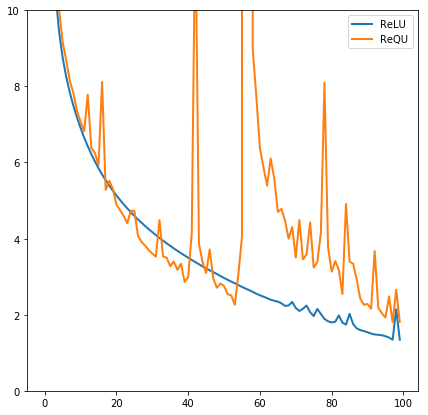

In [18]:
### Comparing ReLU and ReQU
plt.plot(H_relu, label="ReLU")
plt.plot(H_requ, label="ReQU")
plt.ylim([0, 10])
plt.legend()

# Tests

In [19]:
result = {}

input = (Variable(torch.randn(20,20).double(), requires_grad=True),)
result['requ'] = 1.0*int(gradcheck(ReQU(), input, eps=1e-6, atol=1e-4))

# If code is slow, you can use build_logreg !
model = build_logreg(784, 10) 
loss = torch.nn.CrossEntropyLoss(size_average=True)
init_w = get_model_weights(model)
down = 0
for _ in range(10):
    loss_before = L(w=init_w, model=model, loss=loss)
    set_model_weights(model=model, w=init_w)
    v = ES_grad(model, loss, x_tr=x_train, y_tr=y_train, sigma=0.002, N=50)
    loss_after = L(w=init_w - 0.1*v, model=model, loss=loss)
    if loss_before > loss_after:
        down += 1
# This code is stochastic, so of course sometimes this assert can fail. 
result['ES'] = int(down > 6)



Columns 0 to 12 
    1     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    

100%|██████████| 50/50 [00:01<00:00, 45.43it/s]


In [20]:
result

{'ES': 1, 'requ': 1.0}

In [21]:
json.dump(result, open("4a_computing_gradient.json", "w"))